# Artificial Neural Networks and Deep Learning

---

## Homework 2: Minimal Working Example

To make your first submission, follow these steps:
1. Create a folder named `[2024-2025] AN2DL/Homework 2` in your Google Drive.
2. Upload the `mars_for_students.npz` file to this folder.
3. Upload the Jupyter notebook `Homework 2 - Minimal Working Example.ipynb`.
4. Load and process the data.
5. Implement and train your model.
6. Submit the generated `.csv` file to Kaggle.


## 🌐 Connect Colab to Google Drive

In [ ]:
from google.colab import drive

drive.mount("/gdrive")
%cd /gdrive/My Drive/[2024-2025] AN2DL/Homework 2

Mounted at /gdrive
/gdrive/My Drive/[2024-2025] AN2DL/Homework 2


## ⚙️ Import Libraries

In [ ]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import matplotlib.pyplot as plt
%matplotlib inline

seed=8
np.random.seed(seed)
tf.random.set_seed(seed)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None): #Serve per fare in modo di avere sempre gli stessi colori quando abbiamo una stessa classe
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

TensorFlow version: 2.17.1
Keras version: 3.5.0
GPU devices: 1


## ⏳ Load the Data

In [ ]:
# Load dataset without outliers
data = np.load("no_outliers_dataset.npz")

training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Training X shape: (2505, 64, 128)
Training y shape: (2505, 64, 128)
Test X shape: (10022, 64, 128)
Input shape: (64, 128, 1)
Number of classes: 5


## 🛠️ Train and Save the Model

In [ ]:
# Set batch size for training
BATCH_SIZE = 32

# Set learning rate for the optimiser
LEARNING_RATE = 1e-3

# Set early stopping patience threshold
PATIENCE = 30

# Set maximum number of training epochs
EPOCHS = 300

# Set data split size for training and validation
SPLITS_SIZE = 180

In [ ]:
# Shuffle the array
indices = np.random.permutation(y_train.shape[0])

X_train = X_train[indices]
y_train = y_train[indices]

In [ ]:
# Counting the occurrences of classes
unique_values, counts = np.unique(y_train, return_counts=True)

# Exclude class zero
mask = unique_values != 0
filtered_values = unique_values[mask]
filtered_counts = counts[mask]

tot = np.mean(filtered_counts)

w = np.zeros(len(unique_values))

# Calcute the weights for each class
for i, (value, count) in enumerate(zip(filtered_values, filtered_counts)):
    print(f"Valore {value}: {count} occorrenze")
    w[i+1] = tot / count
w[0]=0 # weight of class 0 set to zero
w[4]=20 # weight of class 4 set to 20

print("Pesi finali:", w)

Valore 1.0: 6957538 occorrenze
Valore 2.0: 4776810 occorrenze
Valore 3.0: 3770823 occorrenze
Valore 4.0: 26963 occorrenze
Pesi finali: [ 0.          0.55810453  0.8128926   1.02975756 20.        ]


In [ ]:
from sklearn.model_selection import train_test_split
print("Splitting data...")
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=SPLITS_SIZE, random_state=seed
)
print("Data splitted!")

print(f"\nNumber of images:")
print(f"Train: {len(X_train)}")
print(f"Validation: {len(X_val)}")

Splitting data...
Data splitted!

Number of images:
Train: 2325
Validation: 180


In [ ]:
from tensorflow.keras import regularizers
def unet_block(input_tensor, filters, kernel_size, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1),kernel_regularizer=regularizers.l2(0.01))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # Return the transformed tensor
    return x

In [ ]:
def get_unet_model2(input_shape=input_shape, num_classes=num_classes, seed=seed, dropout_rate=0.3):
    tf.random.set_seed(seed)
    kernel_size=3
    input_layer = tfkl.Input(shape=input_shape, name='input_layer1')

    # Downsampling path
    down_block_1 = unet_block(input_layer, 32, kernel_size,name='down_block1.2_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 64,kernel_size, name='down_block2.2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    down_block_3 = unet_block(d2, 128, kernel_size,name='down_block3.2_')
    d3 = tfkl.MaxPooling2D()(down_block_3)

    # Bottleneck
    bottleneck = unet_block(d3, 256,kernel_size, name='bottleneck2', )
    # Applying dilated convolutions for capturing a larger receptive field
    bottleneck_dilated = tfkl.Conv2D(256, kernel_size, dilation_rate=2, padding='same', activation='relu')(bottleneck)
    bottleneck_dilated = tfkl.Conv2D(256, kernel_size, dilation_rate=2, padding='same', activation='relu')(bottleneck_dilated)
    # Add residual connection to bottleneck
    bottleneck_residual = tfkl.Add()([bottleneck, bottleneck_dilated])


    # Upsampling path
    u2 = tfkl.UpSampling2D()(bottleneck_residual)
    u2 = tfkl.Concatenate()([u2, down_block_3])
    u2 = unet_block(u2, 128,kernel_size, name='up_block2.2_')
    u2 = tfkl.Dropout(0.2)(u2)

    u3 = tfkl.UpSampling2D()(u2)
    u3 = tfkl.Concatenate()([u3, down_block_2])
    u3 = unet_block(u3, 64,kernel_size, name='up_block3.2_')
    u3 = tfkl.Dropout(0.2)(u3)

    u4 = tfkl.UpSampling2D()(u3)
    u4 = tfkl.Concatenate()([u4, down_block_1])
    u4 = unet_block(u4, 32, kernel_size,name='up_block4.2_')
    u4 = tfkl.Dropout(0.2)(u4)

    # Output Layer: L'ultimo è convolution, non dense layer, però usiamo kernel size=1 con softmax e il numero di filtri è il numero di classi
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer2')(u4)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet2')
    return model

In [ ]:
model2 = get_unet_model2()


In [ ]:
def apply_category_mapping(label):
    """
    Apply category mapping to labels.
    """
    keys_tensor = tf.constant(list(category_map.keys()), dtype=tf.int32)
    vals_tensor = tf.constant(list(category_map.values()), dtype=tf.int32)
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=0
    )
    return table.lookup(label)

In [ ]:
# Define custom Mean Intersection Over Union metric
#@tf.keras.utils.register_keras_serializable(package="Custom")
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image_path, label_path, frequency=4):
        super().__init__()
        self.image_path = image_path
        self.label_path = label_path
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            #image, label = load_single_image(self.image_path, self.label_path)
            image=self.image_path
            label=self.label_path
           # label = apply_category_mapping(label)
            image = tf.expand_dims(image, 0)
            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            #num_classes = num_classes
            colormap = create_segmentation_colormap(num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0])
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            # colored_label = apply_colormap(label.numpy(), colormap)
            colored_label = apply_colormap(label, colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

In [ ]:
# Convert to dictionary or list
class_weights = dict(enumerate(w))
print("Class weights:", class_weights)

Class weights: {0: 0.0, 1: 0.5581045335289581, 2: 0.8128925998731371, 3: 1.0297575622085682, 4: 20.0}


In [ ]:
#Define the Focal Loss per Sparse Categorical Crossentropy.
import tensorflow.keras.backend as K
#@tf.keras.utils.register_keras_serializable(package="Custom")
def focal_sparse_categorical_crossentropy(y_true, y_pred, gamma=2.0, alpha=np.array(list(class_weights.values()))):

    #Args:
        #y_true: Tensor with real labels (scalar integers, not one-hot).
        #y_pred: Tensor with predicted probabilities  (after softmax).
        #gamma: Modulation factor to stress on difficult examples
        #alpha: Balancing weight for classes (default 0.25 for imbalanced dataset)


    #Returns:
        #Tensor with the computed focal loss.

    # Convert y_true to integer format if necessary
    y_true = tf.cast(y_true, tf.int32)

    # Temporarily apply one-hot encoding to gather probabilities for the correct
    y_true_one_hot = tf.one_hot(y_true, depth=tf.shape(y_pred)[-1])

    # Convert alpha to a tensor and aligns it to the correct shape
    alpha = tf.constant(alpha, dtype=tf.float32)  # Shape: (num_classes,)
    alpha_weights = tf.reduce_sum(y_true_one_hot * alpha, axis=-1)  # Shape: (batch_size,)

    # Get the predicted probabilities for the correct classes
    p_t = tf.reduce_sum(y_true_one_hot * y_pred, axis=-1)  # Shape: (batch_size,)

    # Calculate the focal loss term
    focal_term = alpha_weights * tf.pow(1 - p_t, gamma)

    # Calculate the Sparse Categorical Crossentropy
    loss = -tf.math.log(tf.clip_by_value(p_t, K.epsilon(), 1.0))

    # Combine with the focal term
    focal_loss = focal_term * loss

    return tf.reduce_mean(focal_loss)



In [ ]:
# Compile the model
print("Compiling model...")
model2.compile(
    loss=focal_sparse_categorical_crossentropy,
    optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=num_classes,labels_to_exclude=[0])]
)
print("Model2 compiled!")

Compiling model...
Model2 compiled!


In [ ]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mean_iou',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

viz_callback1 = VizCallback(X_val[4], y_val[4])
viz_callback2 = VizCallback(X_val[6], y_val[6])

Epoch 1/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.3154 - loss: 8.0446 - mean_iou: 0.1601

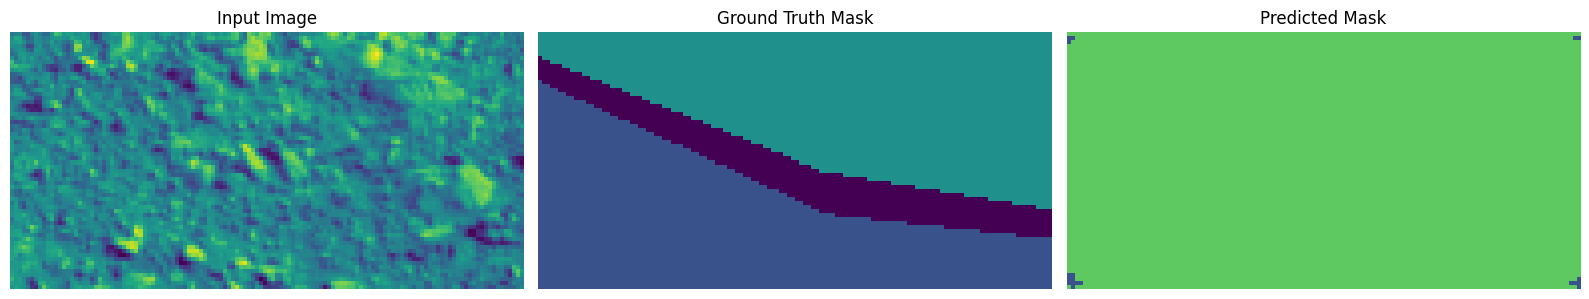

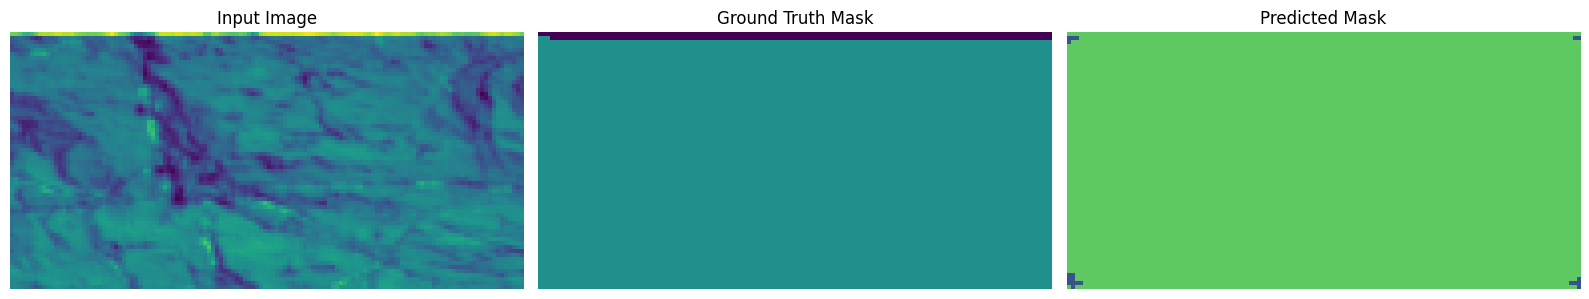

73/73 ━━━━━━━━━━━━━━━━━━━━ 84s 615ms/step - accuracy: 0.3158 - loss: 7.9998 - mean_iou: 0.1604 - val_accuracy: 0.1715 - val_loss: 1.6633 - val_mean_iou: 0.0552 - learning_rate: 0.0010
Epoch 2/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 18s 81ms/step - accuracy: 0.3821 - loss: 1.1557 - mean_iou: 0.2123 - val_accuracy: 0.1767 - val_loss: 0.9979 - val_mean_iou: 0.0599 - learning_rate: 0.0010
Epoch 3/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.3843 - loss: 0.7020 - mean_iou: 0.2168 - val_accuracy: 0.1719 - val_loss: 0.9400 - val_mean_iou: 0.0556 - learning_rate: 0.0010
Epoch 4/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - accuracy: 0.4070 - loss: 0.5341 - mean_iou: 0.2334 - val_accuracy: 0.1738 - val_loss: 0.7597 - val_mean_iou: 0.0570 - learning_rate: 0.0010
Epoch 5/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.3970 - loss: 0.4829 - mean_iou: 0.2263

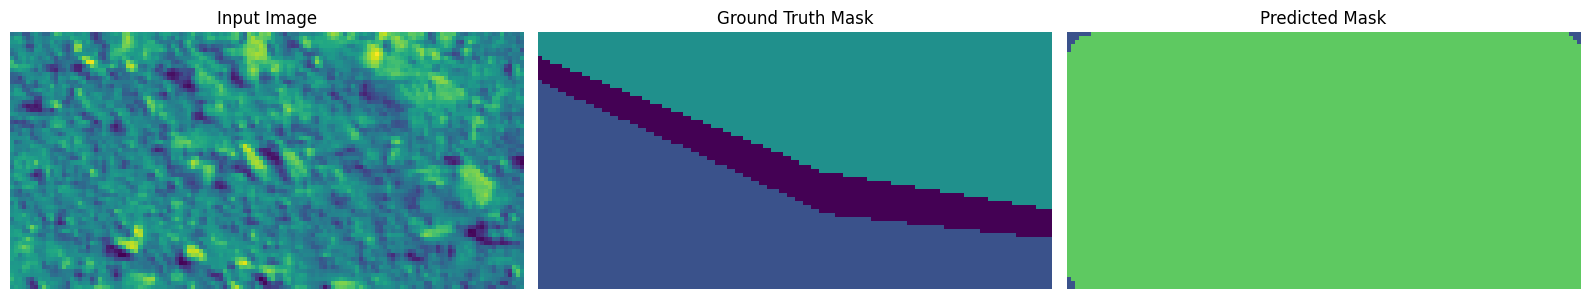

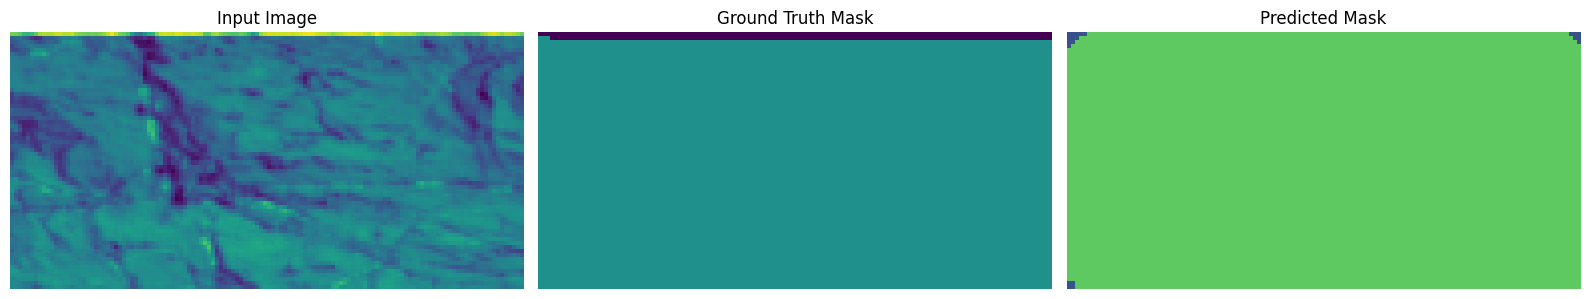

73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - accuracy: 0.3971 - loss: 0.4830 - mean_iou: 0.2264 - val_accuracy: 0.1716 - val_loss: 2.3549 - val_mean_iou: 0.0552 - learning_rate: 0.0010
Epoch 6/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - accuracy: 0.4123 - loss: 0.4940 - mean_iou: 0.2338 - val_accuracy: 0.1726 - val_loss: 0.7158 - val_mean_iou: 0.0559 - learning_rate: 0.0010
Epoch 7/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.4430 - loss: 0.4003 - mean_iou: 0.2585 - val_accuracy: 0.2075 - val_loss: 0.8365 - val_mean_iou: 0.0812 - learning_rate: 0.0010
Epoch 8/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - accuracy: 0.4287 - loss: 0.4091 - mean_iou: 0.2518 - val_accuracy: 0.3196 - val_loss: 0.5466 - val_mean_iou: 0.1633 - learning_rate: 0.0010
Epoch 9/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.4378 - loss: 0.3875 - mean_iou: 0.2569

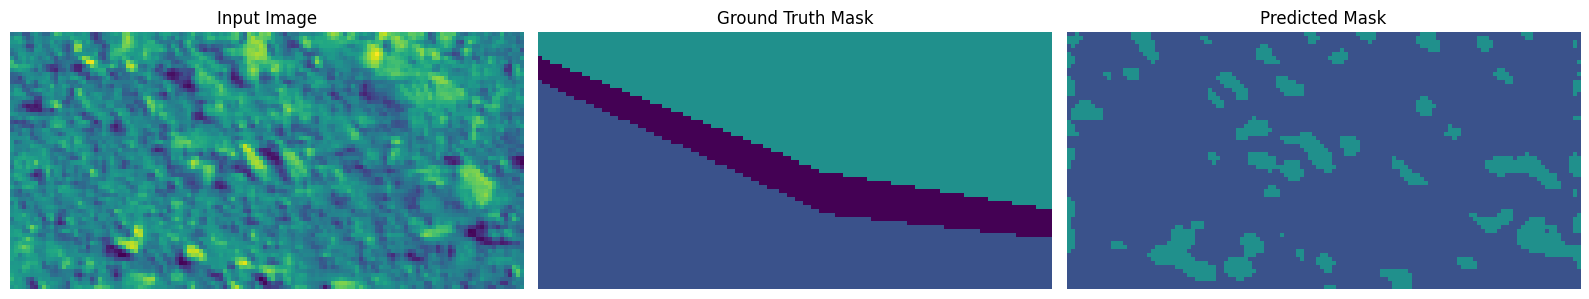

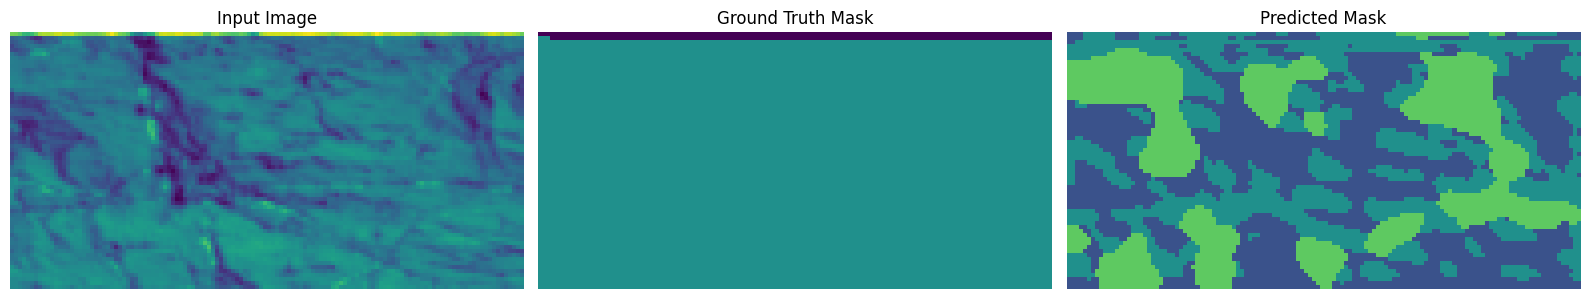

73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 92ms/step - accuracy: 0.4377 - loss: 0.3878 - mean_iou: 0.2568 - val_accuracy: 0.3509 - val_loss: 0.4874 - val_mean_iou: 0.2066 - learning_rate: 0.0010
Epoch 10/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - accuracy: 0.4355 - loss: 0.5197 - mean_iou: 0.2550 - val_accuracy: 0.2852 - val_loss: 0.6961 - val_mean_iou: 0.1596 - learning_rate: 0.0010
Epoch 11/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 0.4628 - loss: 0.4183 - mean_iou: 0.2722 - val_accuracy: 0.3536 - val_loss: 0.4610 - val_mean_iou: 0.2109 - learning_rate: 0.0010
Epoch 12/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.4622 - loss: 0.3687 - mean_iou: 0.2746 - val_accuracy: 0.4839 - val_loss: 0.3739 - val_mean_iou: 0.2927 - learning_rate: 0.0010
Epoch 13/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.5159 - loss: 0.3133 - mean_iou: 0.3199

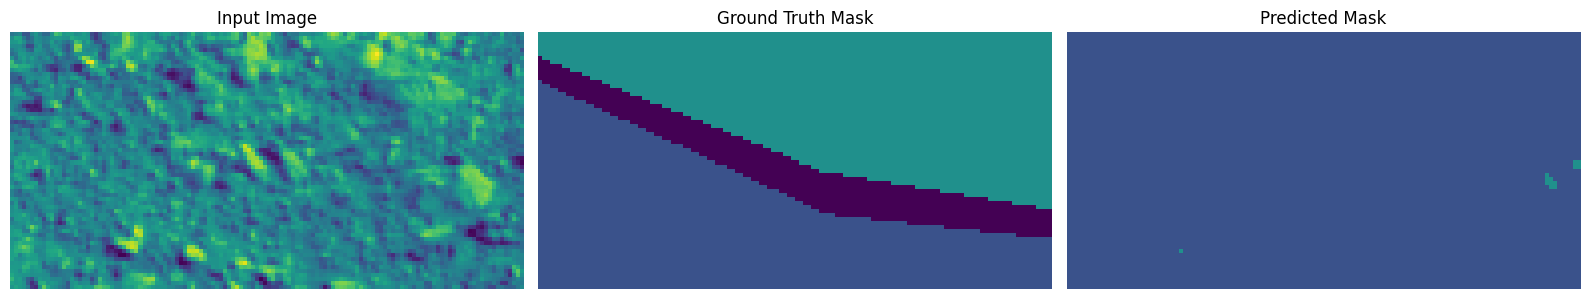

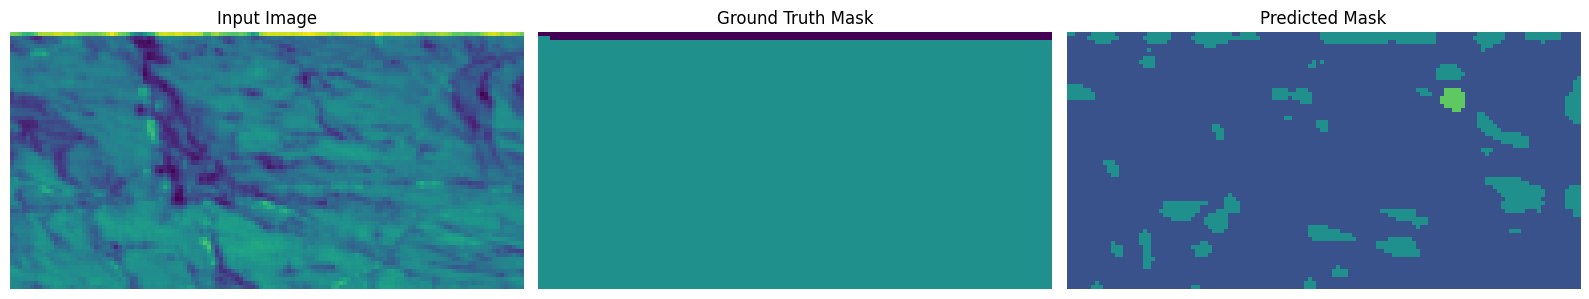

73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step - accuracy: 0.5157 - loss: 0.3134 - mean_iou: 0.3198 - val_accuracy: 0.4839 - val_loss: 0.3537 - val_mean_iou: 0.3007 - learning_rate: 0.0010
Epoch 14/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - accuracy: 0.5003 - loss: 0.3415 - mean_iou: 0.3033 - val_accuracy: 0.4702 - val_loss: 0.3816 - val_mean_iou: 0.2841 - learning_rate: 0.0010
Epoch 15/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - accuracy: 0.4421 - loss: 0.4068 - mean_iou: 0.2588 - val_accuracy: 0.4995 - val_loss: 0.4032 - val_mean_iou: 0.3409 - learning_rate: 0.0010
Epoch 16/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - accuracy: 0.4567 - loss: 0.4073 - mean_iou: 0.2664 - val_accuracy: 0.4415 - val_loss: 0.4074 - val_mean_iou: 0.2520 - learning_rate: 0.0010
Epoch 17/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.5000 - loss: 0.3416 - mean_iou: 0.3021

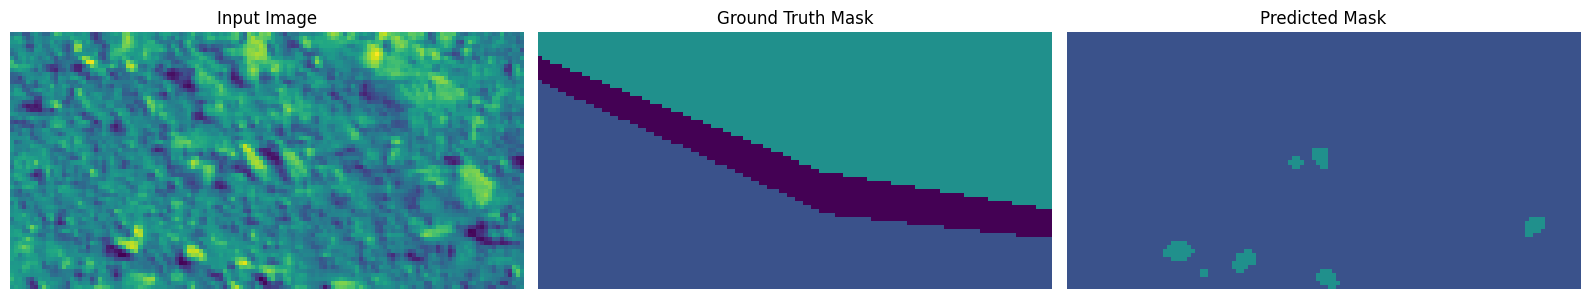

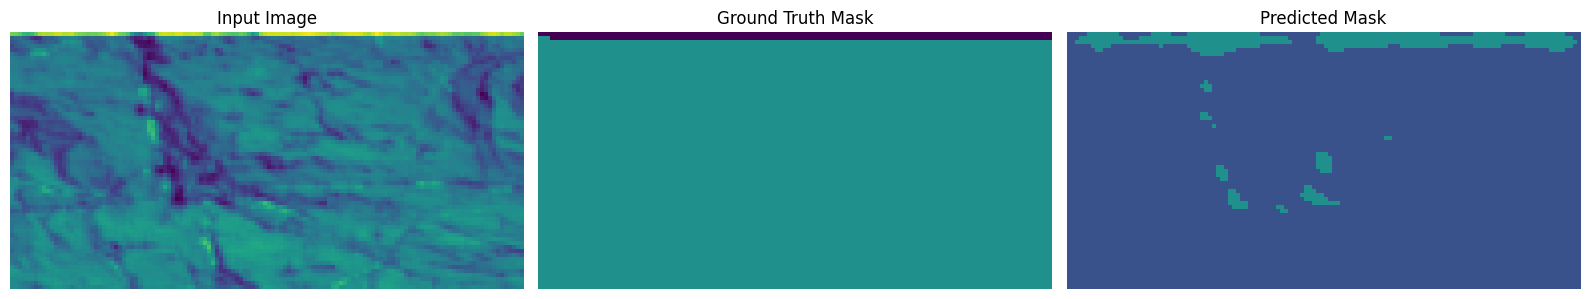

73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 96ms/step - accuracy: 0.4999 - loss: 0.3417 - mean_iou: 0.3020 - val_accuracy: 0.4163 - val_loss: 0.5285 - val_mean_iou: 0.1703 - learning_rate: 0.0010
Epoch 18/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - accuracy: 0.4752 - loss: 0.3339 - mean_iou: 0.2873 - val_accuracy: 0.4059 - val_loss: 0.4409 - val_mean_iou: 0.2793 - learning_rate: 0.0010
Epoch 19/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - accuracy: 0.4731 - loss: 0.3440 - mean_iou: 0.2861 - val_accuracy: 0.5338 - val_loss: 0.3718 - val_mean_iou: 0.3654 - learning_rate: 0.0010
Epoch 20/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - accuracy: 0.4621 - loss: 0.3608 - mean_iou: 0.2769 - val_accuracy: 0.4230 - val_loss: 0.4853 - val_mean_iou: 0.2368 - learning_rate: 0.0010
Epoch 21/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.4753 - loss: 0.3510 - mean_iou: 0.2883

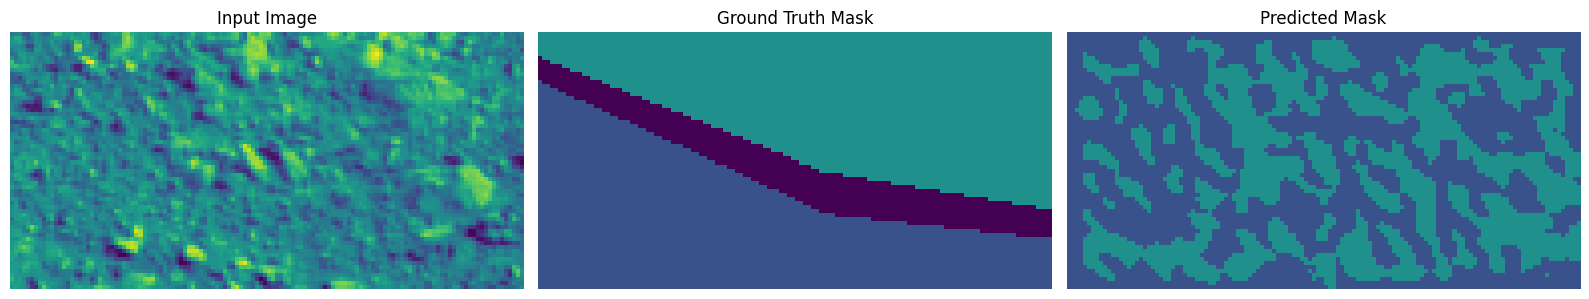

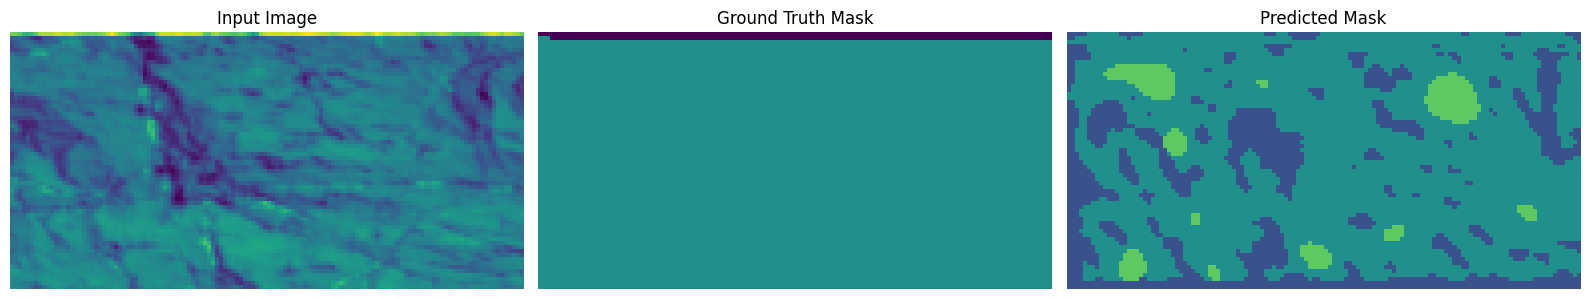

73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - accuracy: 0.4754 - loss: 0.3507 - mean_iou: 0.2884 - val_accuracy: 0.3808 - val_loss: 0.3727 - val_mean_iou: 0.2552 - learning_rate: 0.0010
Epoch 22/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - accuracy: 0.4875 - loss: 0.3274 - mean_iou: 0.2973 - val_accuracy: 0.1945 - val_loss: 0.6436 - val_mean_iou: 0.0671 - learning_rate: 0.0010
Epoch 23/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - accuracy: 0.4245 - loss: 0.3423 - mean_iou: 0.2482 - val_accuracy: 0.4071 - val_loss: 0.5035 - val_mean_iou: 0.2205 - learning_rate: 0.0010
Epoch 24/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - accuracy: 0.4958 - loss: 0.3133 - mean_iou: 0.3075 - val_accuracy: 0.4938 - val_loss: 0.3788 - val_mean_iou: 0.3269 - learning_rate: 0.0010
Epoch 25/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.4719 - loss: 0.3914 - mean_iou: 0.2815

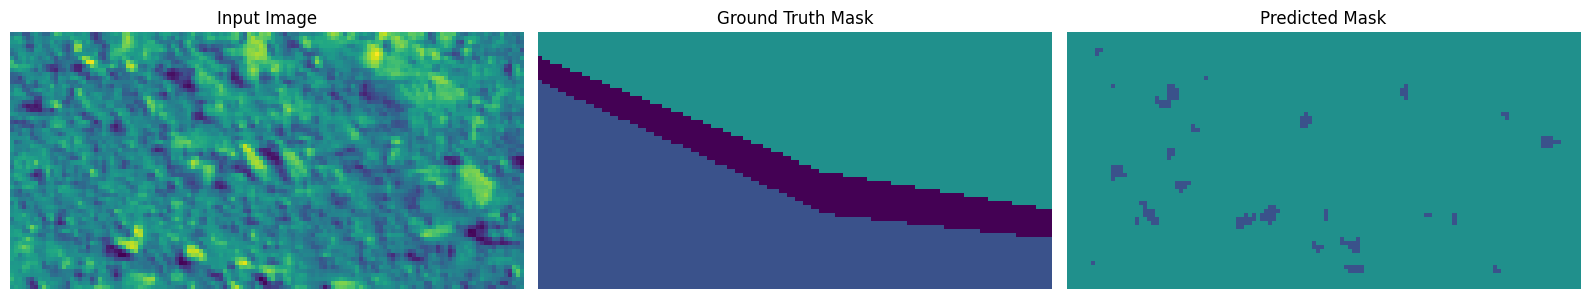

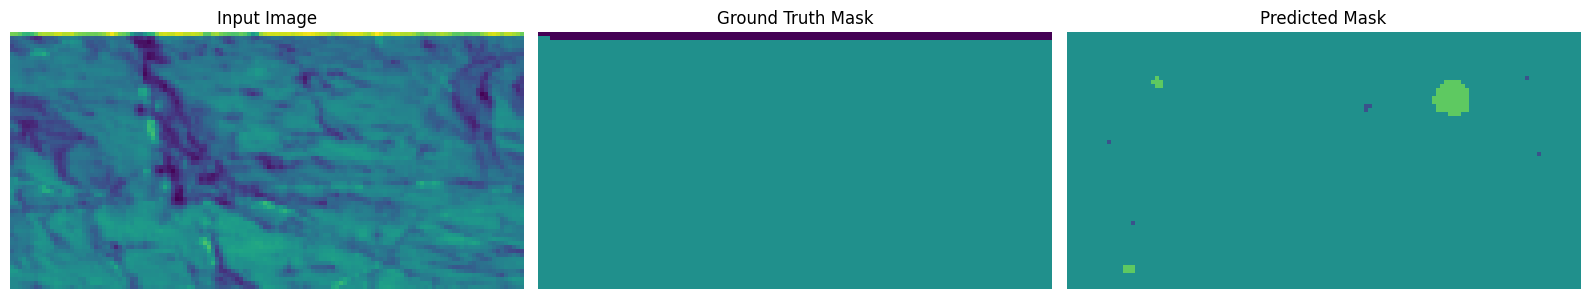

73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 0.4716 - loss: 0.3919 - mean_iou: 0.2813 - val_accuracy: 0.3326 - val_loss: 0.4023 - val_mean_iou: 0.2172 - learning_rate: 0.0010
Epoch 26/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.4677 - loss: 0.3418 - mean_iou: 0.2947 - val_accuracy: 0.4978 - val_loss: 0.4145 - val_mean_iou: 0.3450 - learning_rate: 0.0010
Epoch 27/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.4748 - loss: 0.3299 - mean_iou: 0.2865 - val_accuracy: 0.4010 - val_loss: 0.4768 - val_mean_iou: 0.2355 - learning_rate: 0.0010
Epoch 28/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - accuracy: 0.4826 - loss: 0.2958 - mean_iou: 0.2943 - val_accuracy: 0.5117 - val_loss: 0.3451 - val_mean_iou: 0.3167 - learning_rate: 0.0010
Epoch 29/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.4872 - loss: 0.3029 - mean_iou: 0.3043

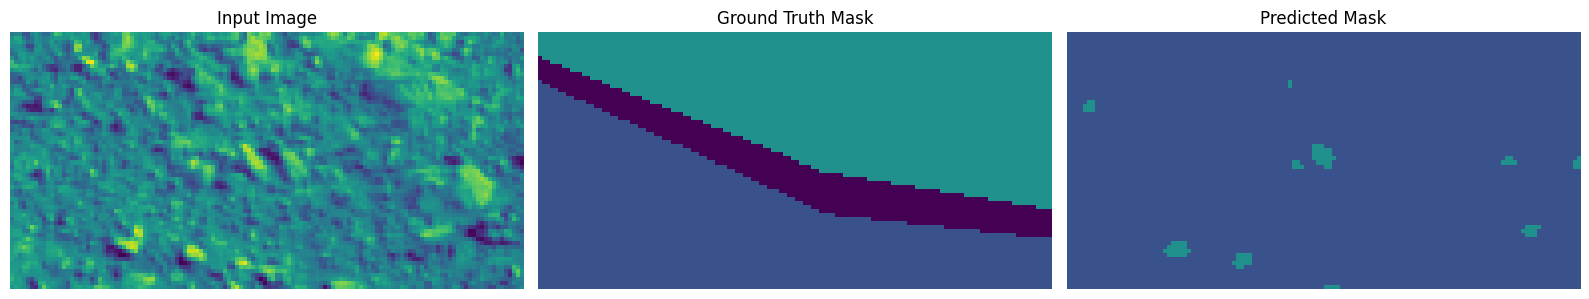

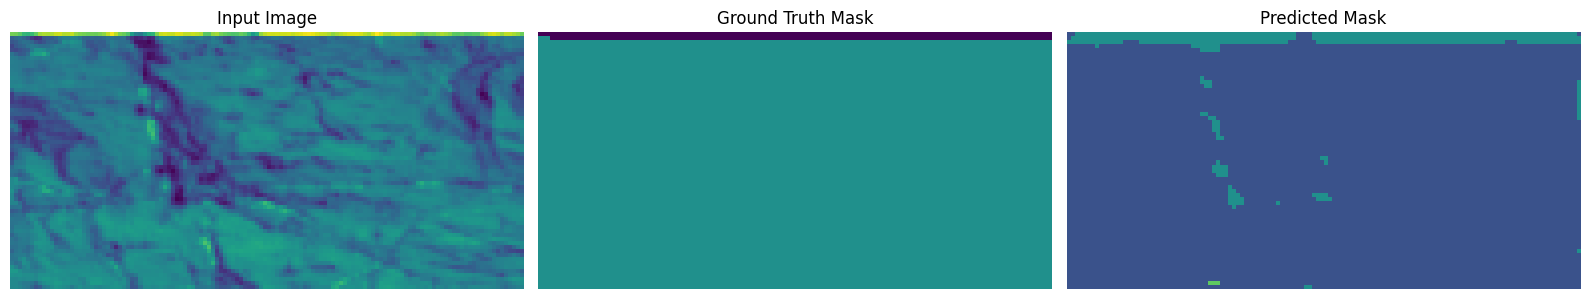

73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - accuracy: 0.4870 - loss: 0.3030 - mean_iou: 0.3041 - val_accuracy: 0.5194 - val_loss: 0.3426 - val_mean_iou: 0.3310 - learning_rate: 0.0010
Epoch 30/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.4928 - loss: 0.2806 - mean_iou: 0.3084 - val_accuracy: 0.4427 - val_loss: 0.4296 - val_mean_iou: 0.2013 - learning_rate: 5.0000e-04
Epoch 31/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.5343 - loss: 0.2596 - mean_iou: 0.3488 - val_accuracy: 0.2623 - val_loss: 0.4517 - val_mean_iou: 0.1119 - learning_rate: 5.0000e-04
Epoch 32/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - accuracy: 0.5492 - loss: 0.2622 - mean_iou: 0.3713 - val_accuracy: 0.3395 - val_loss: 0.3845 - val_mean_iou: 0.2202 - learning_rate: 5.0000e-04
Epoch 33/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.5320 - loss: 0.2698 - mean_iou: 0.3367

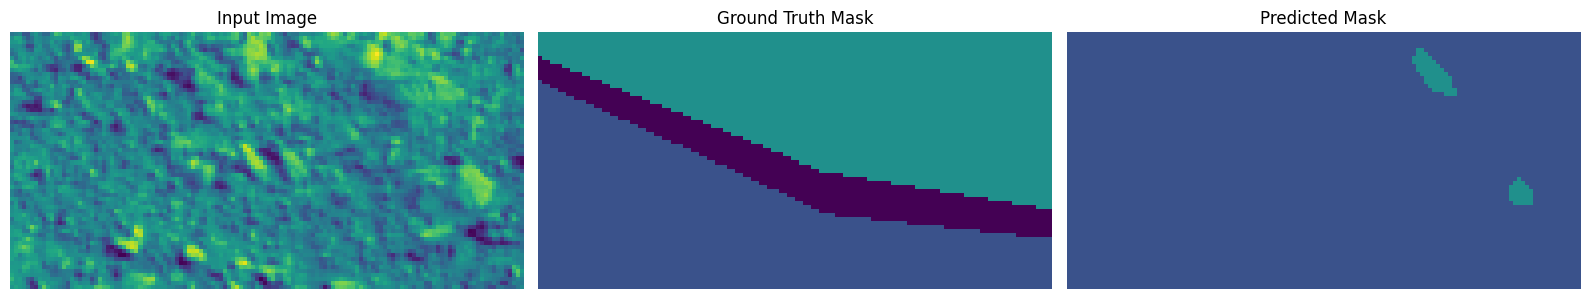

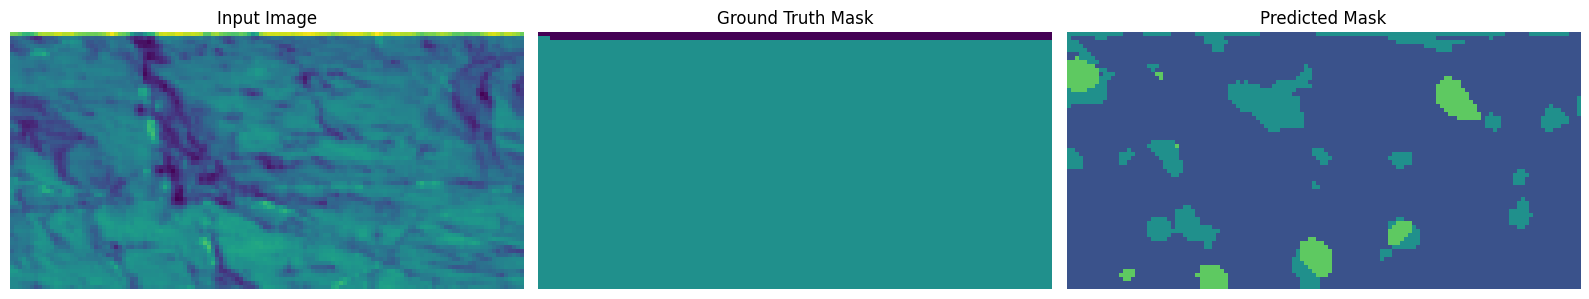

73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - accuracy: 0.5319 - loss: 0.2702 - mean_iou: 0.3365 - val_accuracy: 0.4840 - val_loss: 0.6450 - val_mean_iou: 0.3010 - learning_rate: 5.0000e-04
Epoch 34/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - accuracy: 0.5195 - loss: 0.3416 - mean_iou: 0.3272 - val_accuracy: 0.3112 - val_loss: 0.4014 - val_mean_iou: 0.2335 - learning_rate: 5.0000e-04
Epoch 35/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - accuracy: 0.4590 - loss: 0.3010 - mean_iou: 0.2787 - val_accuracy: 0.3947 - val_loss: 0.4544 - val_mean_iou: 0.1935 - learning_rate: 5.0000e-04
Epoch 36/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - accuracy: 0.5123 - loss: 0.3061 - mean_iou: 0.3204 - val_accuracy: 0.4742 - val_loss: 0.3888 - val_mean_iou: 0.2573 - learning_rate: 5.0000e-04
Epoch 37/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.5346 - loss: 0.2882 - mean_iou: 0.3456

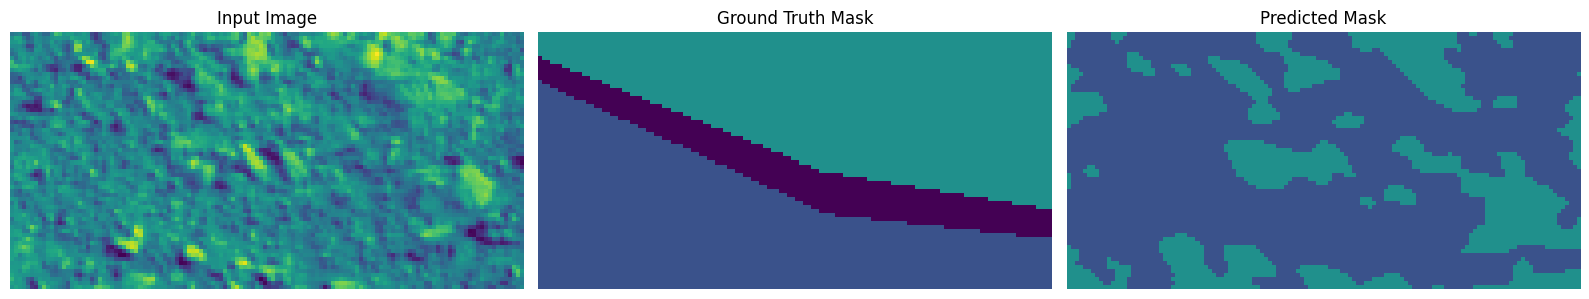

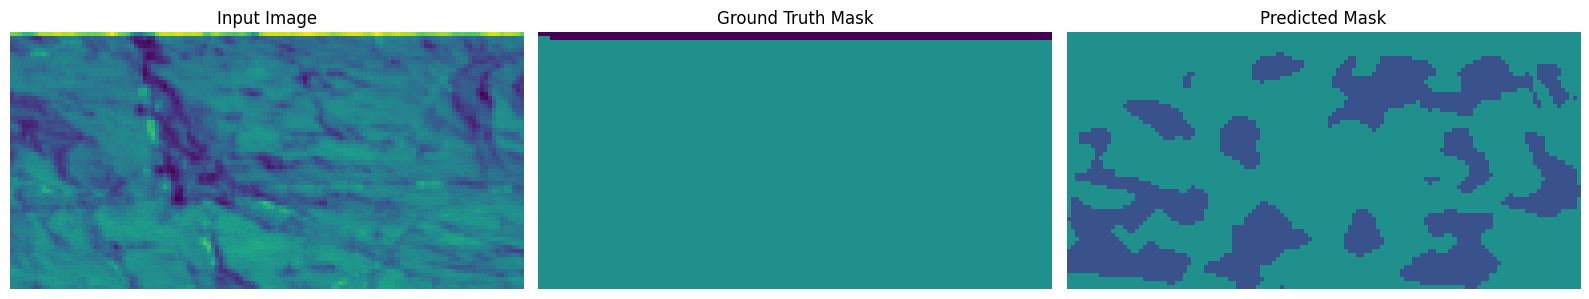

73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - accuracy: 0.5344 - loss: 0.2884 - mean_iou: 0.3453 - val_accuracy: 0.5067 - val_loss: 0.3146 - val_mean_iou: 0.3813 - learning_rate: 5.0000e-04
Epoch 38/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.5286 - loss: 0.2738 - mean_iou: 0.3415 - val_accuracy: 0.5400 - val_loss: 0.3083 - val_mean_iou: 0.3791 - learning_rate: 5.0000e-04
Epoch 39/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.5697 - loss: 0.2545 - mean_iou: 0.4163 - val_accuracy: 0.5059 - val_loss: 0.3770 - val_mean_iou: 0.3344 - learning_rate: 5.0000e-04
Epoch 40/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.5169 - loss: 0.2700 - mean_iou: 0.3575 - val_accuracy: 0.5227 - val_loss: 0.3414 - val_mean_iou: 0.3296 - learning_rate: 5.0000e-04
Epoch 41/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.5127 - loss: 0.3221 - mean_iou: 0.3410

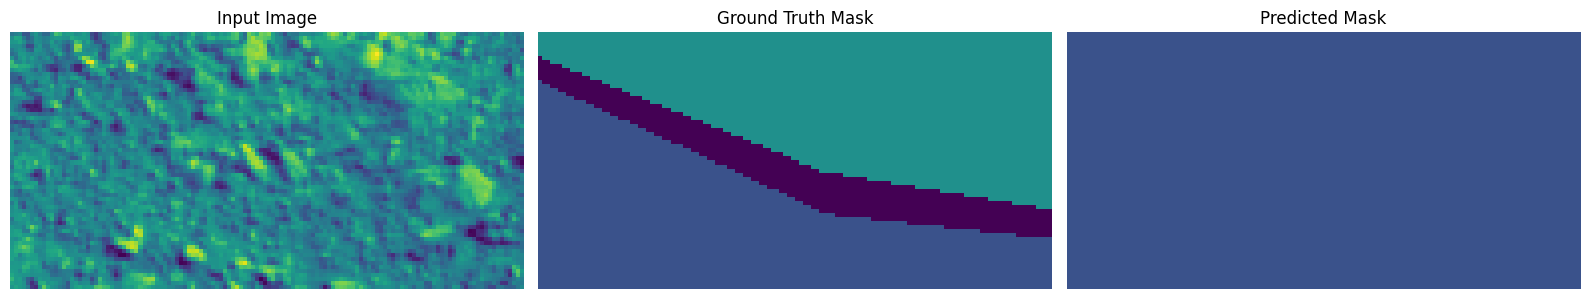

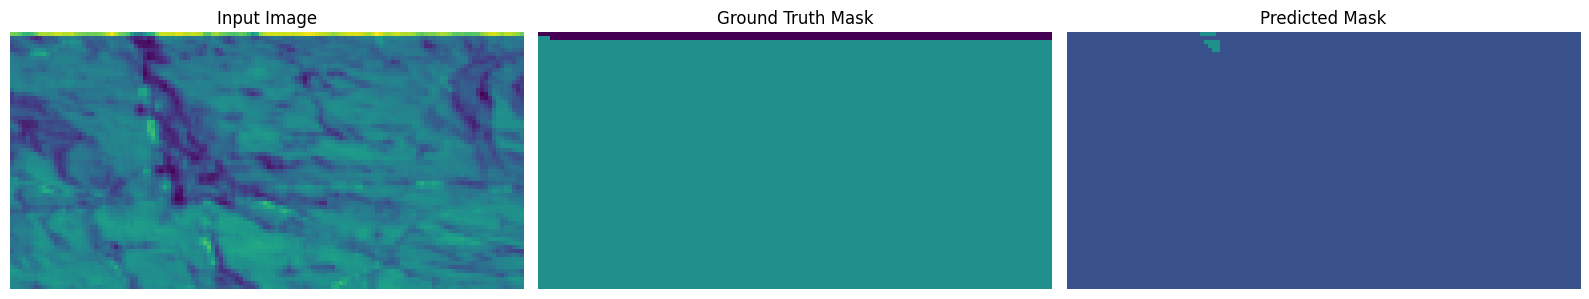

73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - accuracy: 0.5127 - loss: 0.3226 - mean_iou: 0.3407 - val_accuracy: 0.4850 - val_loss: 0.5137 - val_mean_iou: 0.2589 - learning_rate: 5.0000e-04
Epoch 42/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - accuracy: 0.5509 - loss: 0.3315 - mean_iou: 0.3518 - val_accuracy: 0.4980 - val_loss: 0.4063 - val_mean_iou: 0.2956 - learning_rate: 5.0000e-04
Epoch 43/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.5730 - loss: 0.2841 - mean_iou: 0.4217 - val_accuracy: 0.4012 - val_loss: 0.3209 - val_mean_iou: 0.3033 - learning_rate: 5.0000e-04
Epoch 44/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.5637 - loss: 0.2638 - mean_iou: 0.4235 - val_accuracy: 0.4294 - val_loss: 0.4277 - val_mean_iou: 0.1834 - learning_rate: 5.0000e-04
Epoch 45/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.5744 - loss: 0.2580 - mean_iou: 0.3810

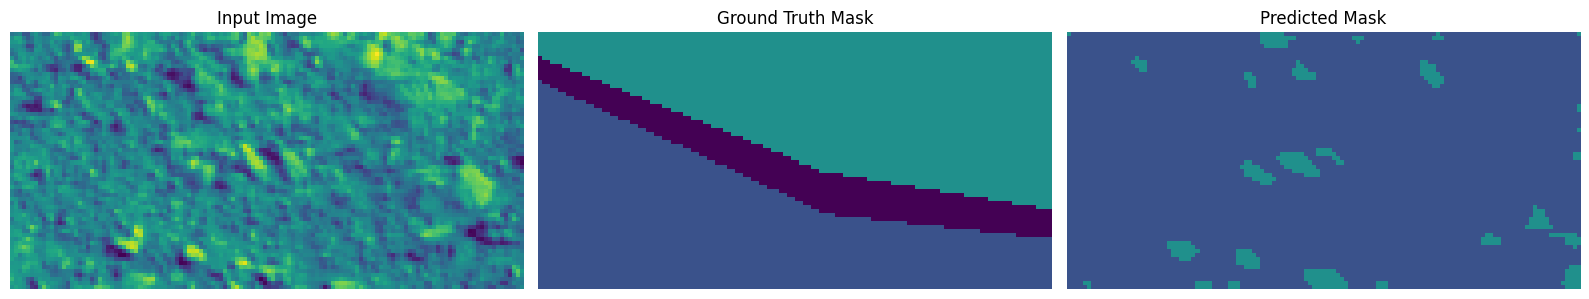

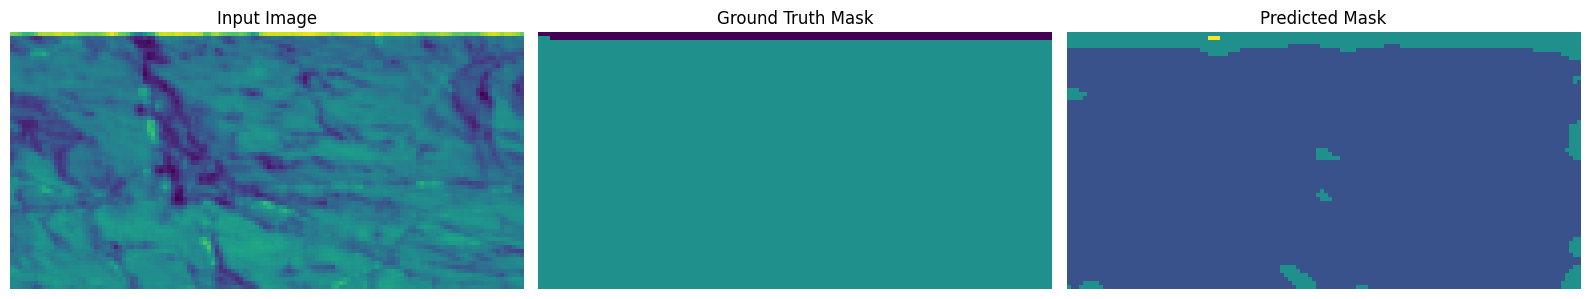

73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - accuracy: 0.5739 - loss: 0.2582 - mean_iou: 0.3805 - val_accuracy: 0.5218 - val_loss: 0.3504 - val_mean_iou: 0.3554 - learning_rate: 5.0000e-04
Epoch 46/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - accuracy: 0.5287 - loss: 0.2969 - mean_iou: 0.3360 - val_accuracy: 0.5222 - val_loss: 0.3000 - val_mean_iou: 0.3901 - learning_rate: 5.0000e-04
Epoch 47/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - accuracy: 0.5670 - loss: 0.2565 - mean_iou: 0.4199 - val_accuracy: 0.4746 - val_loss: 0.3783 - val_mean_iou: 0.2622 - learning_rate: 5.0000e-04
Epoch 48/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.5618 - loss: 0.2415 - mean_iou: 0.4367 - val_accuracy: 0.5482 - val_loss: 0.3945 - val_mean_iou: 0.4132 - learning_rate: 5.0000e-04
Epoch 49/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.5840 - loss: 0.2895 - mean_iou: 0.4769

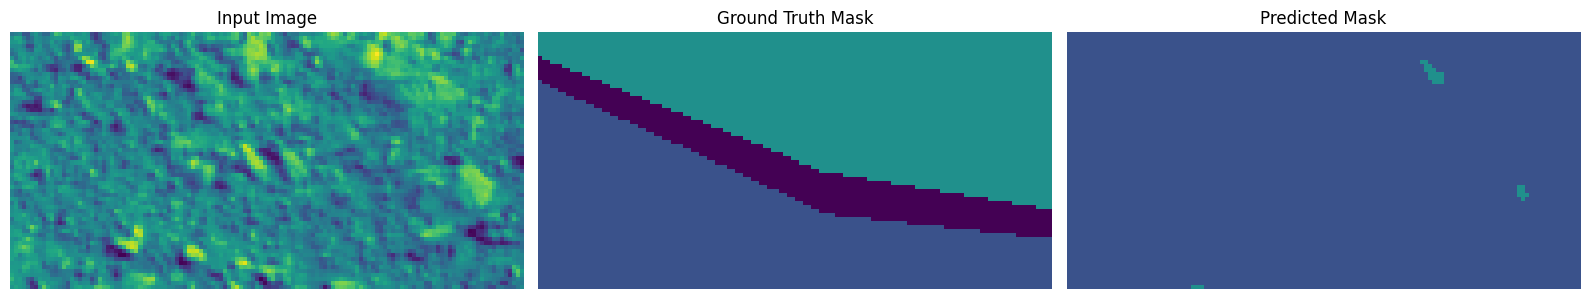

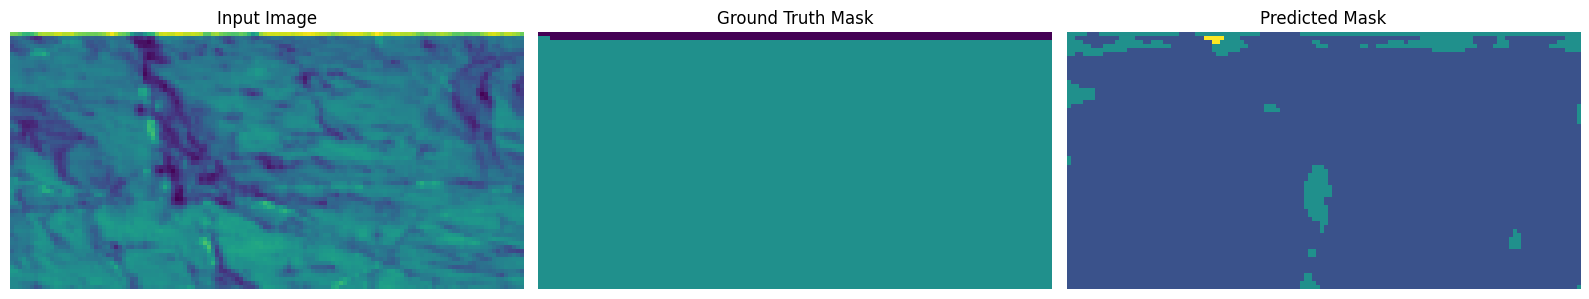

73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step - accuracy: 0.5835 - loss: 0.2894 - mean_iou: 0.4764 - val_accuracy: 0.5596 - val_loss: 0.3173 - val_mean_iou: 0.3919 - learning_rate: 5.0000e-04
Epoch 50/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy: 0.5516 - loss: 0.2510 - mean_iou: 0.4434 - val_accuracy: 0.4898 - val_loss: 0.3095 - val_mean_iou: 0.3598 - learning_rate: 5.0000e-04
Epoch 51/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.5841 - loss: 0.2416 - mean_iou: 0.4220 - val_accuracy: 0.5595 - val_loss: 0.3054 - val_mean_iou: 0.4002 - learning_rate: 5.0000e-04
Epoch 52/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.5625 - loss: 0.2679 - mean_iou: 0.4130 - val_accuracy: 0.5578 - val_loss: 0.2845 - val_mean_iou: 0.4219 - learning_rate: 5.0000e-04
Epoch 53/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.5860 - loss: 0.2410 - mean_iou: 0.4327

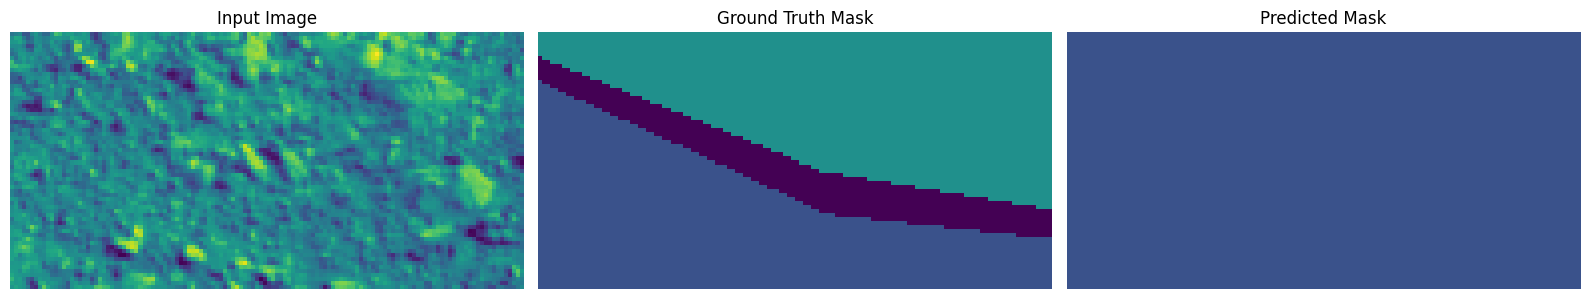

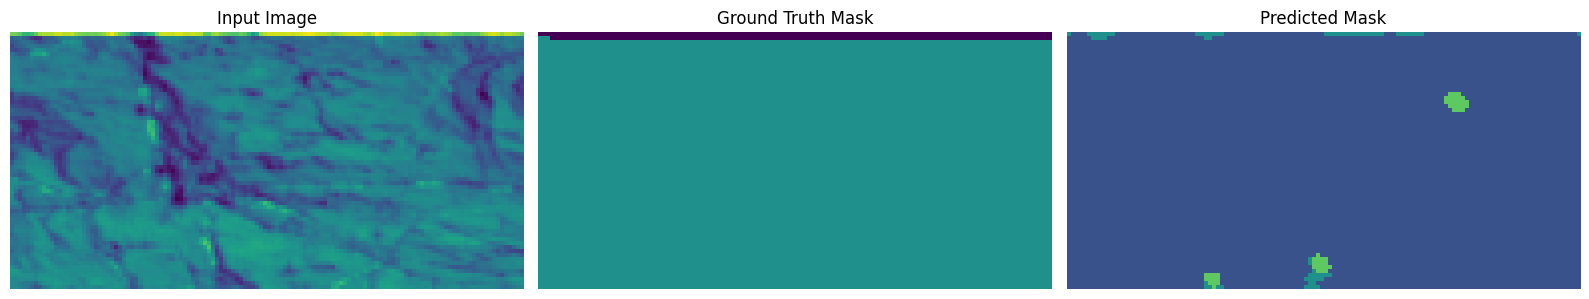

73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - accuracy: 0.5859 - loss: 0.2410 - mean_iou: 0.4320 - val_accuracy: 0.5095 - val_loss: 0.3295 - val_mean_iou: 0.3188 - learning_rate: 5.0000e-04
Epoch 54/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.5949 - loss: 0.2414 - mean_iou: 0.4918 - val_accuracy: 0.4830 - val_loss: 0.3151 - val_mean_iou: 0.3317 - learning_rate: 5.0000e-04
Epoch 55/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - accuracy: 0.5823 - loss: 0.2390 - mean_iou: 0.4262 - val_accuracy: 0.4701 - val_loss: 0.3165 - val_mean_iou: 0.3595 - learning_rate: 5.0000e-04
Epoch 56/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - accuracy: 0.5889 - loss: 0.2374 - mean_iou: 0.4609 - val_accuracy: 0.5334 - val_loss: 0.3005 - val_mean_iou: 0.3996 - learning_rate: 5.0000e-04
Epoch 57/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.5724 - loss: 0.2296 - mean_iou: 0.4669

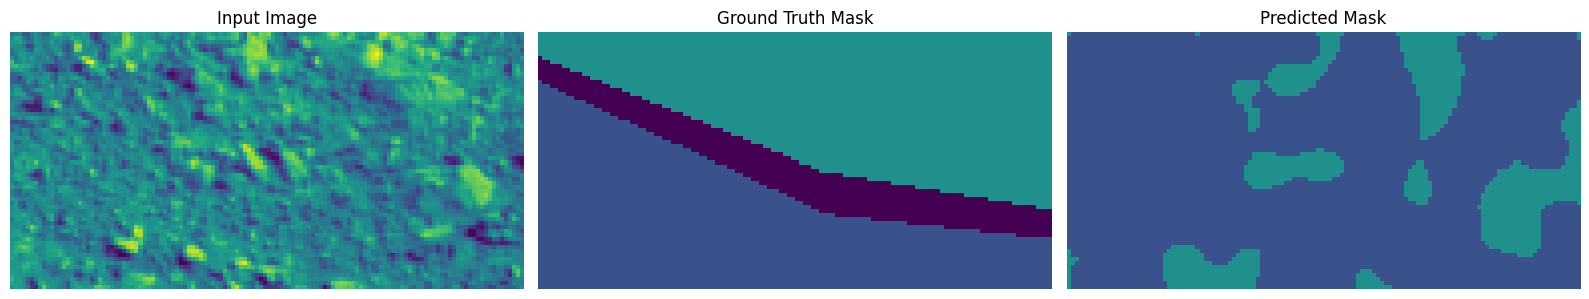

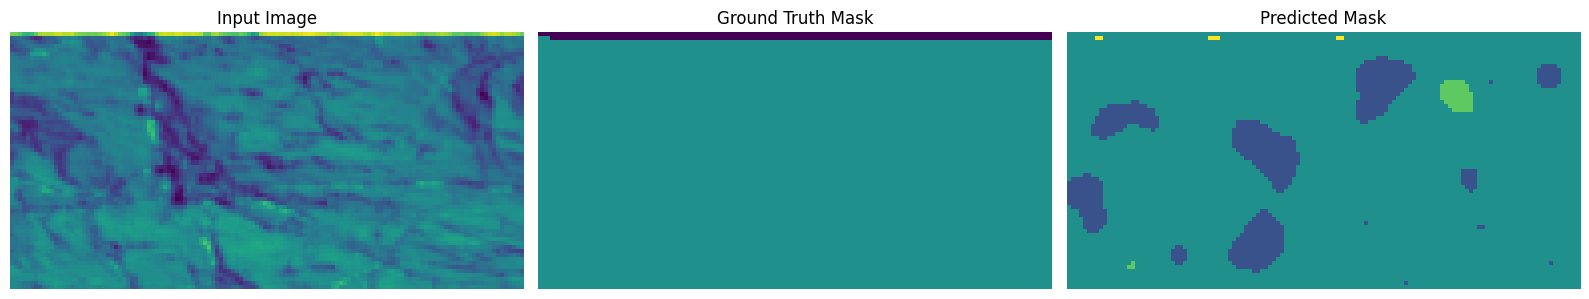

73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - accuracy: 0.5722 - loss: 0.2298 - mean_iou: 0.4668 - val_accuracy: 0.4455 - val_loss: 0.3554 - val_mean_iou: 0.3086 - learning_rate: 5.0000e-04
Epoch 58/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - accuracy: 0.5485 - loss: 0.2495 - mean_iou: 0.3509 - val_accuracy: 0.5004 - val_loss: 0.4036 - val_mean_iou: 0.2992 - learning_rate: 5.0000e-04
Epoch 59/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.5529 - loss: 0.2808 - mean_iou: 0.3831 - val_accuracy: 0.4923 - val_loss: 0.7220 - val_mean_iou: 0.2655 - learning_rate: 5.0000e-04
Epoch 60/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.5715 - loss: 0.2510 - mean_iou: 0.4610 - val_accuracy: 0.4227 - val_loss: 0.5104 - val_mean_iou: 0.1529 - learning_rate: 5.0000e-04
Epoch 61/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.5889 - loss: 0.2411 - mean_iou: 0.4810

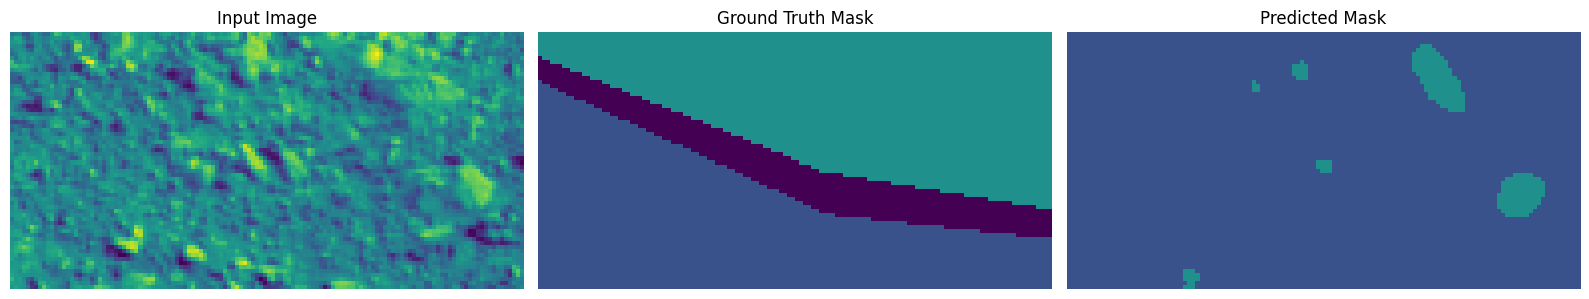

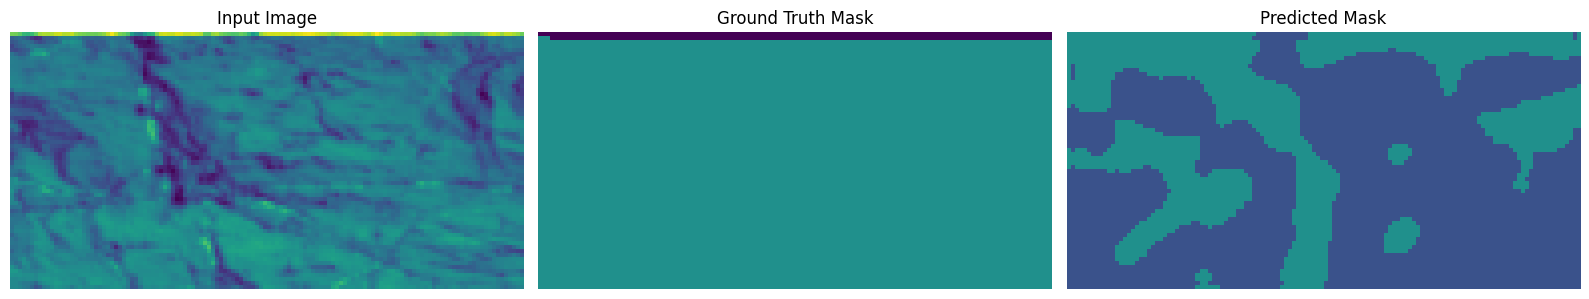

73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - accuracy: 0.5886 - loss: 0.2412 - mean_iou: 0.4808 - val_accuracy: 0.4968 - val_loss: 0.4042 - val_mean_iou: 0.3240 - learning_rate: 5.0000e-04
Epoch 62/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.5876 - loss: 0.2309 - mean_iou: 0.4828 - val_accuracy: 0.5201 - val_loss: 0.3910 - val_mean_iou: 0.3688 - learning_rate: 5.0000e-04
Epoch 63/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.5870 - loss: 0.2222 - mean_iou: 0.4851 - val_accuracy: 0.5098 - val_loss: 0.3632 - val_mean_iou: 0.3833 - learning_rate: 2.5000e-04
Epoch 64/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.6009 - loss: 0.2025 - mean_iou: 0.4930 - val_accuracy: 0.5002 - val_loss: 0.3150 - val_mean_iou: 0.3691 - learning_rate: 2.5000e-04
Epoch 65/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.6163 - loss: 0.1963 - mean_iou: 0.5227

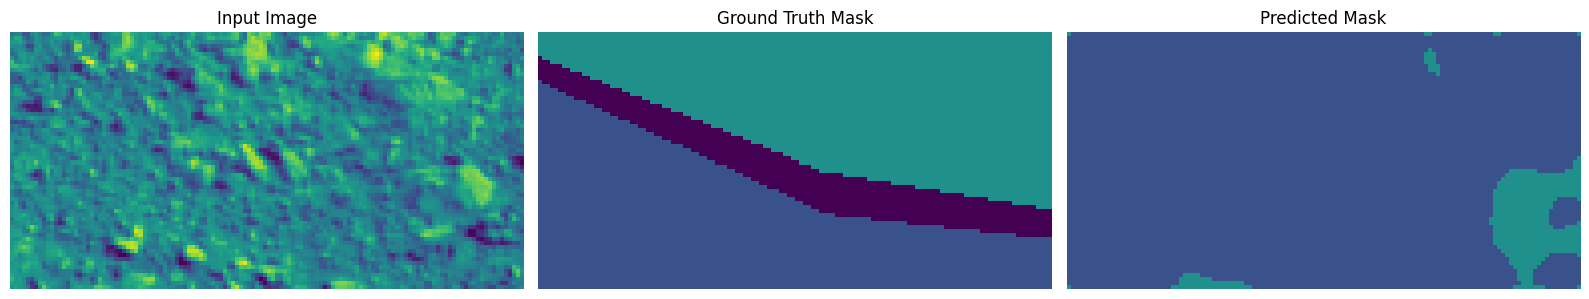

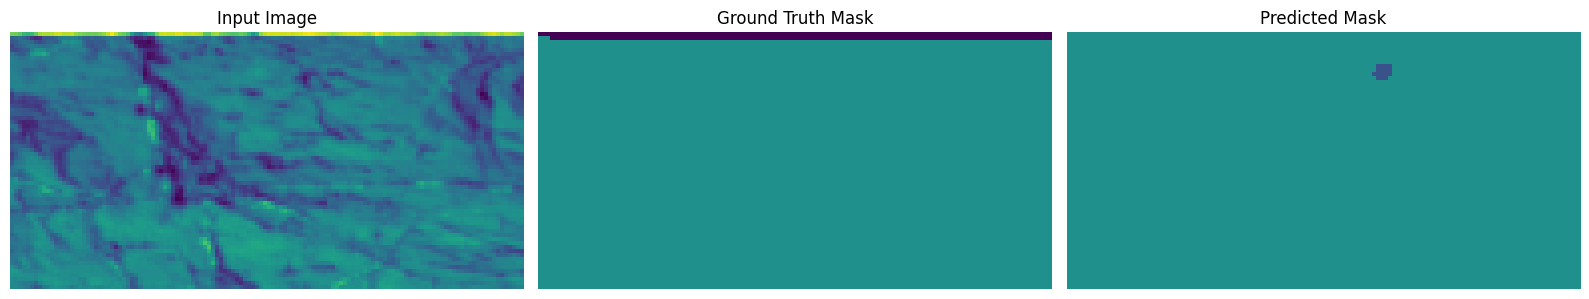

73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - accuracy: 0.6161 - loss: 0.1964 - mean_iou: 0.5225 - val_accuracy: 0.5744 - val_loss: 0.2972 - val_mean_iou: 0.4507 - learning_rate: 2.5000e-04
Epoch 66/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.6156 - loss: 0.1952 - mean_iou: 0.5220 - val_accuracy: 0.5402 - val_loss: 0.2860 - val_mean_iou: 0.4079 - learning_rate: 2.5000e-04
Epoch 67/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.6199 - loss: 0.1883 - mean_iou: 0.5278 - val_accuracy: 0.6000 - val_loss: 0.2858 - val_mean_iou: 0.4515 - learning_rate: 2.5000e-04
Epoch 68/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.6103 - loss: 0.2047 - mean_iou: 0.4524 - val_accuracy: 0.4590 - val_loss: 0.4933 - val_mean_iou: 0.2726 - learning_rate: 2.5000e-04
Epoch 69/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.6056 - loss: 0.2007 - mean_iou: 0.5071

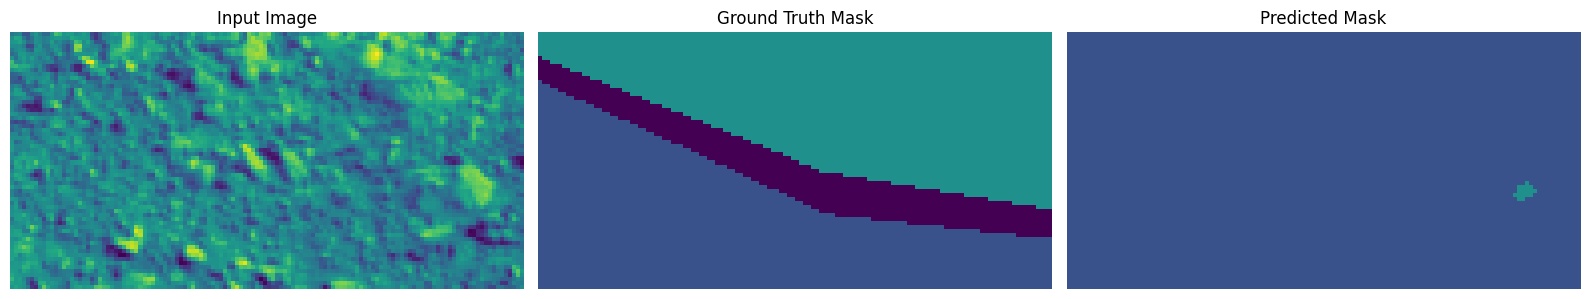

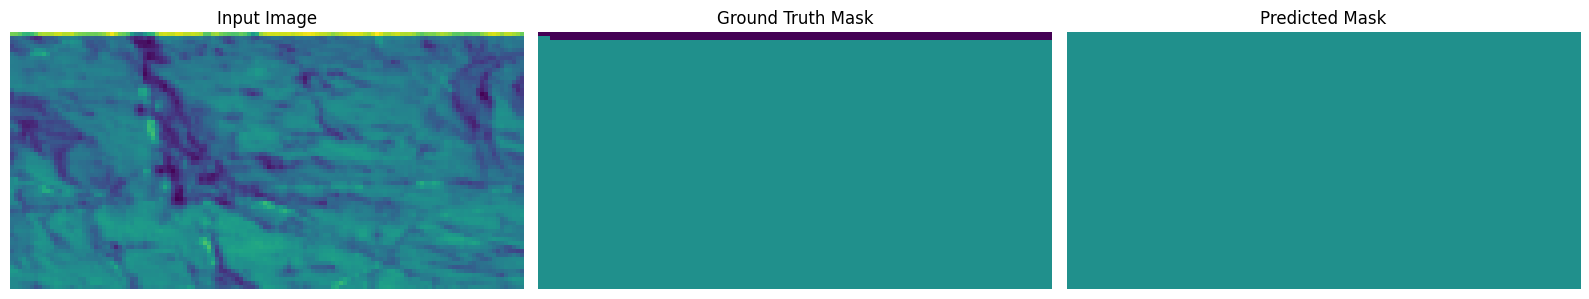

73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - accuracy: 0.6055 - loss: 0.2007 - mean_iou: 0.5071 - val_accuracy: 0.5001 - val_loss: 0.3246 - val_mean_iou: 0.3588 - learning_rate: 2.5000e-04
Epoch 70/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.6227 - loss: 0.1932 - mean_iou: 0.5294 - val_accuracy: 0.4093 - val_loss: 0.3366 - val_mean_iou: 0.2847 - learning_rate: 2.5000e-04
Epoch 71/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.6151 - loss: 0.2147 - mean_iou: 0.5173 - val_accuracy: 0.5621 - val_loss: 0.3013 - val_mean_iou: 0.4101 - learning_rate: 2.5000e-04
Epoch 72/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 0.6247 - loss: 0.1904 - mean_iou: 0.5327 - val_accuracy: 0.5798 - val_loss: 0.2905 - val_mean_iou: 0.4409 - learning_rate: 2.5000e-04
Epoch 73/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.6343 - loss: 0.1877 - mean_iou: 0.5478

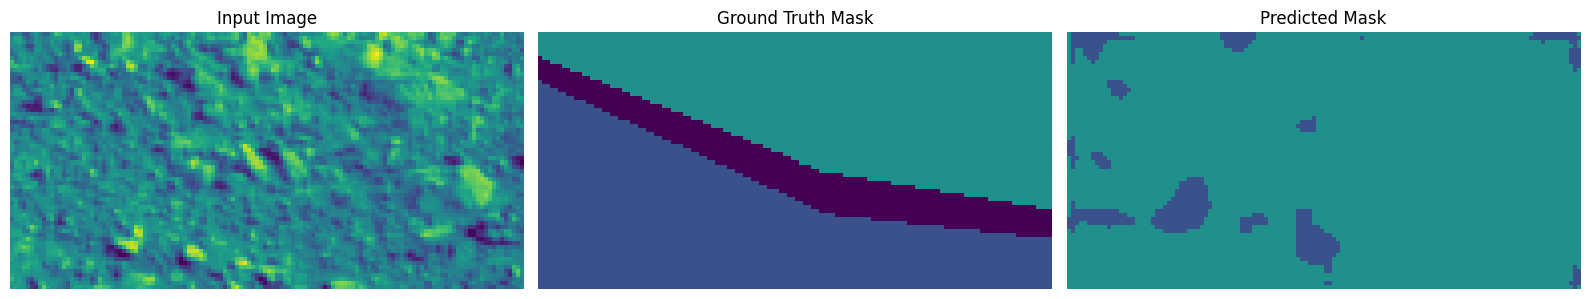

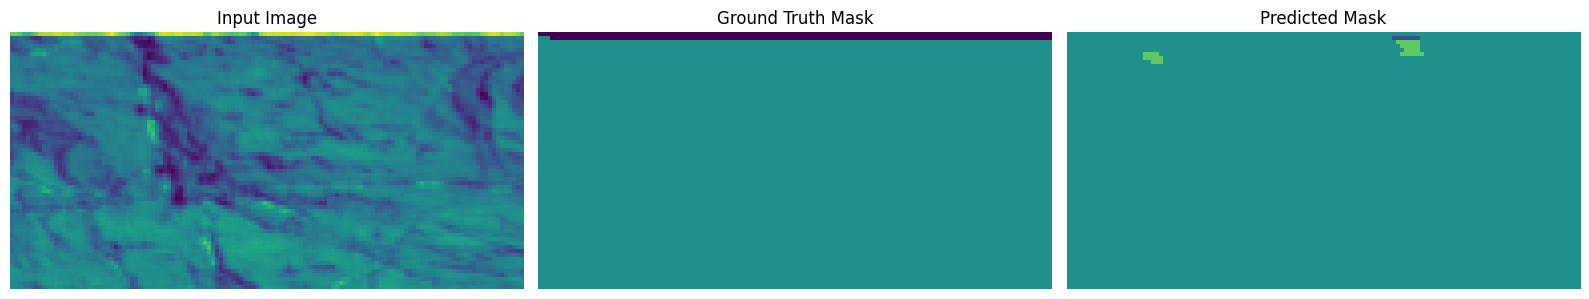

73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - accuracy: 0.6340 - loss: 0.1878 - mean_iou: 0.5476 - val_accuracy: 0.3860 - val_loss: 0.3404 - val_mean_iou: 0.2670 - learning_rate: 2.5000e-04
Epoch 74/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.6370 - loss: 0.1798 - mean_iou: 0.5505 - val_accuracy: 0.5132 - val_loss: 0.3592 - val_mean_iou: 0.4014 - learning_rate: 2.5000e-04
Epoch 75/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - accuracy: 0.6089 - loss: 0.2038 - mean_iou: 0.4871 - val_accuracy: 0.6138 - val_loss: 0.2695 - val_mean_iou: 0.4768 - learning_rate: 2.5000e-04
Epoch 76/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.6152 - loss: 0.1947 - mean_iou: 0.5228 - val_accuracy: 0.5192 - val_loss: 0.4397 - val_mean_iou: 0.3509 - learning_rate: 2.5000e-04
Epoch 77/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.6246 - loss: 0.2089 - mean_iou: 0.5290

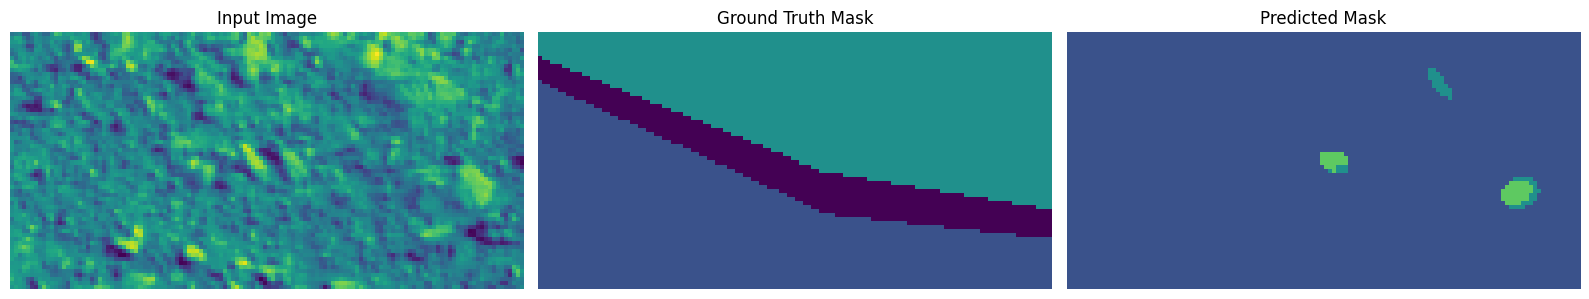

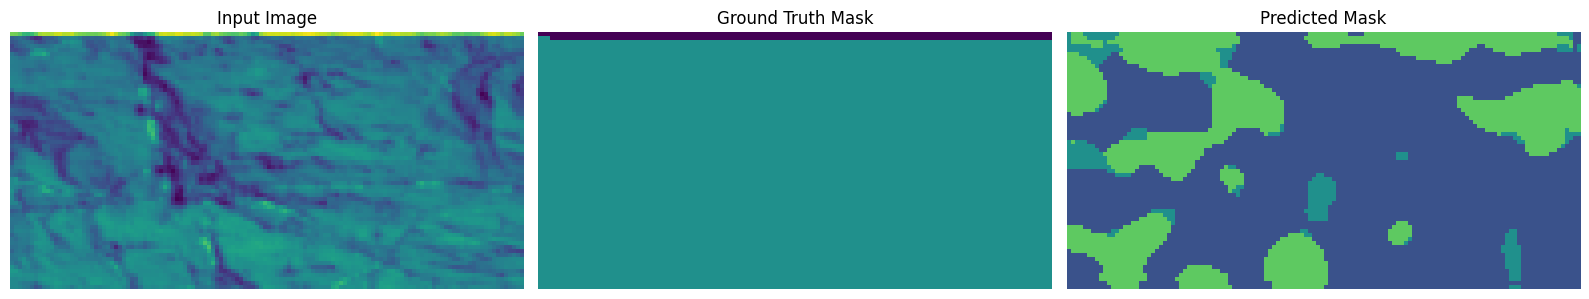

73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - accuracy: 0.6245 - loss: 0.2089 - mean_iou: 0.5290 - val_accuracy: 0.4688 - val_loss: 0.4854 - val_mean_iou: 0.2875 - learning_rate: 2.5000e-04
Epoch 78/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.6350 - loss: 0.1911 - mean_iou: 0.5466 - val_accuracy: 0.5637 - val_loss: 0.4012 - val_mean_iou: 0.3792 - learning_rate: 2.5000e-04
Epoch 79/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.6332 - loss: 0.1771 - mean_iou: 0.5472 - val_accuracy: 0.6285 - val_loss: 0.2939 - val_mean_iou: 0.4914 - learning_rate: 2.5000e-04
Epoch 80/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.6314 - loss: 0.1821 - mean_iou: 0.5448 - val_accuracy: 0.4645 - val_loss: 0.5464 - val_mean_iou: 0.2675 - learning_rate: 2.5000e-04
Epoch 81/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.6296 - loss: 0.1939 - mean_iou: 0.5425

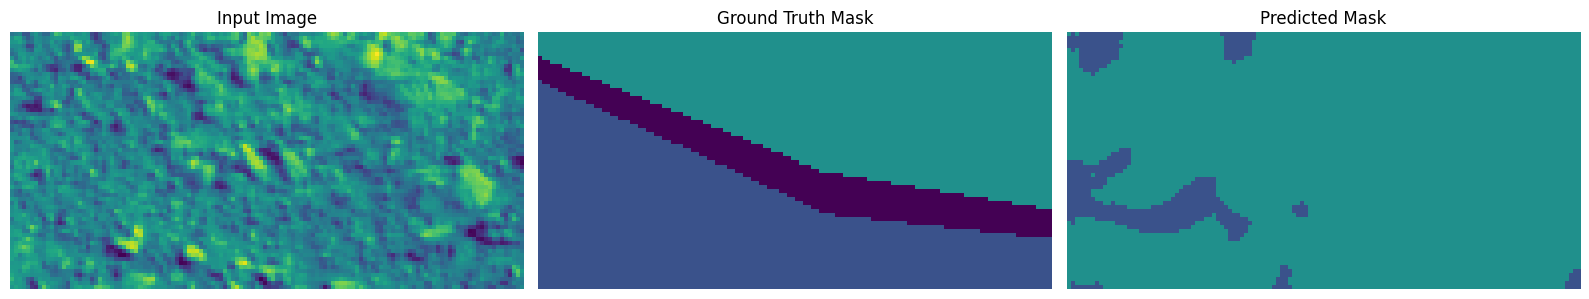

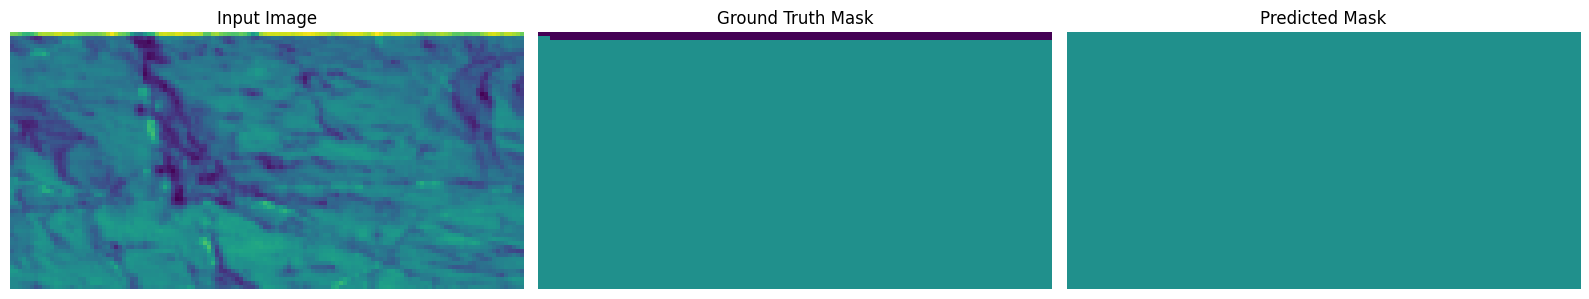

73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - accuracy: 0.6295 - loss: 0.1939 - mean_iou: 0.5425 - val_accuracy: 0.3776 - val_loss: 0.3769 - val_mean_iou: 0.3019 - learning_rate: 2.5000e-04
Epoch 82/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - accuracy: 0.6391 - loss: 0.1755 - mean_iou: 0.5555 - val_accuracy: 0.5366 - val_loss: 0.3865 - val_mean_iou: 0.4065 - learning_rate: 2.5000e-04
Epoch 83/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.6277 - loss: 0.1915 - mean_iou: 0.5389 - val_accuracy: 0.6480 - val_loss: 0.2269 - val_mean_iou: 0.5574 - learning_rate: 2.5000e-04
Epoch 84/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - accuracy: 0.6361 - loss: 0.1821 - mean_iou: 0.5518 - val_accuracy: 0.6443 - val_loss: 0.2172 - val_mean_iou: 0.5608 - learning_rate: 2.5000e-04
Epoch 85/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.6274 - loss: 0.1860 - mean_iou: 0.5394

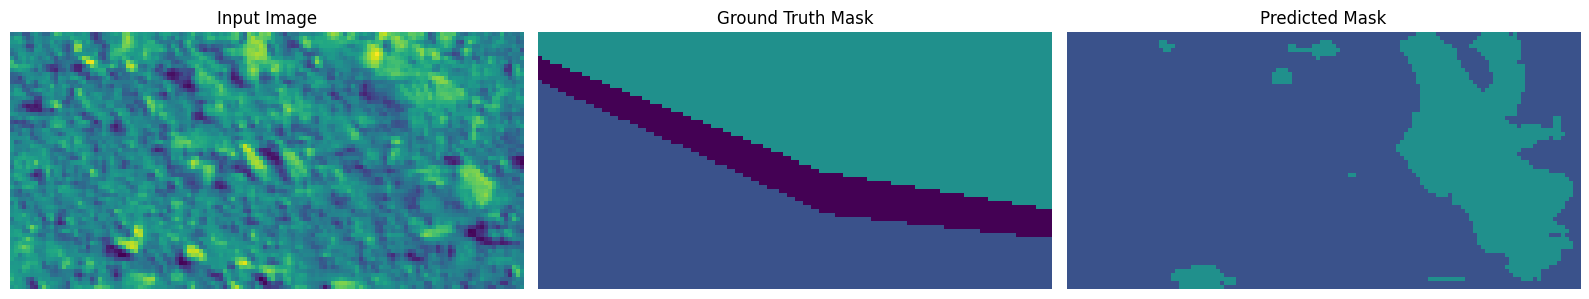

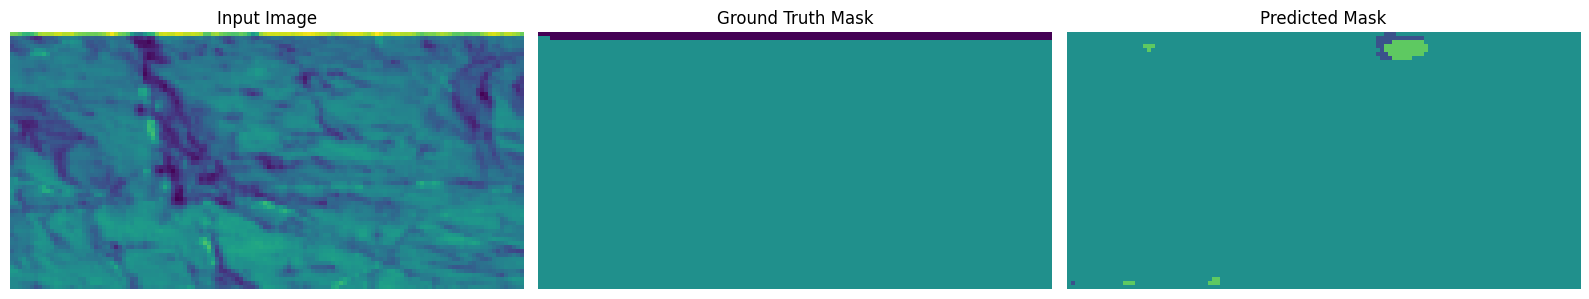

73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - accuracy: 0.6273 - loss: 0.1860 - mean_iou: 0.5394 - val_accuracy: 0.6098 - val_loss: 0.2182 - val_mean_iou: 0.5172 - learning_rate: 2.5000e-04
Epoch 86/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.6291 - loss: 0.1857 - mean_iou: 0.5444 - val_accuracy: 0.3098 - val_loss: 0.4017 - val_mean_iou: 0.2341 - learning_rate: 2.5000e-04
Epoch 87/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.6389 - loss: 0.1720 - mean_iou: 0.5557 - val_accuracy: 0.6603 - val_loss: 0.2603 - val_mean_iou: 0.5486 - learning_rate: 2.5000e-04
Epoch 88/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.6287 - loss: 0.1980 - mean_iou: 0.5390 - val_accuracy: 0.6151 - val_loss: 0.2714 - val_mean_iou: 0.4899 - learning_rate: 2.5000e-04
Epoch 89/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.6418 - loss: 0.1754 - mean_iou: 0.5626

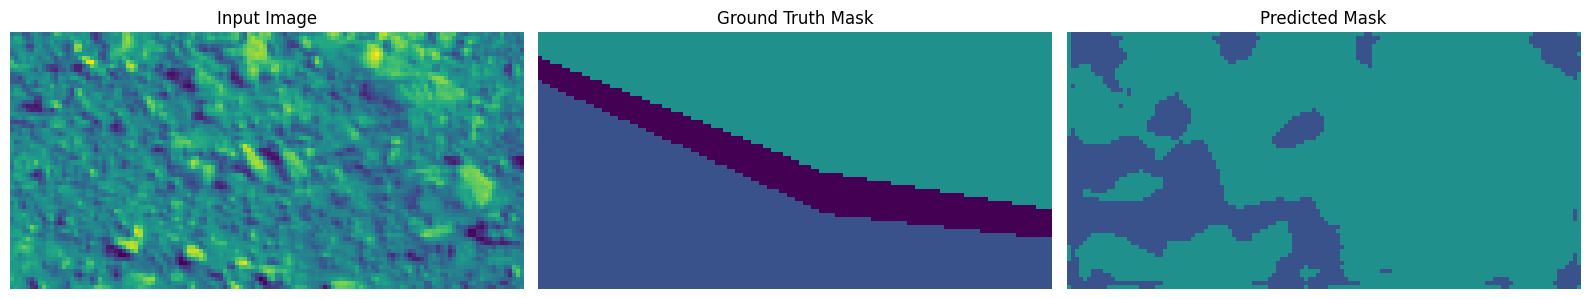

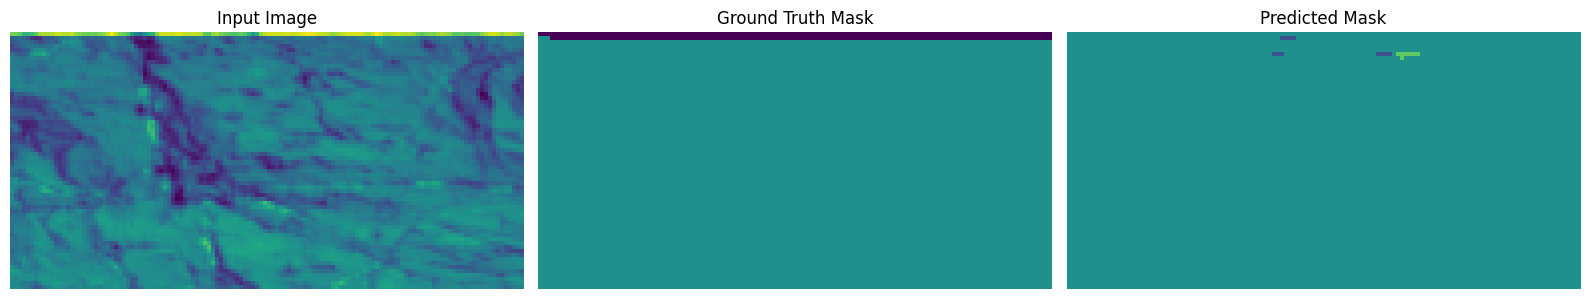

73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 100ms/step - accuracy: 0.6416 - loss: 0.1754 - mean_iou: 0.5625 - val_accuracy: 0.5534 - val_loss: 0.2820 - val_mean_iou: 0.4519 - learning_rate: 2.5000e-04
Epoch 90/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - accuracy: 0.6374 - loss: 0.1720 - mean_iou: 0.5570 - val_accuracy: 0.6228 - val_loss: 0.2362 - val_mean_iou: 0.5192 - learning_rate: 2.5000e-04
Epoch 91/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 92ms/step - accuracy: 0.6391 - loss: 0.1716 - mean_iou: 0.5592 - val_accuracy: 0.4220 - val_loss: 0.4085 - val_mean_iou: 0.3417 - learning_rate: 2.5000e-04
Epoch 92/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.6251 - loss: 0.1907 - mean_iou: 0.5346 - val_accuracy: 0.4872 - val_loss: 0.3821 - val_mean_iou: 0.4006 - learning_rate: 2.5000e-04
Epoch 93/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.6423 - loss: 0.1655 - mean_iou: 0.5635

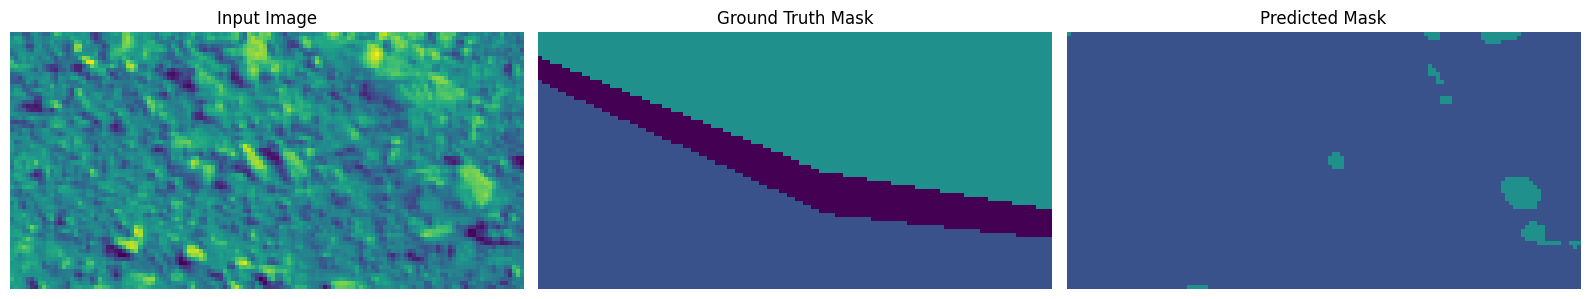

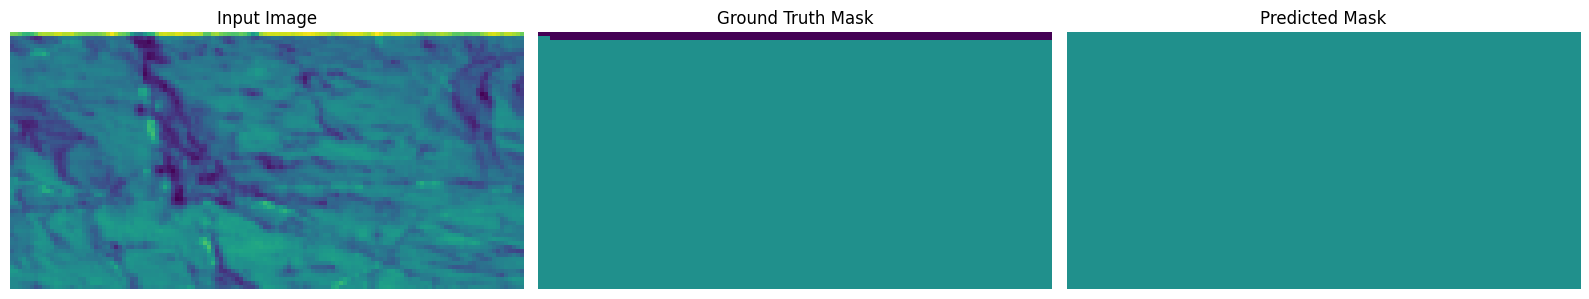

73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - accuracy: 0.6420 - loss: 0.1657 - mean_iou: 0.5633 - val_accuracy: 0.5813 - val_loss: 0.2916 - val_mean_iou: 0.4774 - learning_rate: 2.5000e-04
Epoch 94/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.6186 - loss: 0.1985 - mean_iou: 0.5274 - val_accuracy: 0.6445 - val_loss: 0.2439 - val_mean_iou: 0.5407 - learning_rate: 2.5000e-04
Epoch 95/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.6415 - loss: 0.1633 - mean_iou: 0.5609 - val_accuracy: 0.5822 - val_loss: 0.2669 - val_mean_iou: 0.4356 - learning_rate: 1.2500e-04
Epoch 96/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.6452 - loss: 0.1597 - mean_iou: 0.5677 - val_accuracy: 0.6678 - val_loss: 0.2280 - val_mean_iou: 0.5814 - learning_rate: 1.2500e-04
Epoch 97/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.6475 - loss: 0.1534 - mean_iou: 0.5743

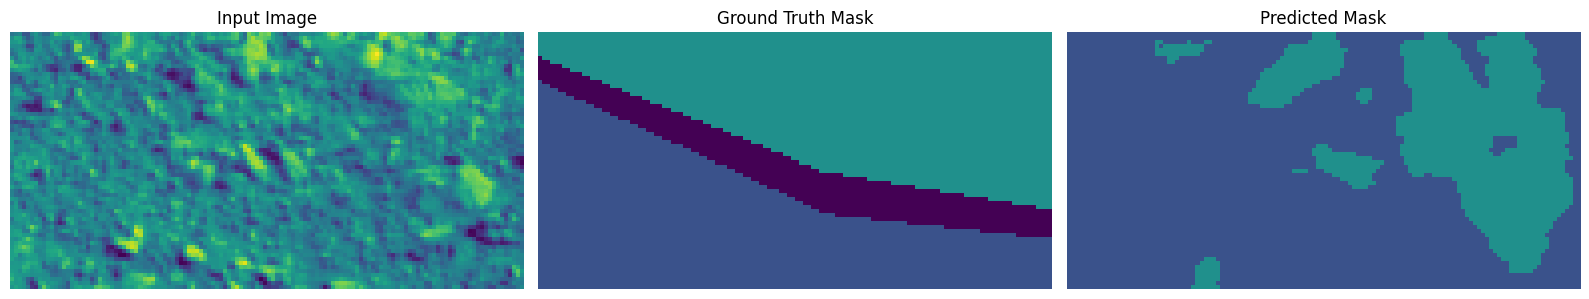

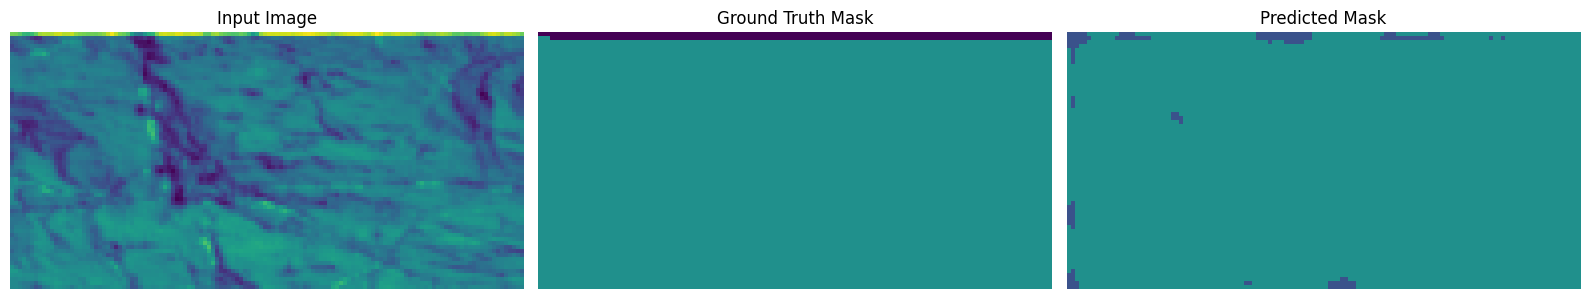

73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - accuracy: 0.6474 - loss: 0.1534 - mean_iou: 0.5741 - val_accuracy: 0.5936 - val_loss: 0.2596 - val_mean_iou: 0.4900 - learning_rate: 1.2500e-04
Epoch 98/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - accuracy: 0.6540 - loss: 0.1452 - mean_iou: 0.5850 - val_accuracy: 0.5922 - val_loss: 0.2774 - val_mean_iou: 0.4804 - learning_rate: 1.2500e-04
Epoch 99/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - accuracy: 0.6531 - loss: 0.1445 - mean_iou: 0.5822 - val_accuracy: 0.6494 - val_loss: 0.2353 - val_mean_iou: 0.5626 - learning_rate: 1.2500e-04
Epoch 100/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.6533 - loss: 0.1403 - mean_iou: 0.5840 - val_accuracy: 0.5487 - val_loss: 0.2666 - val_mean_iou: 0.4424 - learning_rate: 1.2500e-04
Epoch 101/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.6548 - loss: 0.1431 - mean_iou: 0.5829

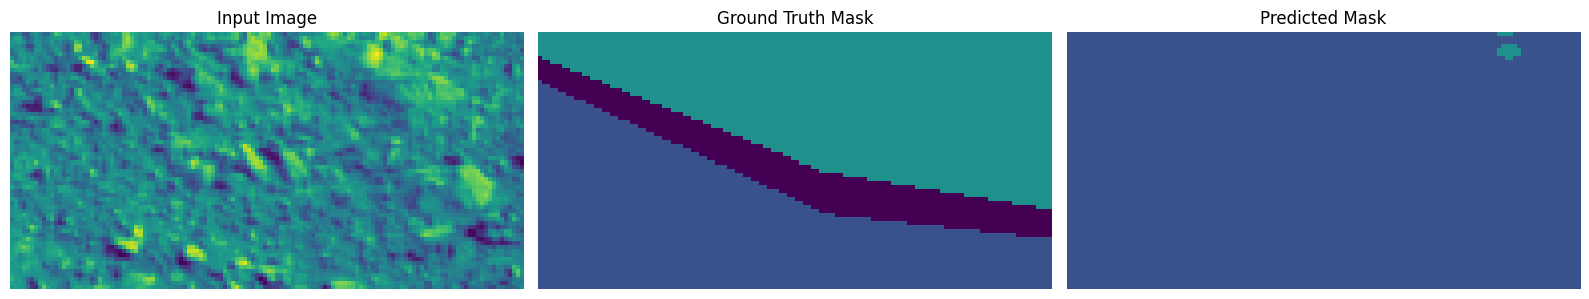

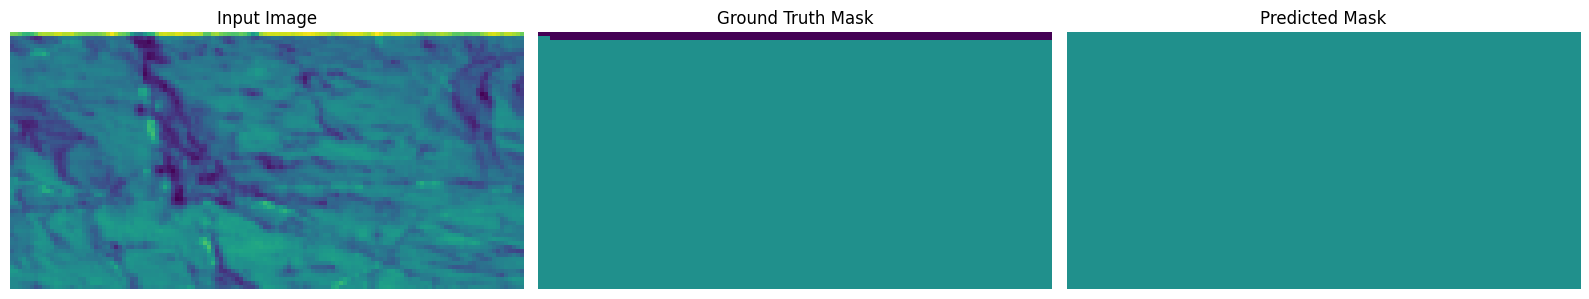

73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - accuracy: 0.6547 - loss: 0.1431 - mean_iou: 0.5828 - val_accuracy: 0.6474 - val_loss: 0.2108 - val_mean_iou: 0.5653 - learning_rate: 1.2500e-04
Epoch 102/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - accuracy: 0.6568 - loss: 0.1375 - mean_iou: 0.5906 - val_accuracy: 0.5895 - val_loss: 0.2320 - val_mean_iou: 0.4967 - learning_rate: 1.2500e-04
Epoch 103/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - accuracy: 0.6563 - loss: 0.1372 - mean_iou: 0.5894 - val_accuracy: 0.5884 - val_loss: 0.2435 - val_mean_iou: 0.4947 - learning_rate: 1.2500e-04
Epoch 104/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - accuracy: 0.6524 - loss: 0.1495 - mean_iou: 0.5804 - val_accuracy: 0.6283 - val_loss: 0.2486 - val_mean_iou: 0.5332 - learning_rate: 1.2500e-04
Epoch 105/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.6408 - loss: 0.1609 - mean_iou: 0.5610

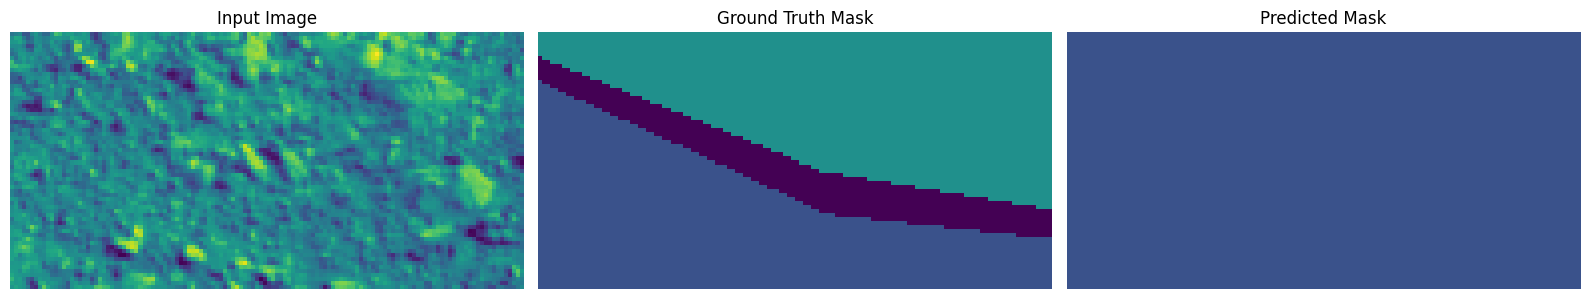

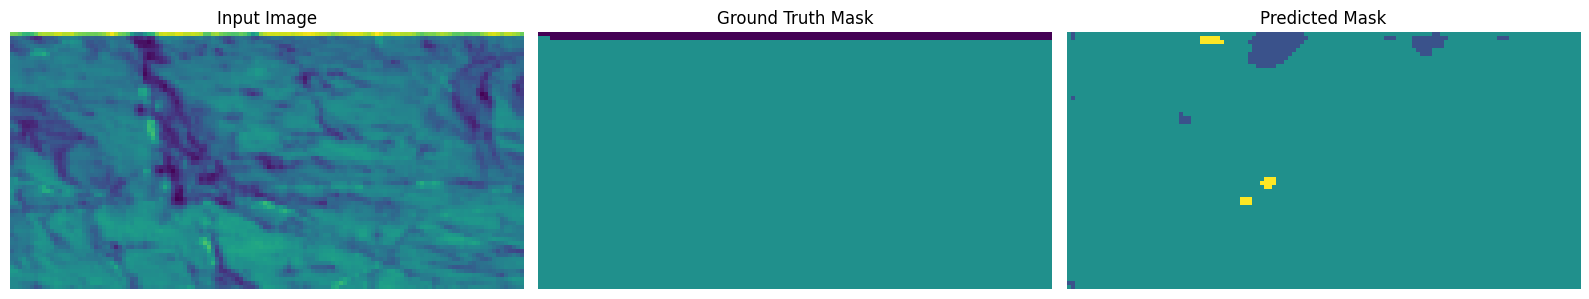

73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - accuracy: 0.6407 - loss: 0.1609 - mean_iou: 0.5610 - val_accuracy: 0.6550 - val_loss: 0.1888 - val_mean_iou: 0.5687 - learning_rate: 1.2500e-04
Epoch 106/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - accuracy: 0.6496 - loss: 0.1460 - mean_iou: 0.5788 - val_accuracy: 0.4737 - val_loss: 0.3641 - val_mean_iou: 0.3729 - learning_rate: 1.2500e-04
Epoch 107/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.6631 - loss: 0.1331 - mean_iou: 0.6029 - val_accuracy: 0.6628 - val_loss: 0.1923 - val_mean_iou: 0.5944 - learning_rate: 6.2500e-05
Epoch 108/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.6673 - loss: 0.1235 - mean_iou: 0.6125 - val_accuracy: 0.6869 - val_loss: 0.1953 - val_mean_iou: 0.6285 - learning_rate: 6.2500e-05
Epoch 109/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.6666 - loss: 0.1238 - mean_iou: 0.6100

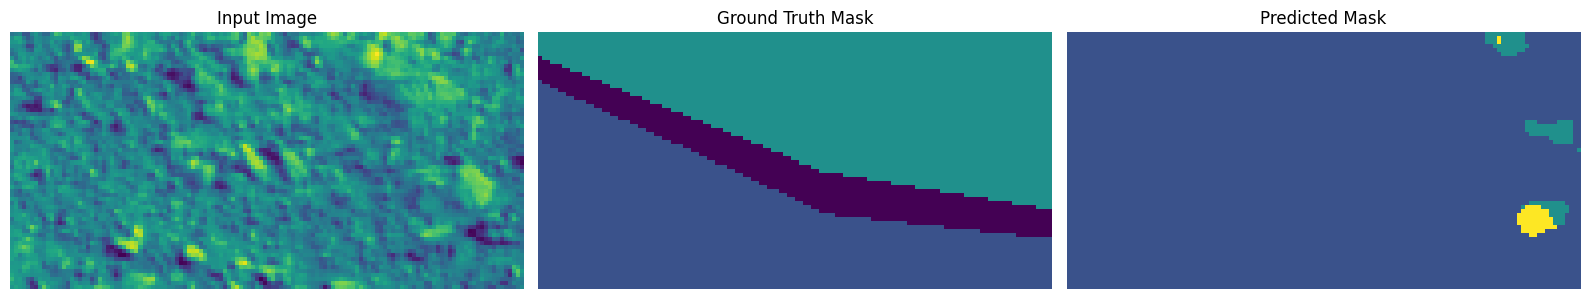

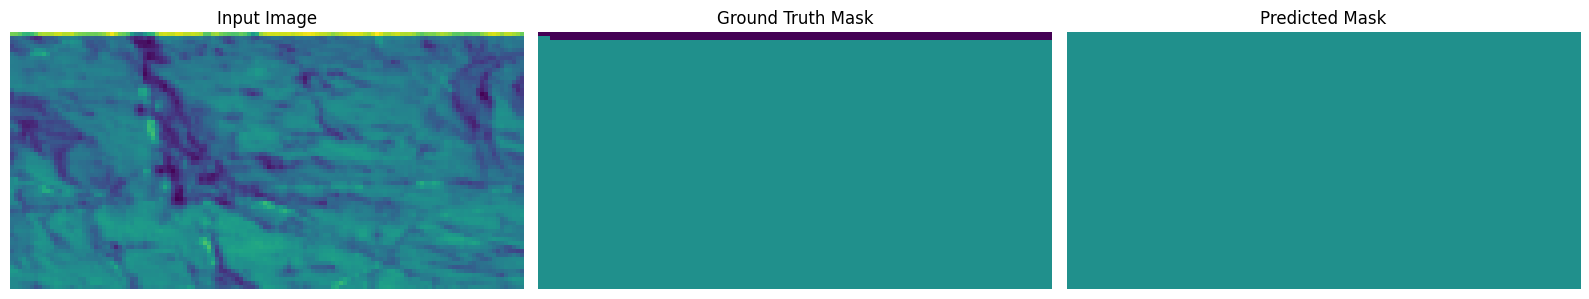

73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step - accuracy: 0.6663 - loss: 0.1239 - mean_iou: 0.6096 - val_accuracy: 0.6040 - val_loss: 0.2379 - val_mean_iou: 0.4945 - learning_rate: 6.2500e-05
Epoch 110/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - accuracy: 0.6633 - loss: 0.1269 - mean_iou: 0.6039 - val_accuracy: 0.6876 - val_loss: 0.1780 - val_mean_iou: 0.6366 - learning_rate: 6.2500e-05
Epoch 111/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - accuracy: 0.6702 - loss: 0.1172 - mean_iou: 0.6166 - val_accuracy: 0.6884 - val_loss: 0.2080 - val_mean_iou: 0.6160 - learning_rate: 6.2500e-05
Epoch 112/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.6717 - loss: 0.1142 - mean_iou: 0.6198 - val_accuracy: 0.6813 - val_loss: 0.1782 - val_mean_iou: 0.6292 - learning_rate: 6.2500e-05
Epoch 113/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.6728 - loss: 0.1109 - mean_iou: 0.6220

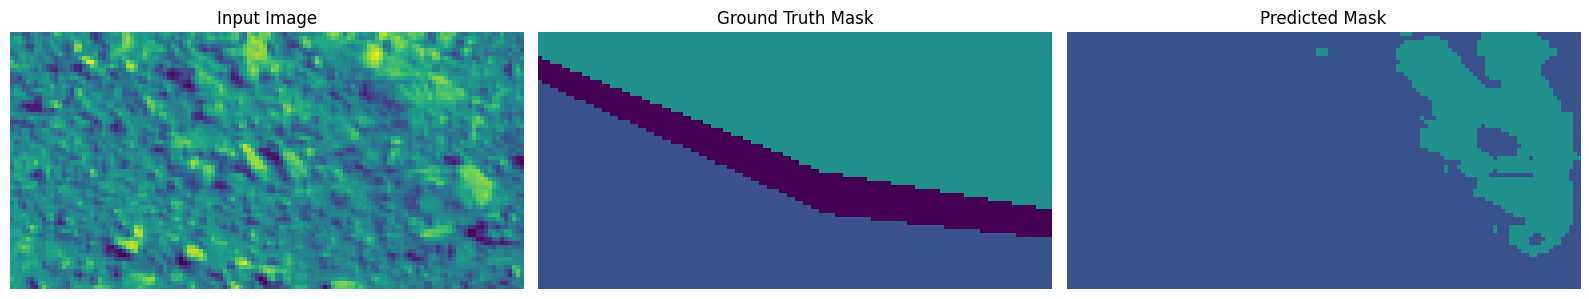

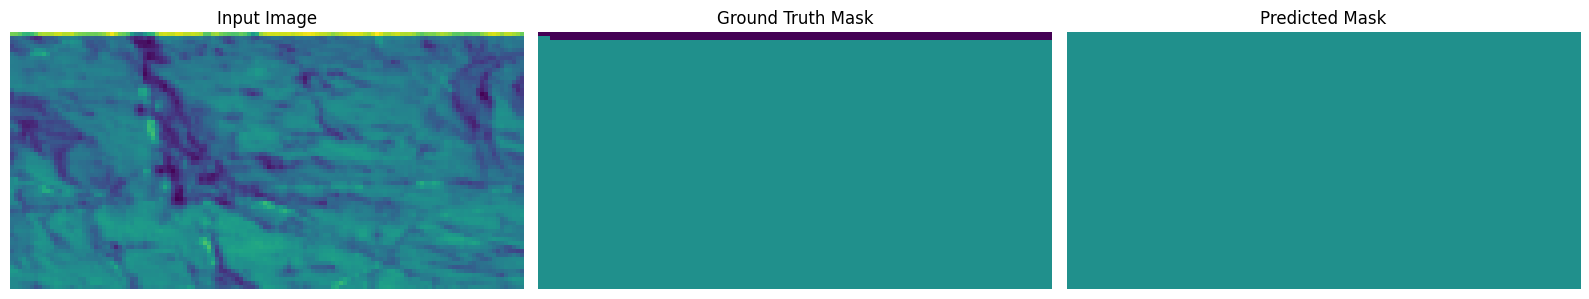

73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 96ms/step - accuracy: 0.6726 - loss: 0.1109 - mean_iou: 0.6219 - val_accuracy: 0.6711 - val_loss: 0.1743 - val_mean_iou: 0.6090 - learning_rate: 6.2500e-05
Epoch 114/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.6715 - loss: 0.1119 - mean_iou: 0.6206 - val_accuracy: 0.6676 - val_loss: 0.1873 - val_mean_iou: 0.5926 - learning_rate: 6.2500e-05
Epoch 115/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - accuracy: 0.6716 - loss: 0.1116 - mean_iou: 0.6211 - val_accuracy: 0.6551 - val_loss: 0.1902 - val_mean_iou: 0.5714 - learning_rate: 6.2500e-05
Epoch 116/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - accuracy: 0.6638 - loss: 0.1186 - mean_iou: 0.6052 - val_accuracy: 0.6312 - val_loss: 0.2299 - val_mean_iou: 0.5416 - learning_rate: 6.2500e-05
Epoch 117/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.6742 - loss: 0.1099 - mean_iou: 0.6251

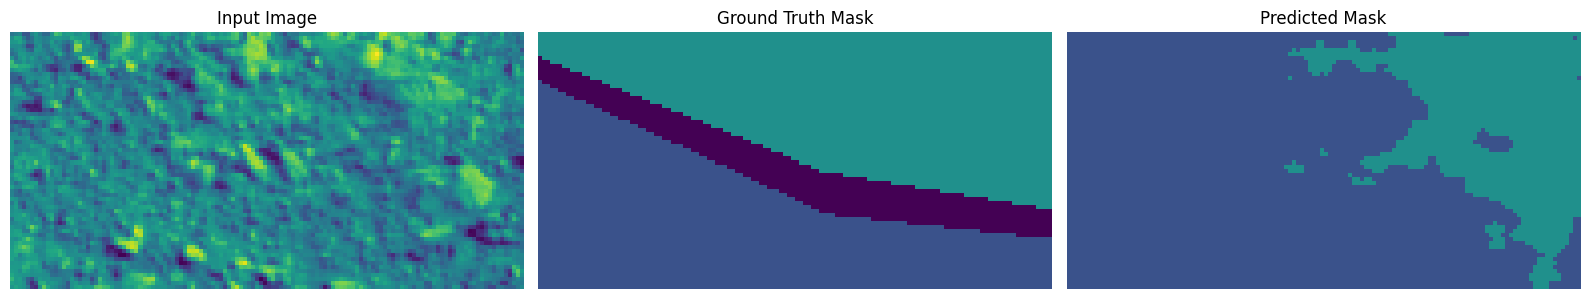

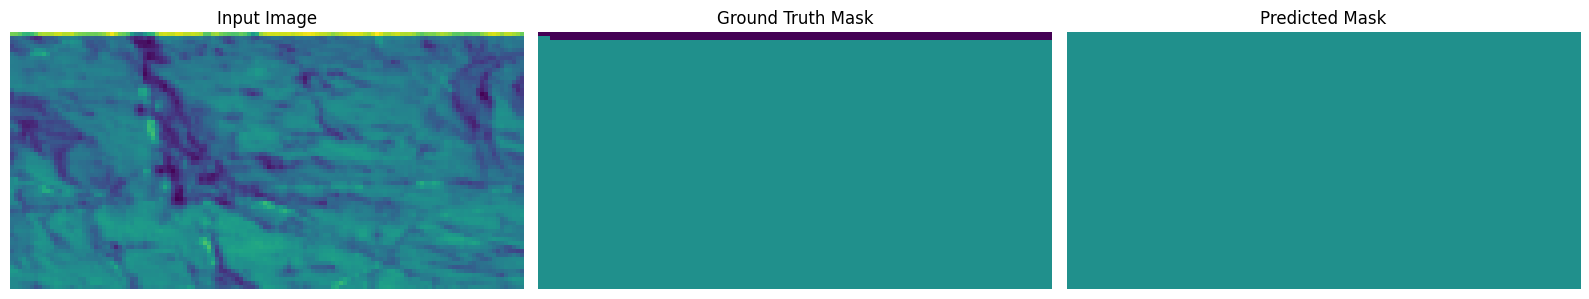

73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - accuracy: 0.6741 - loss: 0.1099 - mean_iou: 0.6250 - val_accuracy: 0.6954 - val_loss: 0.1778 - val_mean_iou: 0.6544 - learning_rate: 6.2500e-05
Epoch 118/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy: 0.6744 - loss: 0.1059 - mean_iou: 0.6277 - val_accuracy: 0.6776 - val_loss: 0.1926 - val_mean_iou: 0.6250 - learning_rate: 6.2500e-05
Epoch 119/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.6766 - loss: 0.1031 - mean_iou: 0.6310 - val_accuracy: 0.6869 - val_loss: 0.1555 - val_mean_iou: 0.6315 - learning_rate: 6.2500e-05
Epoch 120/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.6663 - loss: 0.1090 - mean_iou: 0.6144 - val_accuracy: 0.6881 - val_loss: 0.1872 - val_mean_iou: 0.6300 - learning_rate: 6.2500e-05
Epoch 121/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.6714 - loss: 0.1105 - mean_iou: 0.6227

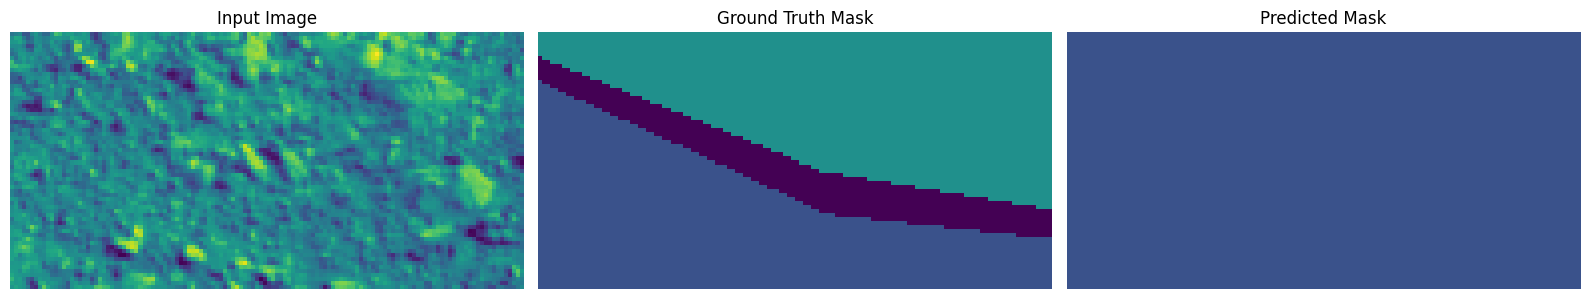

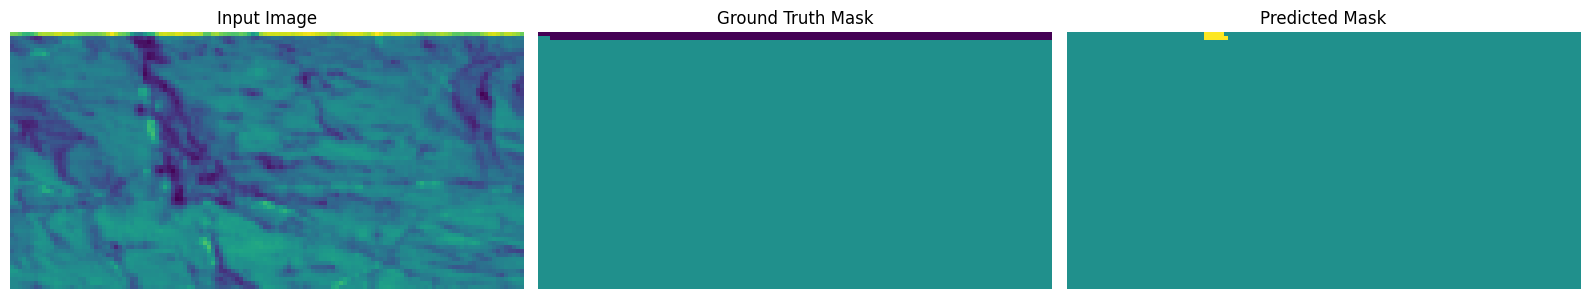

73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - accuracy: 0.6712 - loss: 0.1106 - mean_iou: 0.6224 - val_accuracy: 0.5838 - val_loss: 0.2719 - val_mean_iou: 0.4719 - learning_rate: 6.2500e-05
Epoch 122/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - accuracy: 0.6654 - loss: 0.1158 - mean_iou: 0.6082 - val_accuracy: 0.6717 - val_loss: 0.1856 - val_mean_iou: 0.5903 - learning_rate: 6.2500e-05
Epoch 123/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - accuracy: 0.6763 - loss: 0.1043 - mean_iou: 0.6322 - val_accuracy: 0.7012 - val_loss: 0.1852 - val_mean_iou: 0.6506 - learning_rate: 6.2500e-05
Epoch 124/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - accuracy: 0.6737 - loss: 0.1044 - mean_iou: 0.6271 - val_accuracy: 0.6736 - val_loss: 0.2016 - val_mean_iou: 0.5945 - learning_rate: 6.2500e-05
Epoch 125/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.6766 - loss: 0.1009 - mean_iou: 0.6346

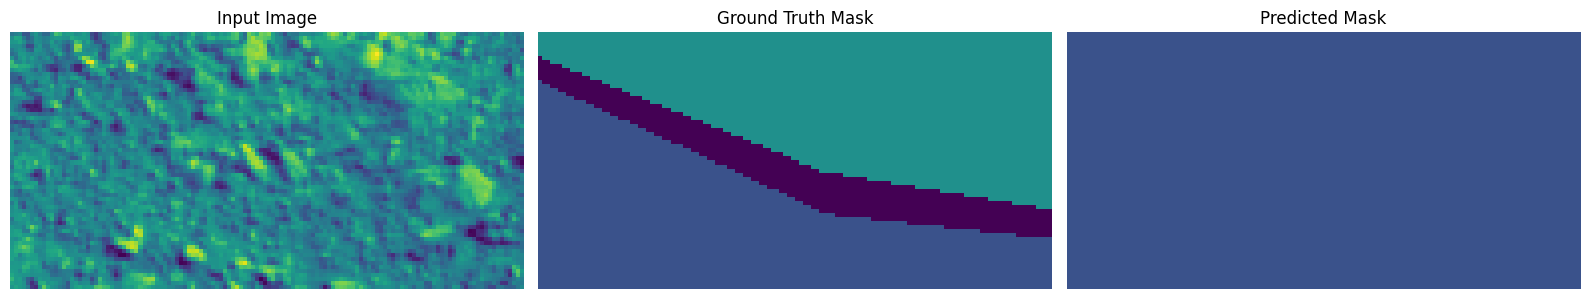

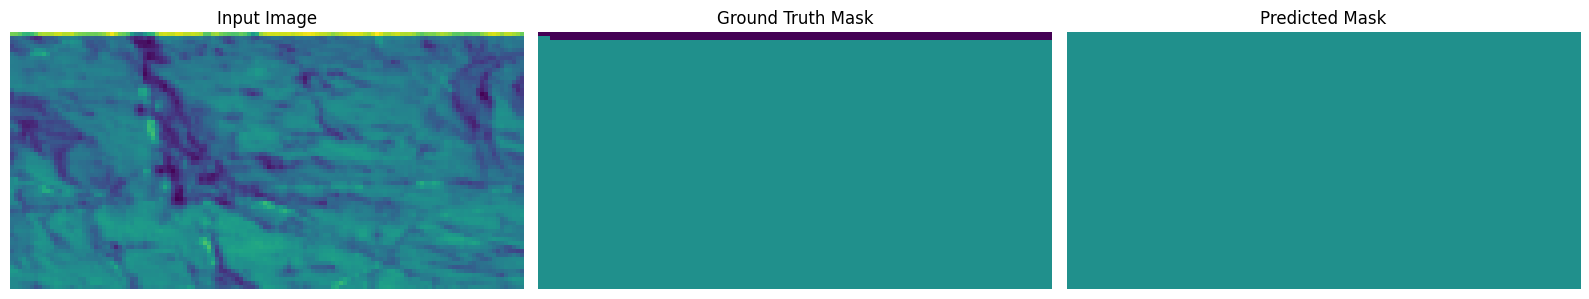

73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step - accuracy: 0.6765 - loss: 0.1010 - mean_iou: 0.6345 - val_accuracy: 0.7037 - val_loss: 0.1922 - val_mean_iou: 0.6602 - learning_rate: 6.2500e-05
Epoch 126/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.6728 - loss: 0.1029 - mean_iou: 0.6271 - val_accuracy: 0.6882 - val_loss: 0.1777 - val_mean_iou: 0.6320 - learning_rate: 6.2500e-05
Epoch 127/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - accuracy: 0.6770 - loss: 0.0997 - mean_iou: 0.6347 - val_accuracy: 0.7065 - val_loss: 0.1674 - val_mean_iou: 0.6576 - learning_rate: 6.2500e-05
Epoch 128/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.6787 - loss: 0.0983 - mean_iou: 0.6373 - val_accuracy: 0.6878 - val_loss: 0.1996 - val_mean_iou: 0.6279 - learning_rate: 6.2500e-05
Epoch 129/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.6800 - loss: 0.0956 - mean_iou: 0.6411

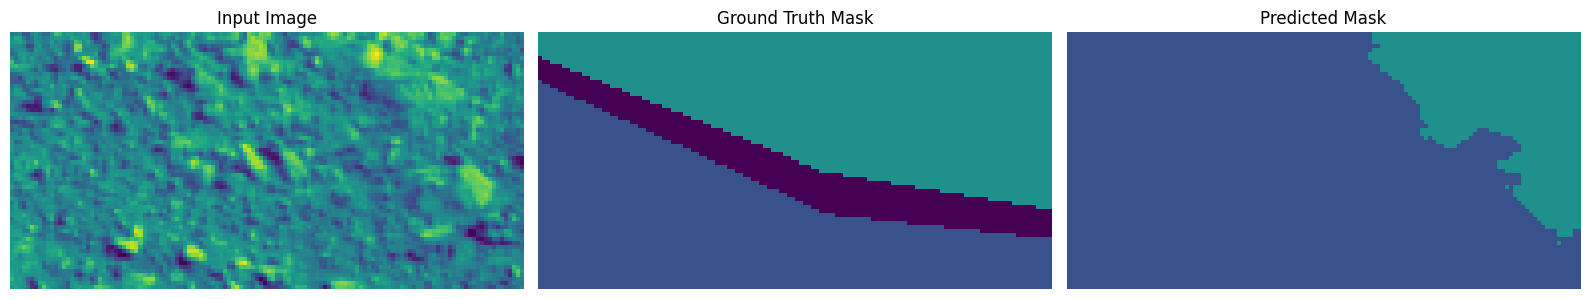

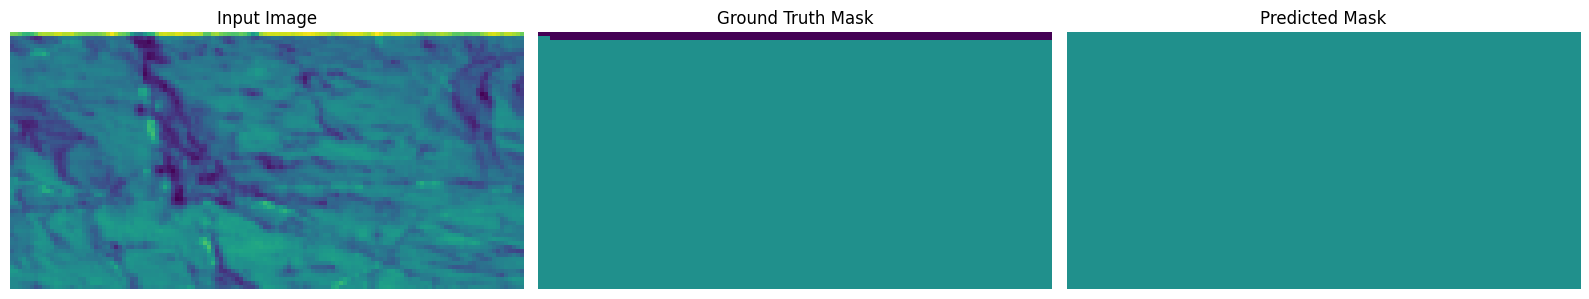

73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 0.6799 - loss: 0.0956 - mean_iou: 0.6411 - val_accuracy: 0.7030 - val_loss: 0.1657 - val_mean_iou: 0.6626 - learning_rate: 6.2500e-05
Epoch 130/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.6810 - loss: 0.0953 - mean_iou: 0.6414 - val_accuracy: 0.6997 - val_loss: 0.1764 - val_mean_iou: 0.6650 - learning_rate: 6.2500e-05
Epoch 131/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - accuracy: 0.6751 - loss: 0.0980 - mean_iou: 0.6337 - val_accuracy: 0.6856 - val_loss: 0.1993 - val_mean_iou: 0.6477 - learning_rate: 6.2500e-05
Epoch 132/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.6560 - loss: 0.1178 - mean_iou: 0.5938 - val_accuracy: 0.4880 - val_loss: 0.5769 - val_mean_iou: 0.3609 - learning_rate: 6.2500e-05
Epoch 133/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.6742 - loss: 0.1109 - mean_iou: 0.6231

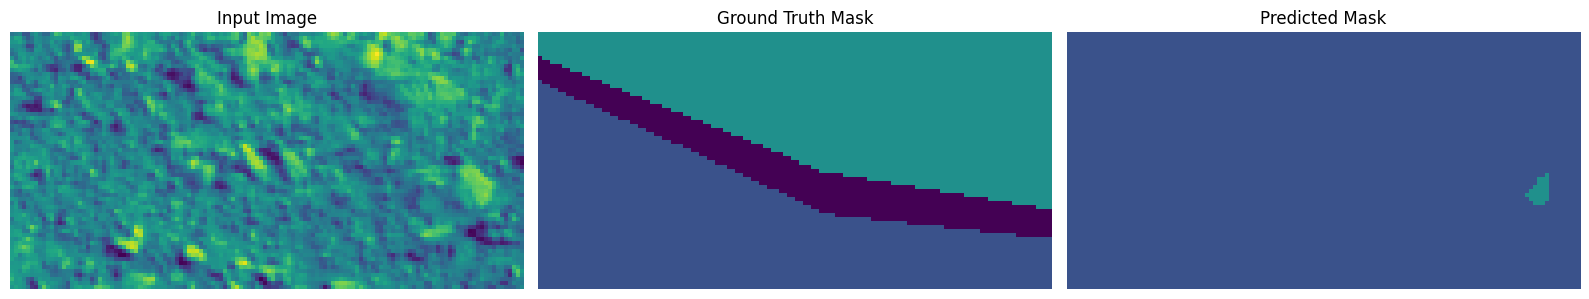

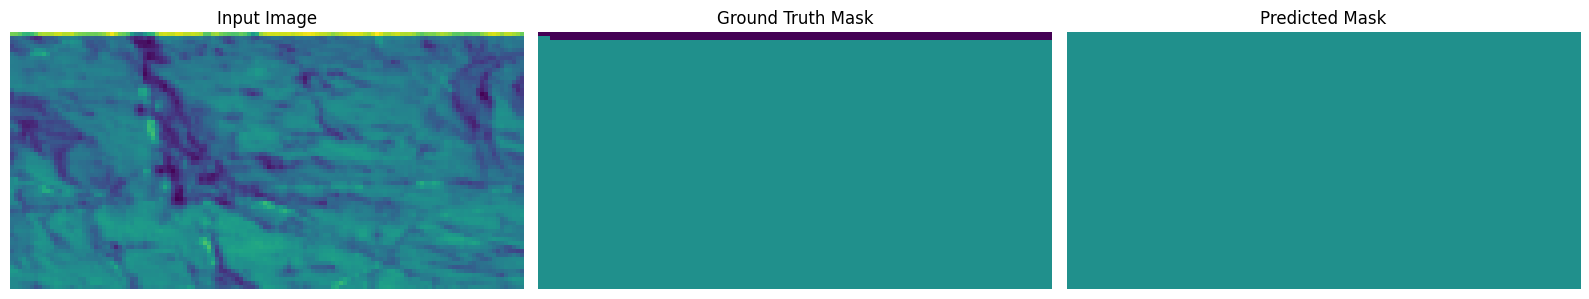

73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 98ms/step - accuracy: 0.6742 - loss: 0.1109 - mean_iou: 0.6231 - val_accuracy: 0.6576 - val_loss: 0.1828 - val_mean_iou: 0.5926 - learning_rate: 6.2500e-05
Epoch 134/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.6755 - loss: 0.1001 - mean_iou: 0.6344 - val_accuracy: 0.7101 - val_loss: 0.1779 - val_mean_iou: 0.6816 - learning_rate: 6.2500e-05
Epoch 135/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.6815 - loss: 0.0926 - mean_iou: 0.6494 - val_accuracy: 0.7039 - val_loss: 0.1912 - val_mean_iou: 0.6461 - learning_rate: 6.2500e-05
Epoch 136/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 0.6820 - loss: 0.0905 - mean_iou: 0.6498 - val_accuracy: 0.7002 - val_loss: 0.2092 - val_mean_iou: 0.6390 - learning_rate: 6.2500e-05
Epoch 137/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.6791 - loss: 0.0937 - mean_iou: 0.6418

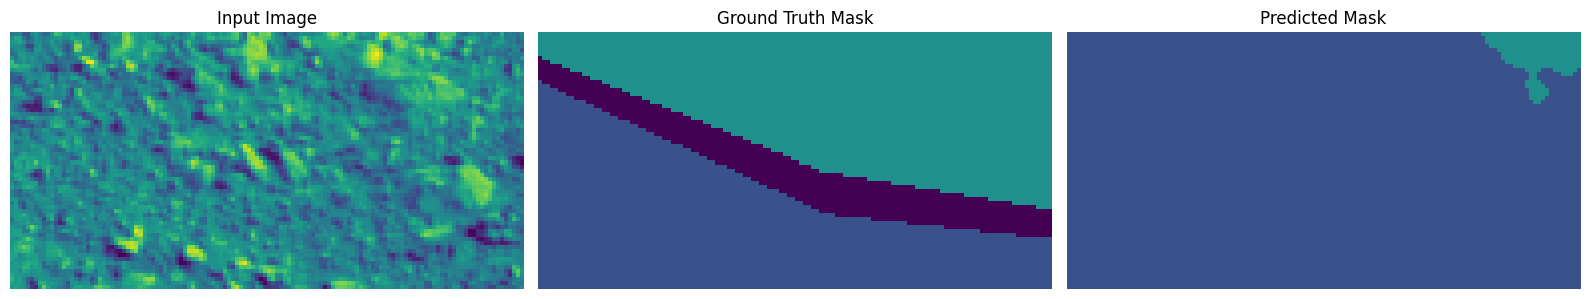

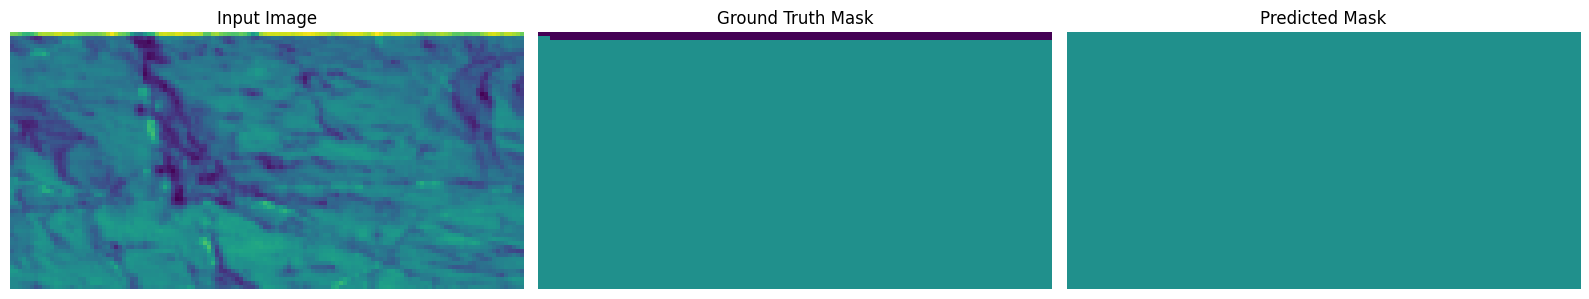

73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 98ms/step - accuracy: 0.6789 - loss: 0.0937 - mean_iou: 0.6417 - val_accuracy: 0.7145 - val_loss: 0.1596 - val_mean_iou: 0.6816 - learning_rate: 6.2500e-05
Epoch 138/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.6836 - loss: 0.0887 - mean_iou: 0.6543 - val_accuracy: 0.6911 - val_loss: 0.1968 - val_mean_iou: 0.6679 - learning_rate: 6.2500e-05
Epoch 139/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.6872 - loss: 0.0850 - mean_iou: 0.6626 - val_accuracy: 0.6772 - val_loss: 0.2328 - val_mean_iou: 0.6090 - learning_rate: 6.2500e-05
Epoch 140/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.6843 - loss: 0.0881 - mean_iou: 0.6535 - val_accuracy: 0.6865 - val_loss: 0.1803 - val_mean_iou: 0.6488 - learning_rate: 6.2500e-05
Epoch 141/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.6807 - loss: 0.0914 - mean_iou: 0.6434

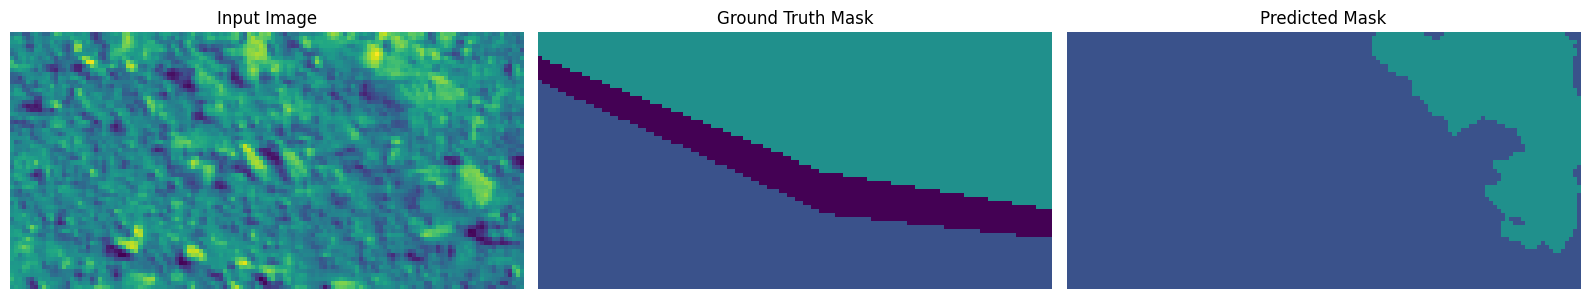

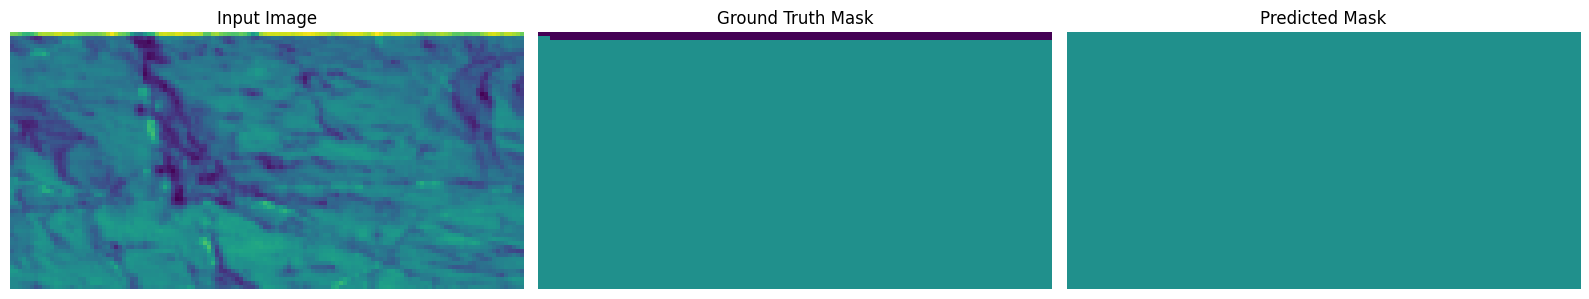

73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 96ms/step - accuracy: 0.6806 - loss: 0.0914 - mean_iou: 0.6433 - val_accuracy: 0.6826 - val_loss: 0.2034 - val_mean_iou: 0.6217 - learning_rate: 6.2500e-05
Epoch 142/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.6732 - loss: 0.0990 - mean_iou: 0.6278 - val_accuracy: 0.6751 - val_loss: 0.1875 - val_mean_iou: 0.6084 - learning_rate: 6.2500e-05
Epoch 143/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - accuracy: 0.6762 - loss: 0.1060 - mean_iou: 0.6217 - val_accuracy: 0.6566 - val_loss: 0.1967 - val_mean_iou: 0.5506 - learning_rate: 6.2500e-05
Epoch 144/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - accuracy: 0.6798 - loss: 0.0936 - mean_iou: 0.6499 - val_accuracy: 0.7001 - val_loss: 0.1838 - val_mean_iou: 0.6368 - learning_rate: 6.2500e-05
Epoch 145/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.6856 - loss: 0.0912 - mean_iou: 0.6590

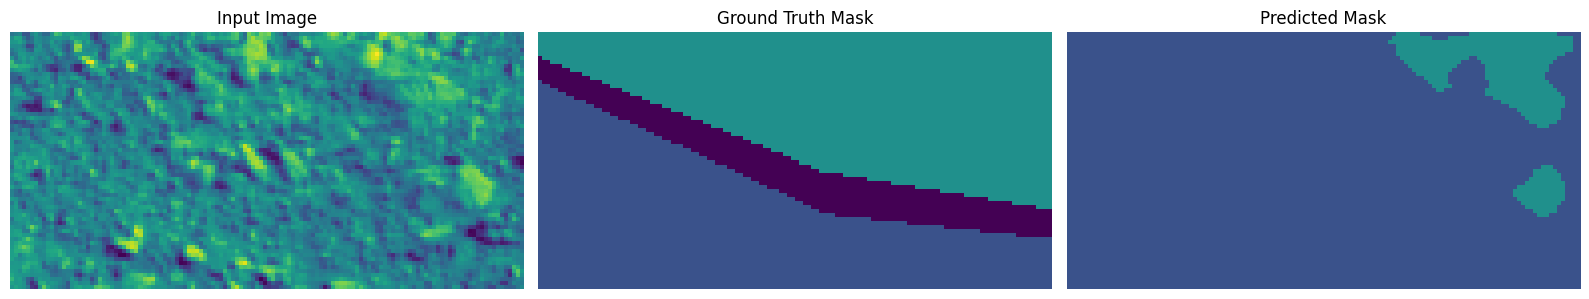

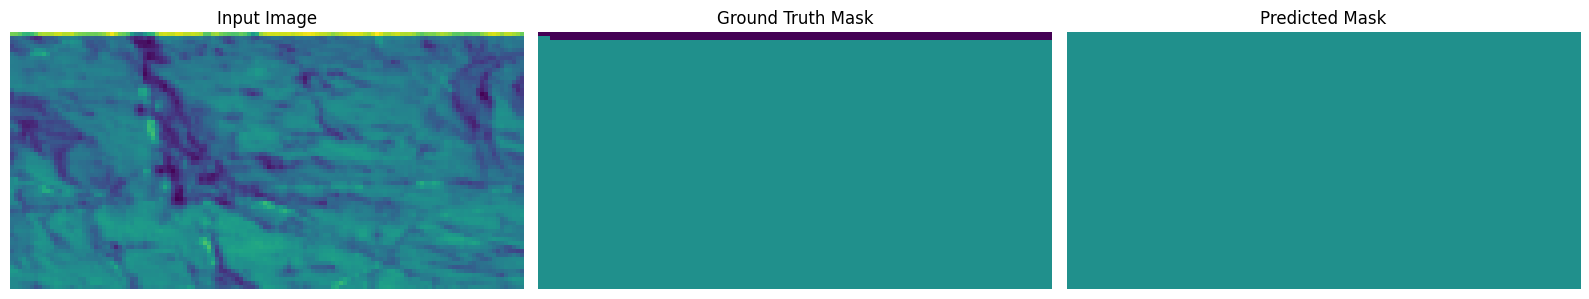

73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 98ms/step - accuracy: 0.6855 - loss: 0.0912 - mean_iou: 0.6590 - val_accuracy: 0.7067 - val_loss: 0.1757 - val_mean_iou: 0.6680 - learning_rate: 3.1250e-05
Epoch 146/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - accuracy: 0.6926 - loss: 0.0822 - mean_iou: 0.6793 - val_accuracy: 0.7086 - val_loss: 0.1798 - val_mean_iou: 0.6685 - learning_rate: 3.1250e-05
Epoch 147/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.6952 - loss: 0.0786 - mean_iou: 0.6937 - val_accuracy: 0.7009 - val_loss: 0.2099 - val_mean_iou: 0.6464 - learning_rate: 3.1250e-05
Epoch 148/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - accuracy: 0.6985 - loss: 0.0753 - mean_iou: 0.7040 - val_accuracy: 0.6986 - val_loss: 0.2158 - val_mean_iou: 0.6443 - learning_rate: 3.1250e-05
Epoch 149/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.6986 - loss: 0.0741 - mean_iou: 0.7033

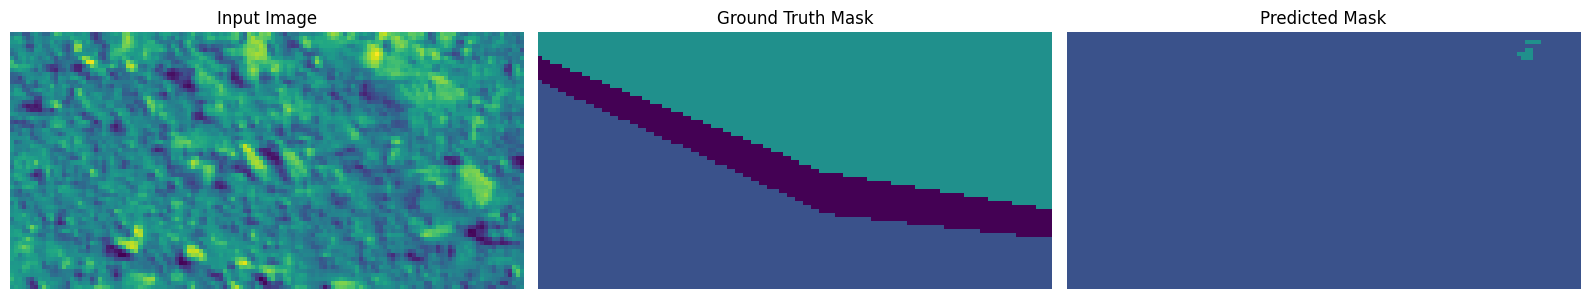

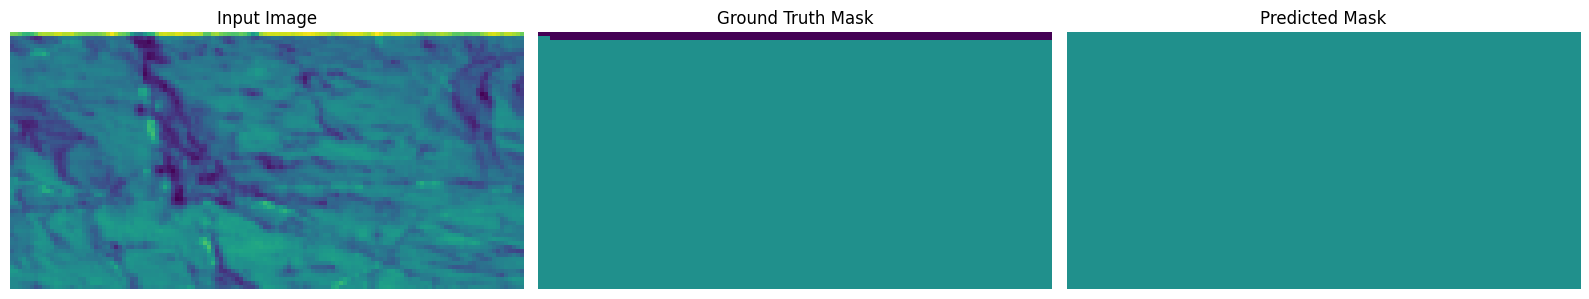

73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - accuracy: 0.6985 - loss: 0.0741 - mean_iou: 0.7032 - val_accuracy: 0.6975 - val_loss: 0.2230 - val_mean_iou: 0.6415 - learning_rate: 3.1250e-05
Epoch 150/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.6998 - loss: 0.0726 - mean_iou: 0.7132 - val_accuracy: 0.7035 - val_loss: 0.2172 - val_mean_iou: 0.6659 - learning_rate: 3.1250e-05
Epoch 151/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.7025 - loss: 0.0701 - mean_iou: 0.7238 - val_accuracy: 0.7109 - val_loss: 0.2148 - val_mean_iou: 0.6842 - learning_rate: 3.1250e-05
Epoch 152/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - accuracy: 0.7017 - loss: 0.0703 - mean_iou: 0.7155 - val_accuracy: 0.7006 - val_loss: 0.2409 - val_mean_iou: 0.6633 - learning_rate: 3.1250e-05
Epoch 153/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.7029 - loss: 0.0694 - mean_iou: 0.7194

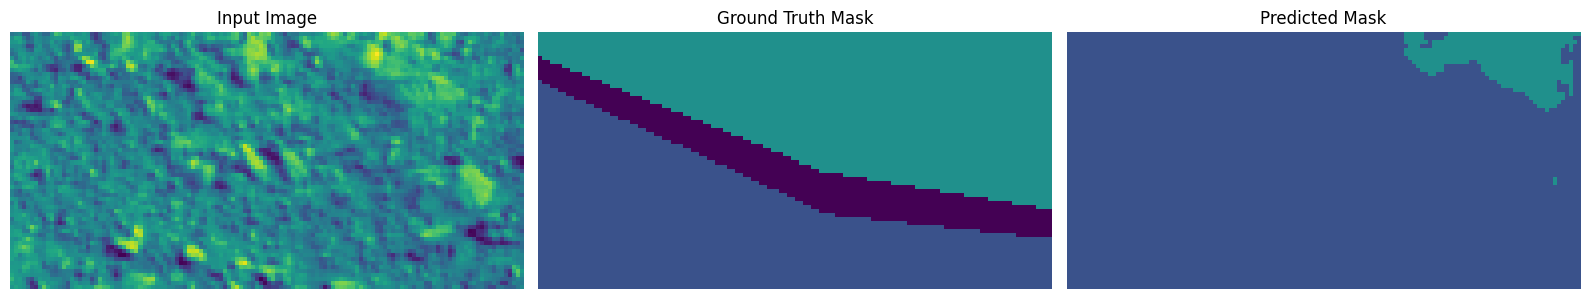

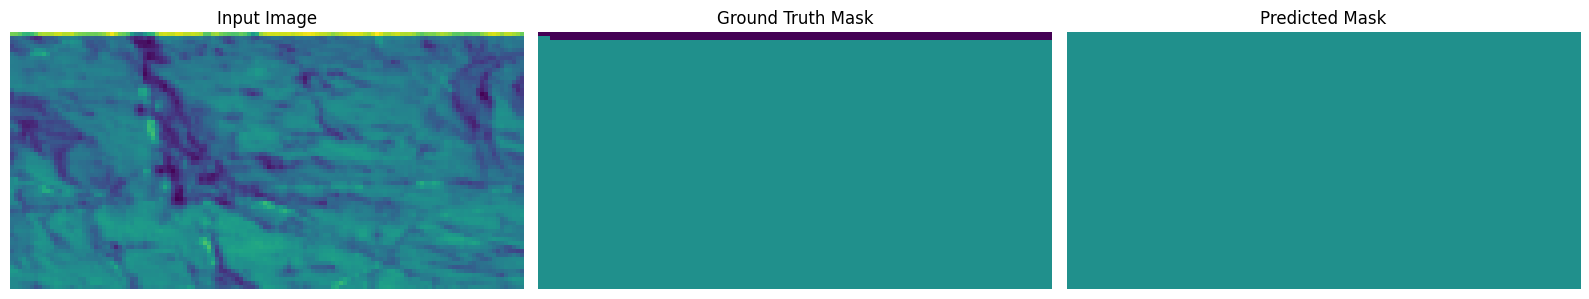

73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - accuracy: 0.7028 - loss: 0.0694 - mean_iou: 0.7193 - val_accuracy: 0.6957 - val_loss: 0.2184 - val_mean_iou: 0.6667 - learning_rate: 3.1250e-05
Epoch 154/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.7011 - loss: 0.0707 - mean_iou: 0.7141 - val_accuracy: 0.6955 - val_loss: 0.2692 - val_mean_iou: 0.6314 - learning_rate: 3.1250e-05
Epoch 155/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.7034 - loss: 0.0697 - mean_iou: 0.7155 - val_accuracy: 0.7037 - val_loss: 0.2224 - val_mean_iou: 0.6625 - learning_rate: 3.1250e-05
Epoch 156/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.7022 - loss: 0.0698 - mean_iou: 0.7078 - val_accuracy: 0.7021 - val_loss: 0.2528 - val_mean_iou: 0.6416 - learning_rate: 3.1250e-05
Epoch 157/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.7034 - loss: 0.0689 - mean_iou: 0.7166

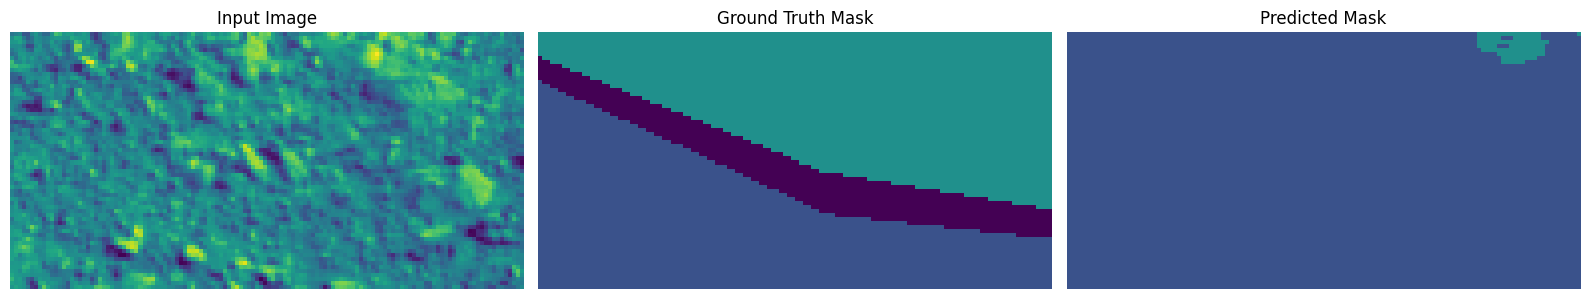

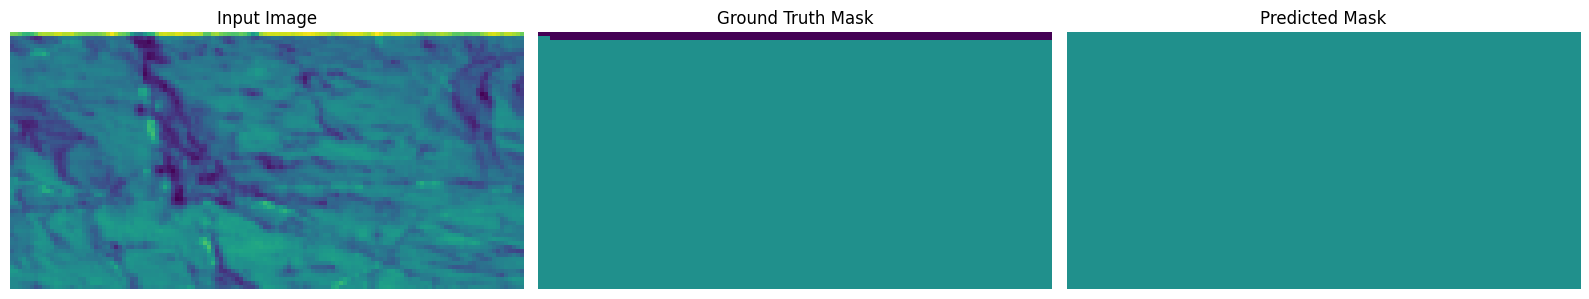

73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - accuracy: 0.7033 - loss: 0.0689 - mean_iou: 0.7165 - val_accuracy: 0.7039 - val_loss: 0.2548 - val_mean_iou: 0.6483 - learning_rate: 3.1250e-05
Epoch 158/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.7083 - loss: 0.0655 - mean_iou: 0.7418 - val_accuracy: 0.7044 - val_loss: 0.2627 - val_mean_iou: 0.6645 - learning_rate: 3.1250e-05
Epoch 159/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.7099 - loss: 0.0644 - mean_iou: 0.7442 - val_accuracy: 0.6924 - val_loss: 0.2729 - val_mean_iou: 0.6548 - learning_rate: 3.1250e-05
Epoch 160/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.7091 - loss: 0.0641 - mean_iou: 0.7420 - val_accuracy: 0.7008 - val_loss: 0.2608 - val_mean_iou: 0.6403 - learning_rate: 3.1250e-05
Epoch 161/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.7088 - loss: 0.0654 - mean_iou: 0.7293

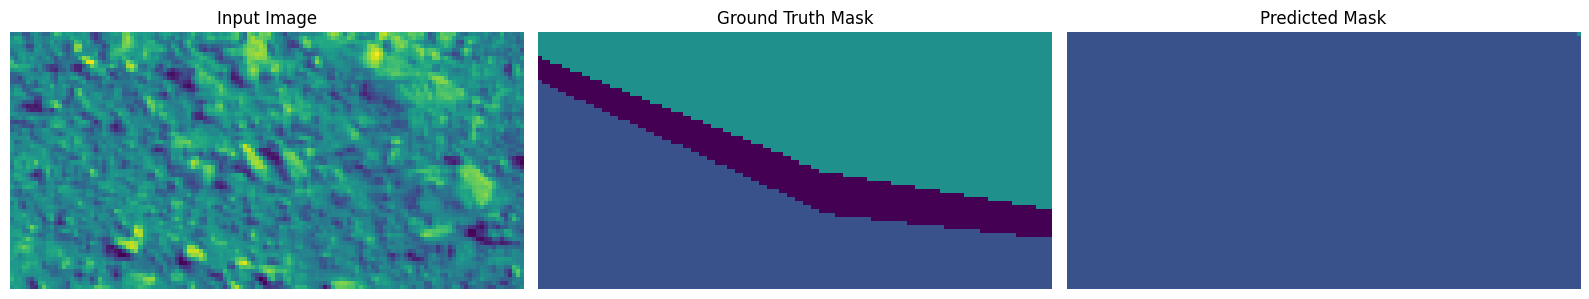

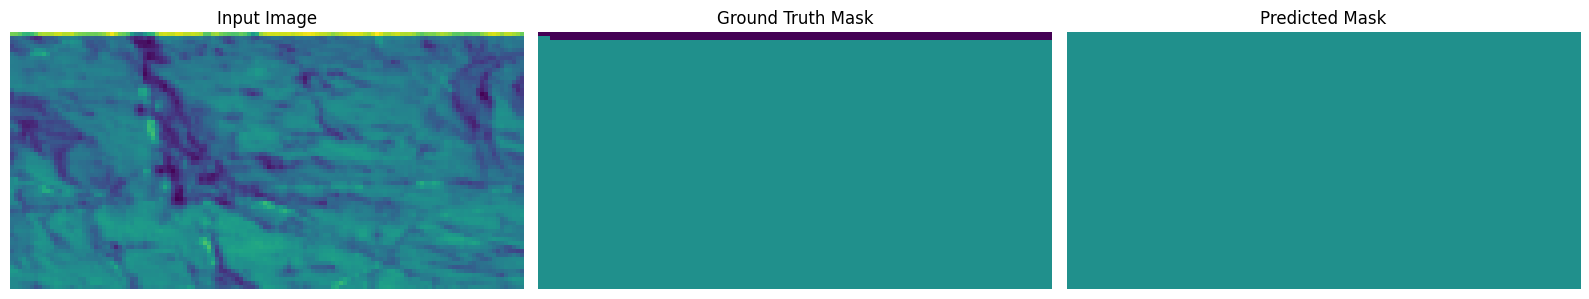

73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - accuracy: 0.7087 - loss: 0.0654 - mean_iou: 0.7293 - val_accuracy: 0.7132 - val_loss: 0.2290 - val_mean_iou: 0.6728 - learning_rate: 3.1250e-05
Epoch 162/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 0.7082 - loss: 0.0663 - mean_iou: 0.7233 - val_accuracy: 0.7141 - val_loss: 0.2201 - val_mean_iou: 0.6561 - learning_rate: 1.5625e-05
Epoch 163/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.7143 - loss: 0.0620 - mean_iou: 0.7489 - val_accuracy: 0.7082 - val_loss: 0.2310 - val_mean_iou: 0.6707 - learning_rate: 1.5625e-05
Epoch 164/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.7170 - loss: 0.0592 - mean_iou: 0.7767 - val_accuracy: 0.6977 - val_loss: 0.2518 - val_mean_iou: 0.6473 - learning_rate: 1.5625e-05
Epoch 165/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.7189 - loss: 0.0574 - mean_iou: 0.7877

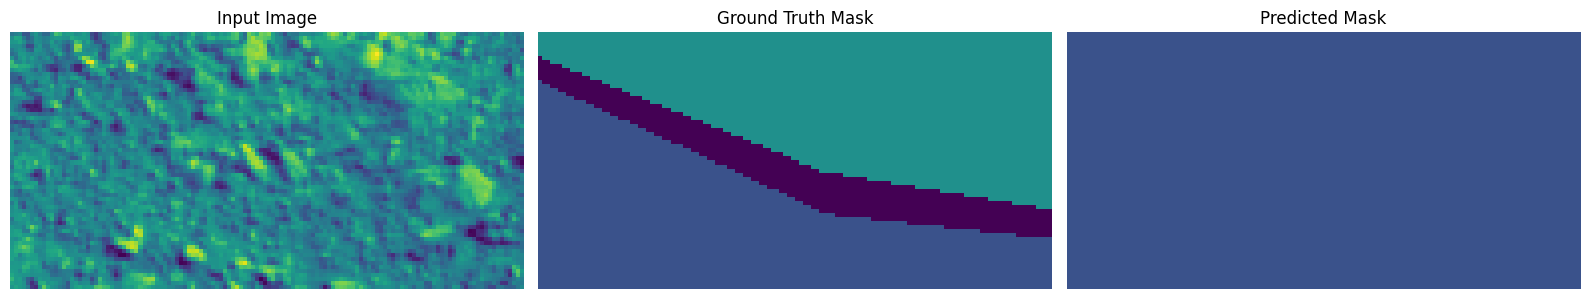

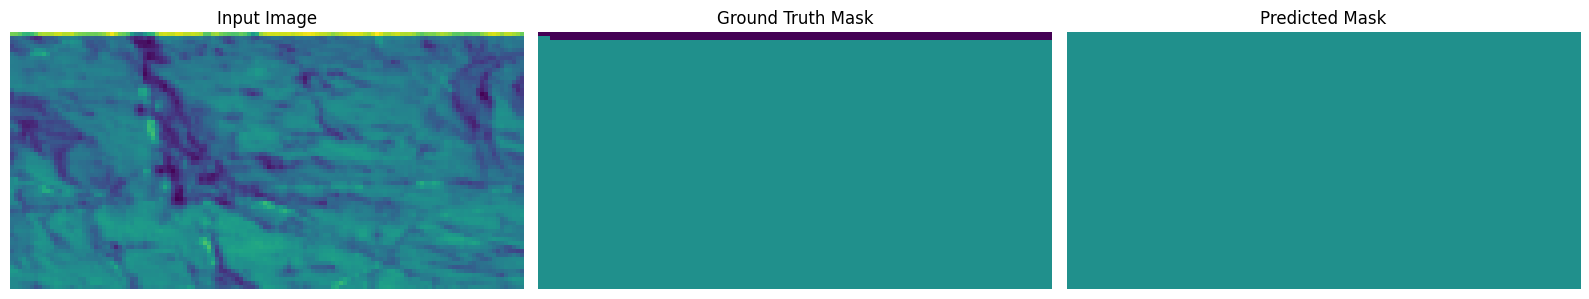

73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step - accuracy: 0.7188 - loss: 0.0574 - mean_iou: 0.7878 - val_accuracy: 0.6961 - val_loss: 0.2398 - val_mean_iou: 0.6585 - learning_rate: 1.5625e-05
Epoch 166/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 0.7209 - loss: 0.0556 - mean_iou: 0.7990 - val_accuracy: 0.6956 - val_loss: 0.2500 - val_mean_iou: 0.6537 - learning_rate: 1.5625e-05
Epoch 167/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.7230 - loss: 0.0541 - mean_iou: 0.8079 - val_accuracy: 0.6920 - val_loss: 0.2437 - val_mean_iou: 0.6614 - learning_rate: 1.5625e-05
Epoch 168/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.7250 - loss: 0.0529 - mean_iou: 0.8180 - val_accuracy: 0.6871 - val_loss: 0.2555 - val_mean_iou: 0.6547 - learning_rate: 1.5625e-05
Epoch 169/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.7266 - loss: 0.0518 - mean_iou: 0.8249

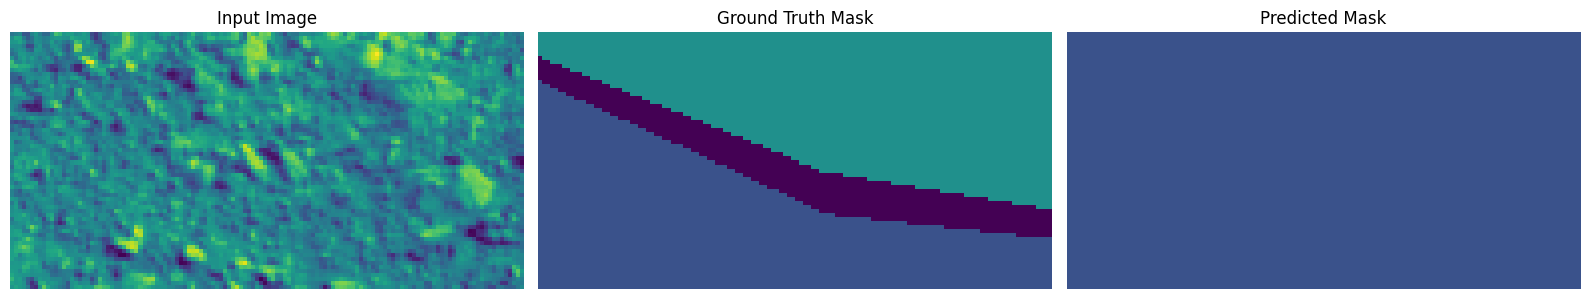

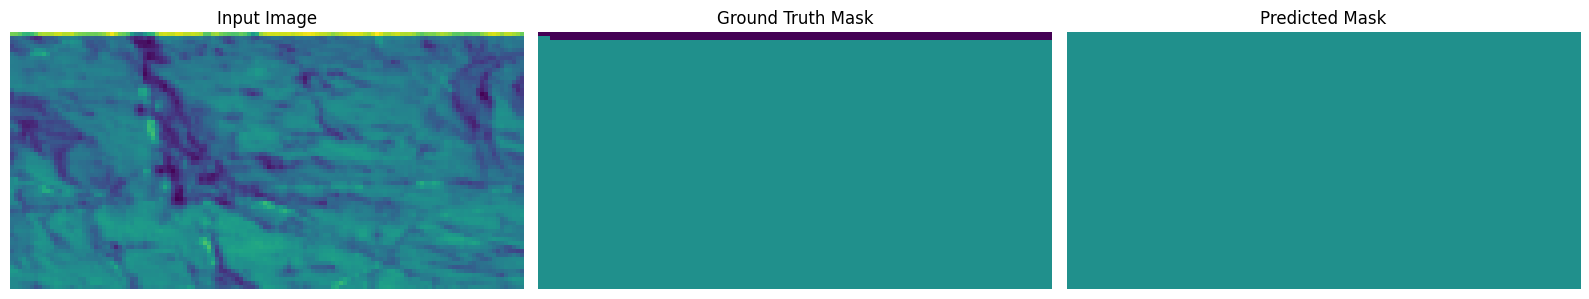

73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step - accuracy: 0.7265 - loss: 0.0518 - mean_iou: 0.8249 - val_accuracy: 0.7011 - val_loss: 0.2186 - val_mean_iou: 0.6886 - learning_rate: 1.5625e-05
Epoch 170/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - accuracy: 0.7265 - loss: 0.0518 - mean_iou: 0.8235 - val_accuracy: 0.6918 - val_loss: 0.2409 - val_mean_iou: 0.6648 - learning_rate: 1.5625e-05
Epoch 171/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 93ms/step - accuracy: 0.7167 - loss: 0.0593 - mean_iou: 0.7512 - val_accuracy: 0.6870 - val_loss: 0.3145 - val_mean_iou: 0.6172 - learning_rate: 1.5625e-05
Epoch 172/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.7171 - loss: 0.0605 - mean_iou: 0.7400 - val_accuracy: 0.7166 - val_loss: 0.2110 - val_mean_iou: 0.6976 - learning_rate: 1.5625e-05
Epoch 173/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.7247 - loss: 0.0536 - mean_iou: 0.7873

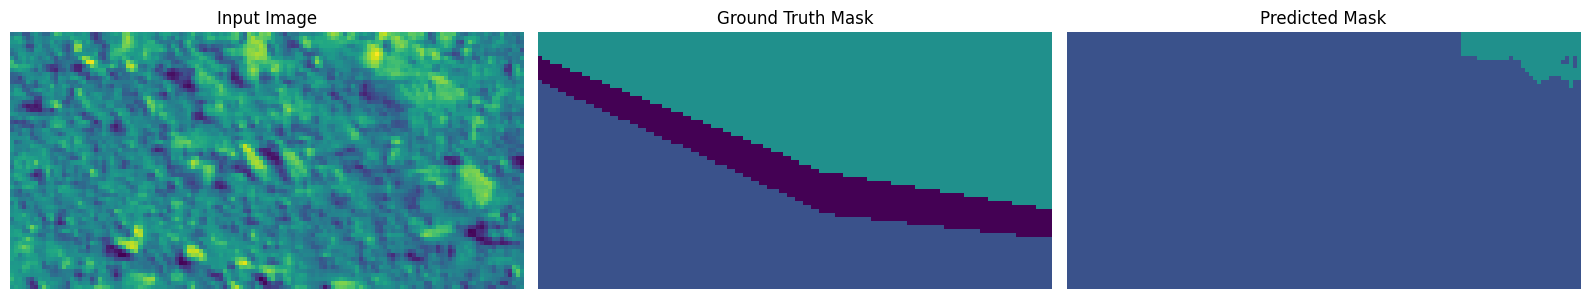

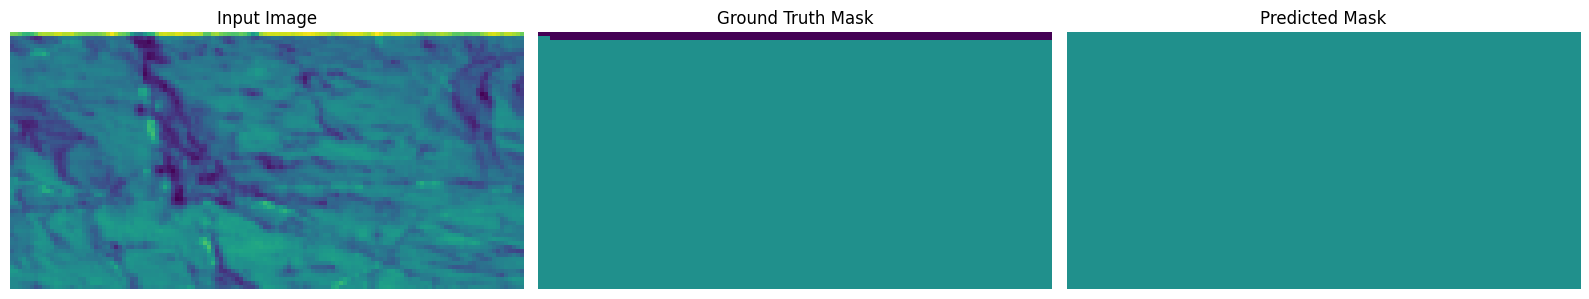

73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - accuracy: 0.7247 - loss: 0.0536 - mean_iou: 0.7874 - val_accuracy: 0.6811 - val_loss: 0.2871 - val_mean_iou: 0.6247 - learning_rate: 1.5625e-05
Epoch 174/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - accuracy: 0.7204 - loss: 0.0574 - mean_iou: 0.7587 - val_accuracy: 0.7152 - val_loss: 0.1968 - val_mean_iou: 0.6737 - learning_rate: 1.5625e-05
Epoch 175/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.7243 - loss: 0.0554 - mean_iou: 0.7700 - val_accuracy: 0.7023 - val_loss: 0.2241 - val_mean_iou: 0.6957 - learning_rate: 1.5625e-05
Epoch 176/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.7290 - loss: 0.0511 - mean_iou: 0.8065 - val_accuracy: 0.7041 - val_loss: 0.2072 - val_mean_iou: 0.6722 - learning_rate: 1.5625e-05
Epoch 177/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.7307 - loss: 0.0494 - mean_iou: 0.8260

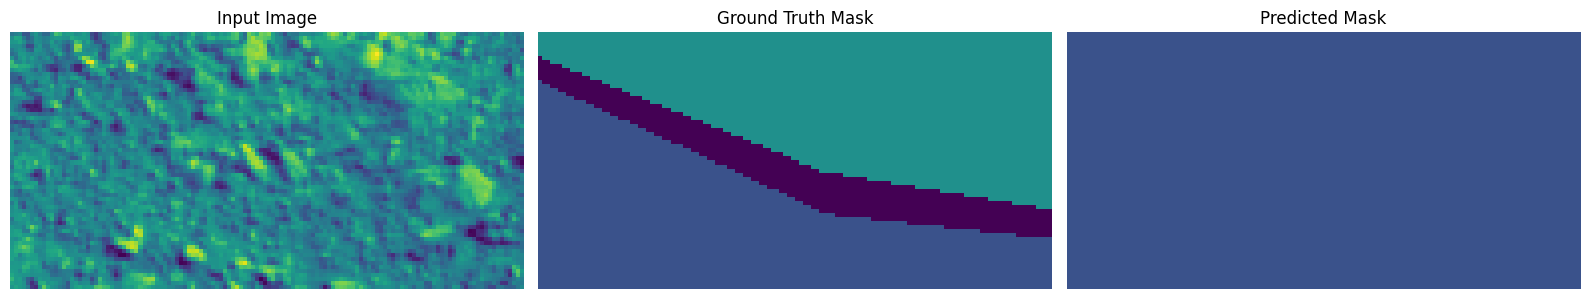

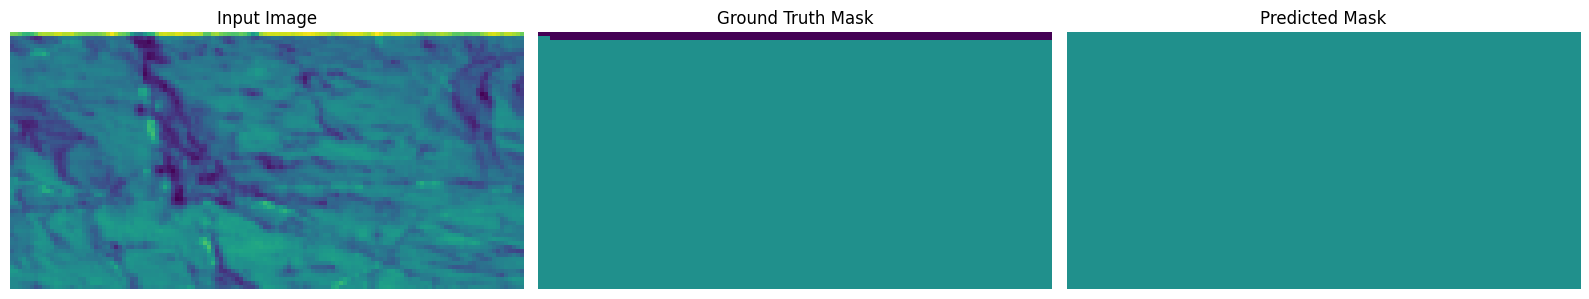

73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - accuracy: 0.7306 - loss: 0.0494 - mean_iou: 0.8260 - val_accuracy: 0.7081 - val_loss: 0.2387 - val_mean_iou: 0.6775 - learning_rate: 1.5625e-05
Epoch 178/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.7318 - loss: 0.0482 - mean_iou: 0.8321 - val_accuracy: 0.6922 - val_loss: 0.2310 - val_mean_iou: 0.6595 - learning_rate: 1.5625e-05
Epoch 179/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - accuracy: 0.7343 - loss: 0.0462 - mean_iou: 0.8400 - val_accuracy: 0.6970 - val_loss: 0.2219 - val_mean_iou: 0.6733 - learning_rate: 1.5625e-05
Epoch 180/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 0.7317 - loss: 0.0481 - mean_iou: 0.8252 - val_accuracy: 0.7166 - val_loss: 0.2298 - val_mean_iou: 0.6931 - learning_rate: 1.5625e-05
Epoch 181/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.7287 - loss: 0.0509 - mean_iou: 0.7907

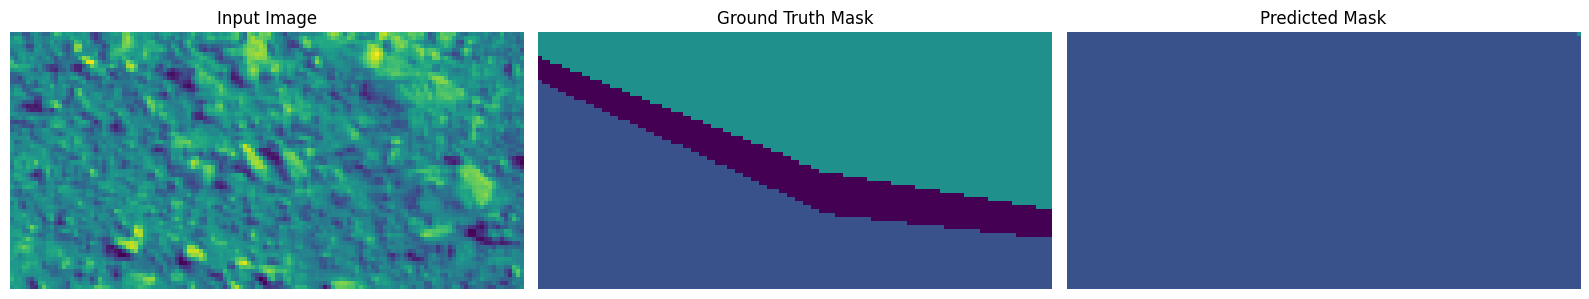

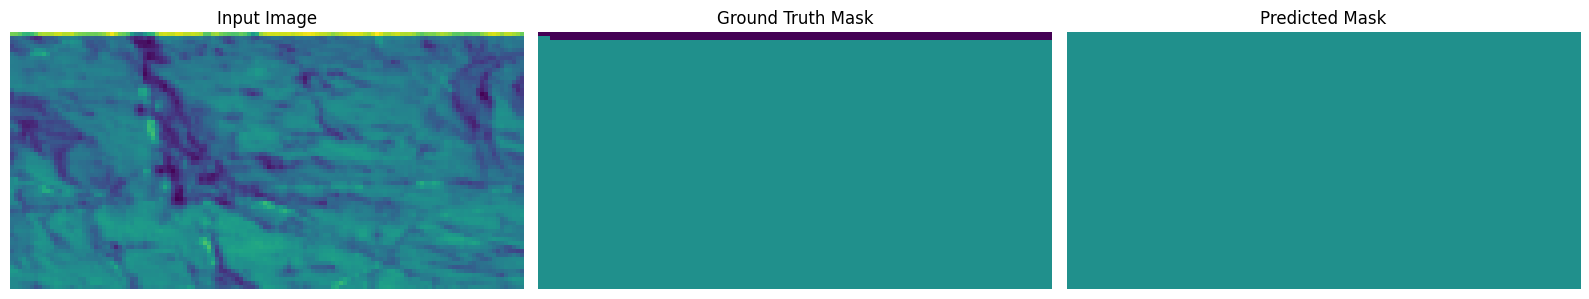

73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 100ms/step - accuracy: 0.7287 - loss: 0.0509 - mean_iou: 0.7909 - val_accuracy: 0.7089 - val_loss: 0.2138 - val_mean_iou: 0.6811 - learning_rate: 1.5625e-05
Epoch 182/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy: 0.7333 - loss: 0.0472 - mean_iou: 0.8139 - val_accuracy: 0.6905 - val_loss: 0.2530 - val_mean_iou: 0.6693 - learning_rate: 1.5625e-05
Epoch 183/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - accuracy: 0.7330 - loss: 0.0469 - mean_iou: 0.8145 - val_accuracy: 0.7099 - val_loss: 0.2200 - val_mean_iou: 0.6848 - learning_rate: 7.8125e-06
Epoch 184/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - accuracy: 0.7292 - loss: 0.0484 - mean_iou: 0.7853 - val_accuracy: 0.7123 - val_loss: 0.2160 - val_mean_iou: 0.7047 - learning_rate: 7.8125e-06
Epoch 185/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.7388 - loss: 0.0430 - mean_iou: 0.8566

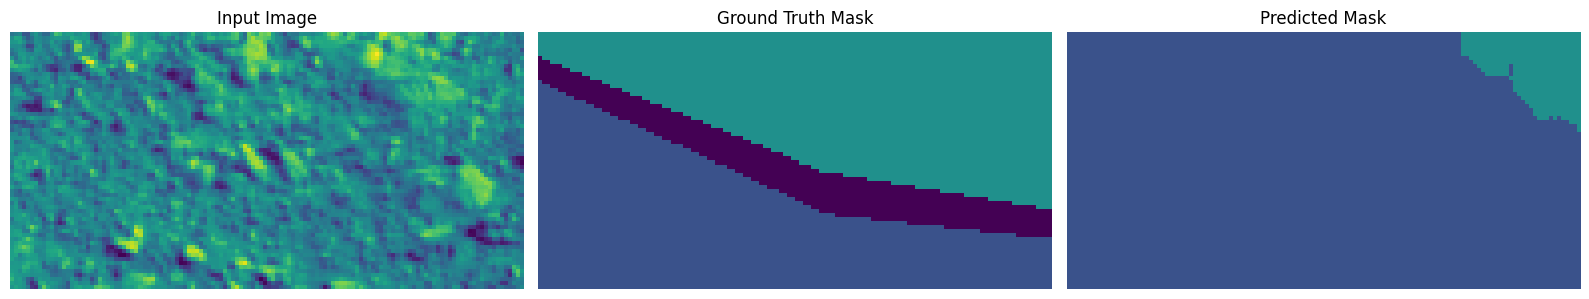

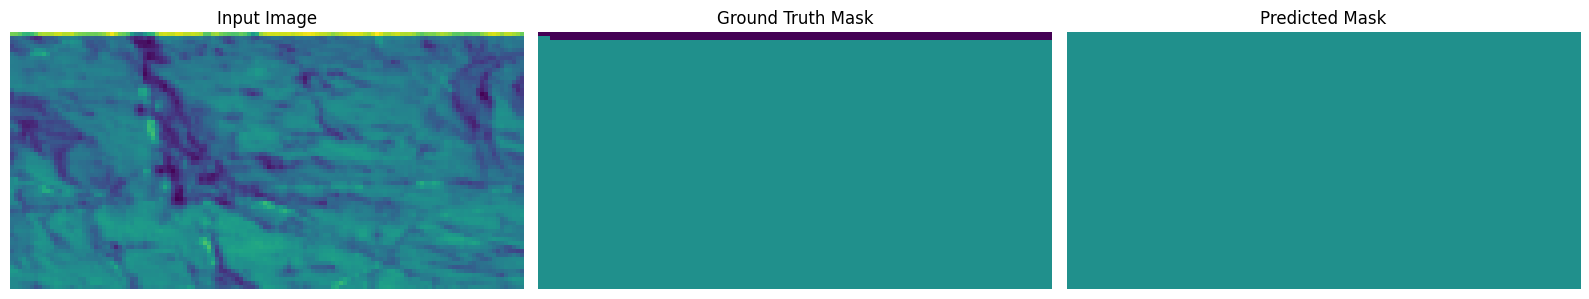

73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.7387 - loss: 0.0430 - mean_iou: 0.8567 - val_accuracy: 0.7130 - val_loss: 0.2023 - val_mean_iou: 0.7086 - learning_rate: 7.8125e-06
Epoch 186/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.7413 - loss: 0.0416 - mean_iou: 0.8775 - val_accuracy: 0.7176 - val_loss: 0.1963 - val_mean_iou: 0.7192 - learning_rate: 7.8125e-06
Epoch 187/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.7426 - loss: 0.0406 - mean_iou: 0.8877 - val_accuracy: 0.7088 - val_loss: 0.2142 - val_mean_iou: 0.7136 - learning_rate: 7.8125e-06
Epoch 188/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.7434 - loss: 0.0399 - mean_iou: 0.8930 - val_accuracy: 0.7093 - val_loss: 0.2103 - val_mean_iou: 0.7209 - learning_rate: 7.8125e-06
Epoch 189/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.7442 - loss: 0.0394 - mean_iou: 0.8968

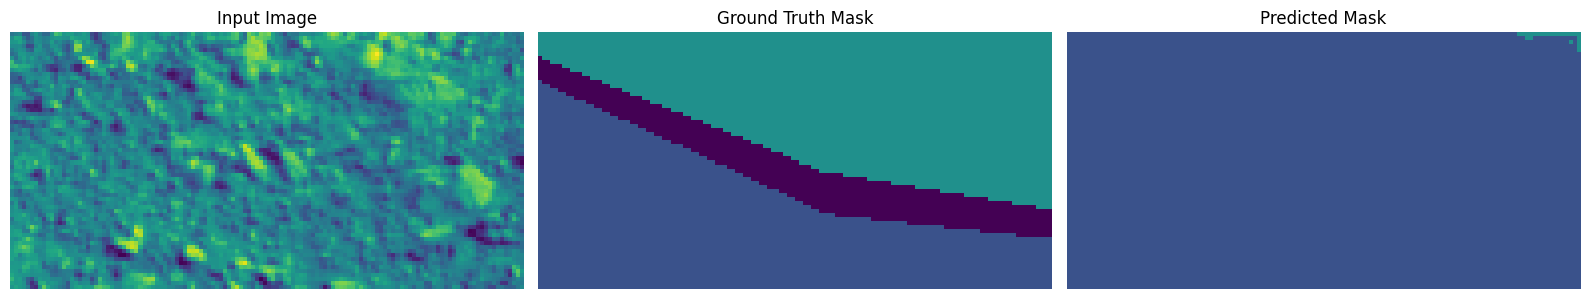

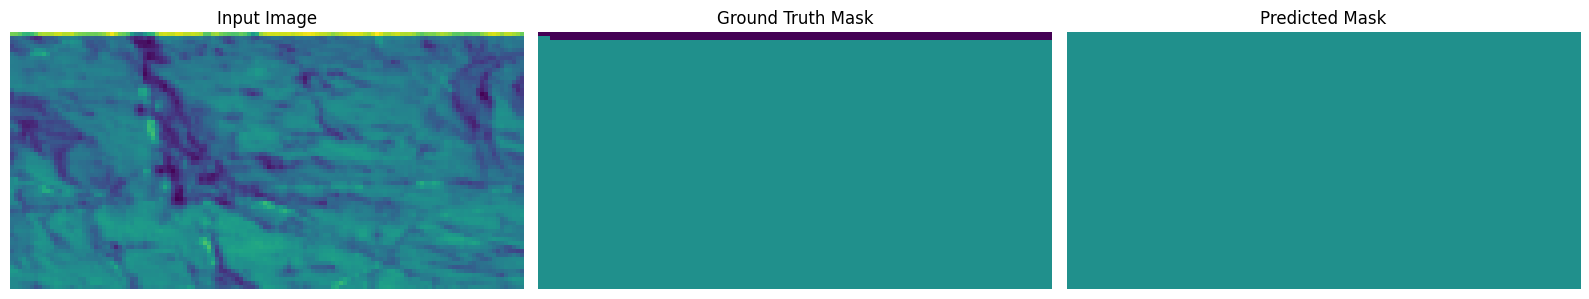

73/73 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - accuracy: 0.7441 - loss: 0.0394 - mean_iou: 0.8968 - val_accuracy: 0.7230 - val_loss: 0.1841 - val_mean_iou: 0.7336 - learning_rate: 7.8125e-06
Epoch 190/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy: 0.7451 - loss: 0.0391 - mean_iou: 0.8962 - val_accuracy: 0.7187 - val_loss: 0.1994 - val_mean_iou: 0.7313 - learning_rate: 7.8125e-06
Epoch 191/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.7460 - loss: 0.0382 - mean_iou: 0.8953 - val_accuracy: 0.7144 - val_loss: 0.2136 - val_mean_iou: 0.7226 - learning_rate: 7.8125e-06
Epoch 192/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.7469 - loss: 0.0375 - mean_iou: 0.9078 - val_accuracy: 0.7123 - val_loss: 0.2228 - val_mean_iou: 0.7186 - learning_rate: 7.8125e-06
Epoch 193/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.7459 - loss: 0.0379 - mean_iou: 0.9051

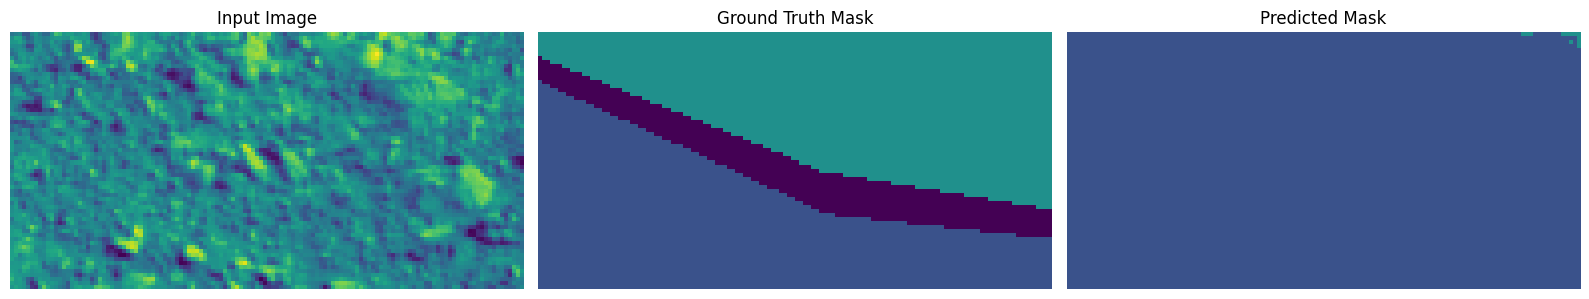

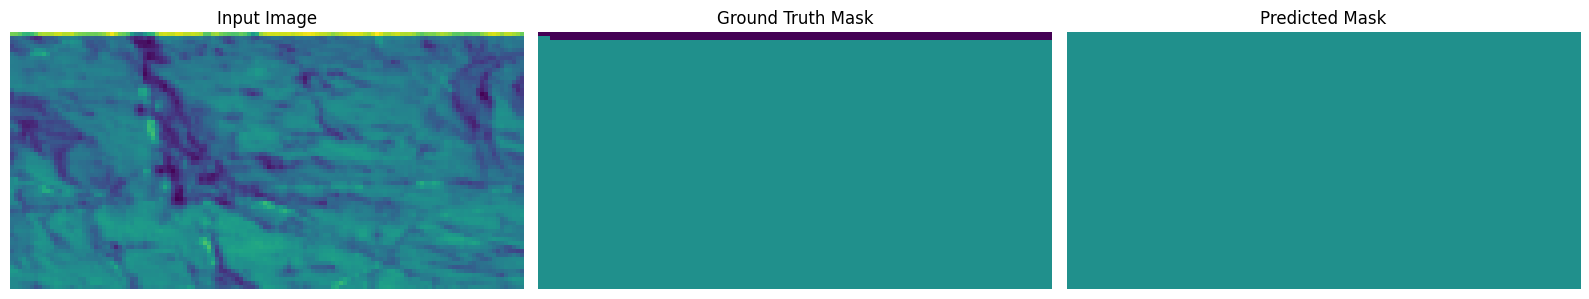

73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 107ms/step - accuracy: 0.7458 - loss: 0.0379 - mean_iou: 0.9051 - val_accuracy: 0.7262 - val_loss: 0.2175 - val_mean_iou: 0.7105 - learning_rate: 7.8125e-06
Epoch 194/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy: 0.7434 - loss: 0.0393 - mean_iou: 0.8793 - val_accuracy: 0.6886 - val_loss: 0.3121 - val_mean_iou: 0.6041 - learning_rate: 7.8125e-06
Epoch 195/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.7404 - loss: 0.0413 - mean_iou: 0.8284 - val_accuracy: 0.7185 - val_loss: 0.2058 - val_mean_iou: 0.7226 - learning_rate: 7.8125e-06
Epoch 196/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 0.7447 - loss: 0.0388 - mean_iou: 0.8735 - val_accuracy: 0.7206 - val_loss: 0.1973 - val_mean_iou: 0.7146 - learning_rate: 7.8125e-06
Epoch 197/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.7474 - loss: 0.0371 - mean_iou: 0.8930

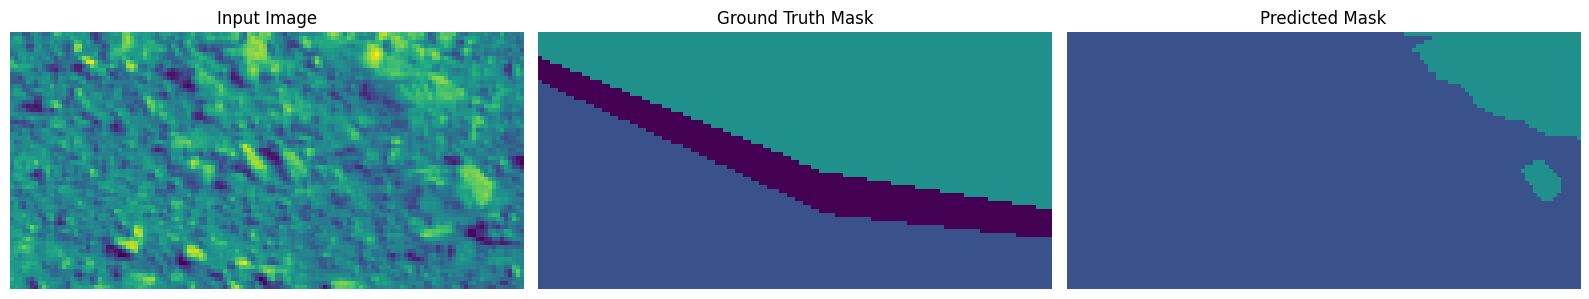

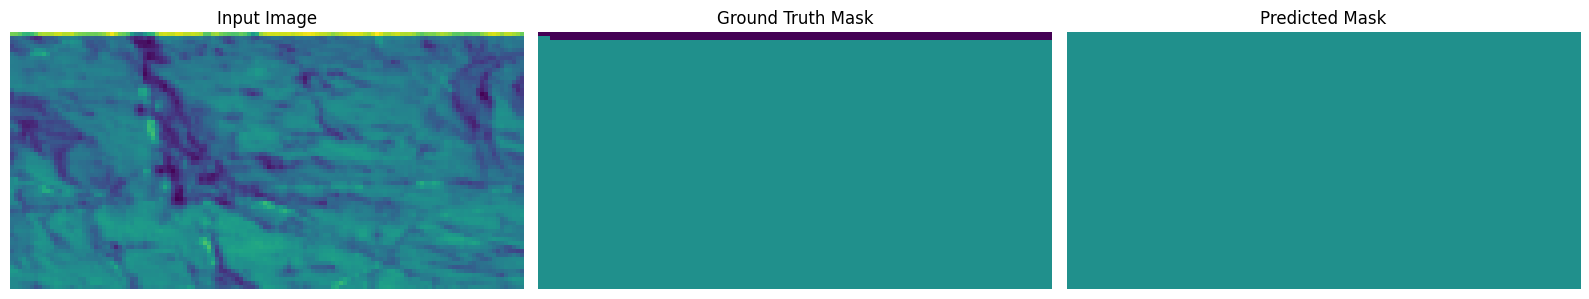

73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - accuracy: 0.7474 - loss: 0.0371 - mean_iou: 0.8930 - val_accuracy: 0.7169 - val_loss: 0.2115 - val_mean_iou: 0.7050 - learning_rate: 7.8125e-06
Epoch 198/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - accuracy: 0.7484 - loss: 0.0360 - mean_iou: 0.9176 - val_accuracy: 0.7130 - val_loss: 0.2066 - val_mean_iou: 0.6990 - learning_rate: 7.8125e-06
Epoch 199/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.7485 - loss: 0.0357 - mean_iou: 0.9201 - val_accuracy: 0.7173 - val_loss: 0.2049 - val_mean_iou: 0.7012 - learning_rate: 7.8125e-06
Epoch 200/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.7486 - loss: 0.0355 - mean_iou: 0.9227 - val_accuracy: 0.7187 - val_loss: 0.2181 - val_mean_iou: 0.6915 - learning_rate: 3.9063e-06
Epoch 201/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.7475 - loss: 0.0358 - mean_iou: 0.9202

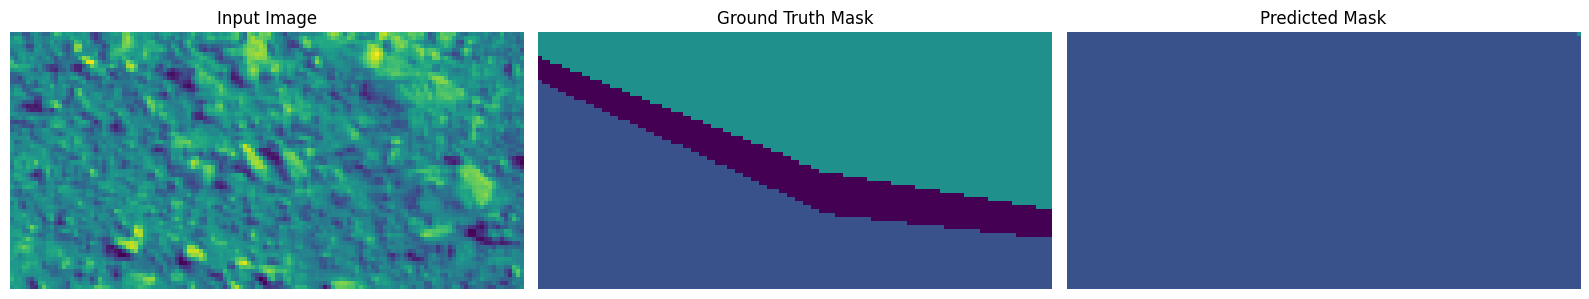

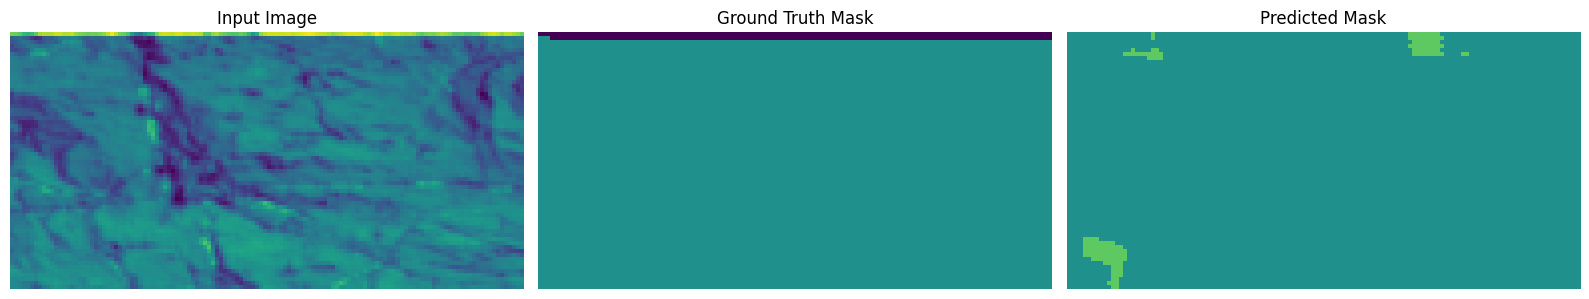

73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - accuracy: 0.7474 - loss: 0.0358 - mean_iou: 0.9202 - val_accuracy: 0.7163 - val_loss: 0.2186 - val_mean_iou: 0.6807 - learning_rate: 3.9063e-06
Epoch 202/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - accuracy: 0.7480 - loss: 0.0356 - mean_iou: 0.9238 - val_accuracy: 0.7166 - val_loss: 0.2138 - val_mean_iou: 0.6896 - learning_rate: 3.9063e-06
Epoch 203/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.7497 - loss: 0.0345 - mean_iou: 0.9283 - val_accuracy: 0.7174 - val_loss: 0.2126 - val_mean_iou: 0.6857 - learning_rate: 3.9063e-06
Epoch 204/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - accuracy: 0.7507 - loss: 0.0339 - mean_iou: 0.9340 - val_accuracy: 0.7161 - val_loss: 0.2141 - val_mean_iou: 0.6747 - learning_rate: 3.9063e-06
Epoch 205/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.7513 - loss: 0.0335 - mean_iou: 0.9356

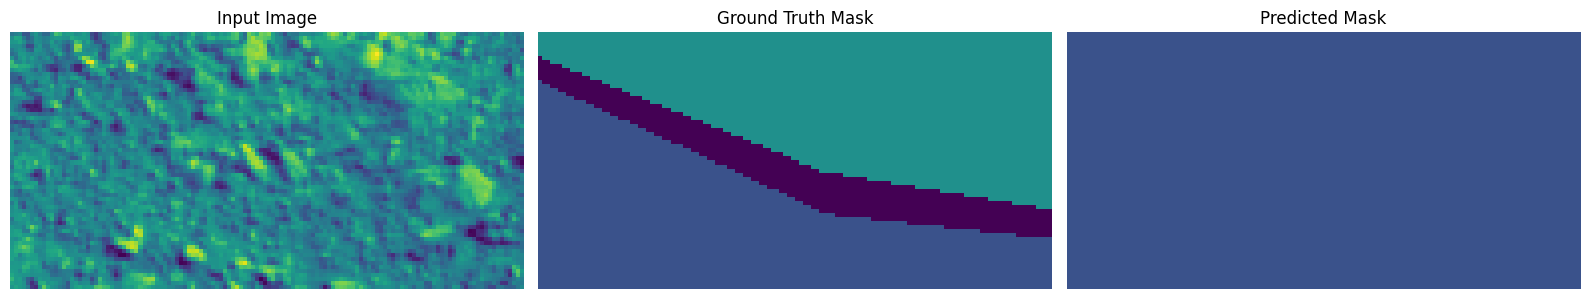

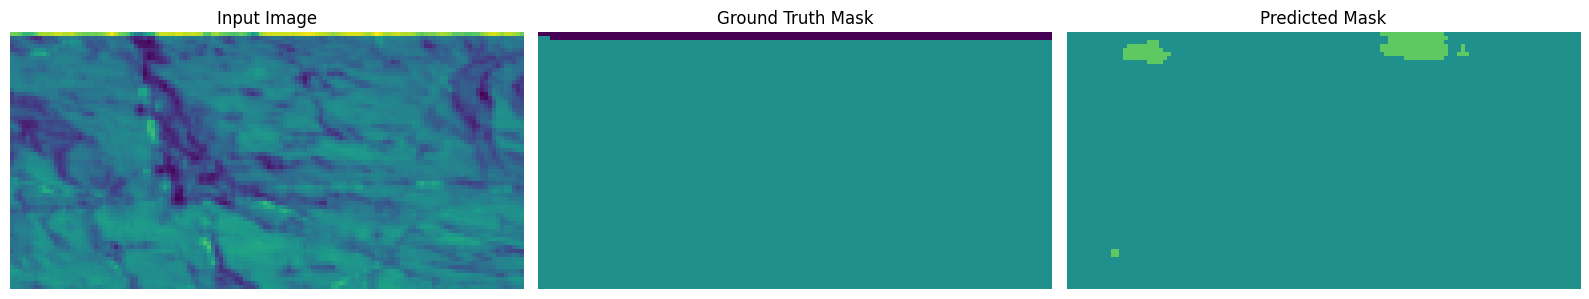

73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - accuracy: 0.7512 - loss: 0.0335 - mean_iou: 0.9356 - val_accuracy: 0.7171 - val_loss: 0.2137 - val_mean_iou: 0.6805 - learning_rate: 3.9063e-06
Epoch 206/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.7518 - loss: 0.0331 - mean_iou: 0.9396 - val_accuracy: 0.7150 - val_loss: 0.2229 - val_mean_iou: 0.6857 - learning_rate: 3.9063e-06
Epoch 207/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 92ms/step - accuracy: 0.7522 - loss: 0.0328 - mean_iou: 0.9408 - val_accuracy: 0.7092 - val_loss: 0.2334 - val_mean_iou: 0.6806 - learning_rate: 3.9063e-06
Epoch 208/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.7528 - loss: 0.0323 - mean_iou: 0.9418 - val_accuracy: 0.7166 - val_loss: 0.2278 - val_mean_iou: 0.6805 - learning_rate: 3.9063e-06
Epoch 209/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.7531 - loss: 0.0320 - mean_iou: 0.9435

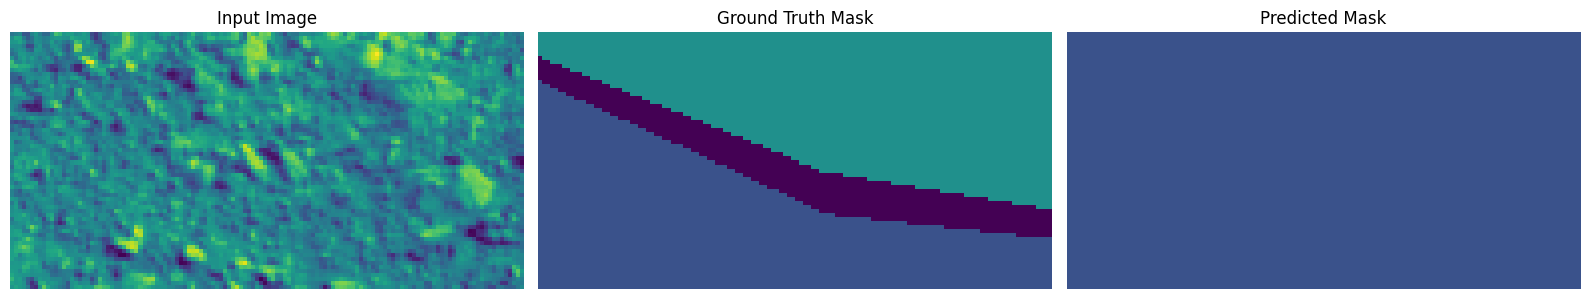

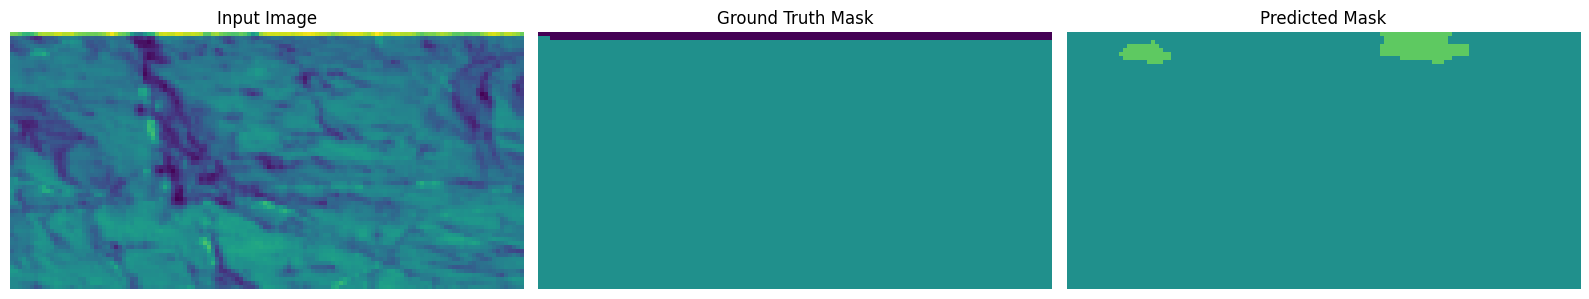

73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step - accuracy: 0.7531 - loss: 0.0320 - mean_iou: 0.9435 - val_accuracy: 0.7196 - val_loss: 0.2276 - val_mean_iou: 0.6851 - learning_rate: 3.9063e-06
Epoch 210/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - accuracy: 0.7524 - loss: 0.0321 - mean_iou: 0.9456 - val_accuracy: 0.7207 - val_loss: 0.2240 - val_mean_iou: 0.6829 - learning_rate: 1.9531e-06
Epoch 211/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - accuracy: 0.7529 - loss: 0.0318 - mean_iou: 0.9508 - val_accuracy: 0.7172 - val_loss: 0.2365 - val_mean_iou: 0.6872 - learning_rate: 1.9531e-06
Epoch 212/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - accuracy: 0.7537 - loss: 0.0314 - mean_iou: 0.9488 - val_accuracy: 0.7215 - val_loss: 0.2305 - val_mean_iou: 0.6960 - learning_rate: 1.9531e-06
Epoch 213/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.7543 - loss: 0.0311 - mean_iou: 0.9516

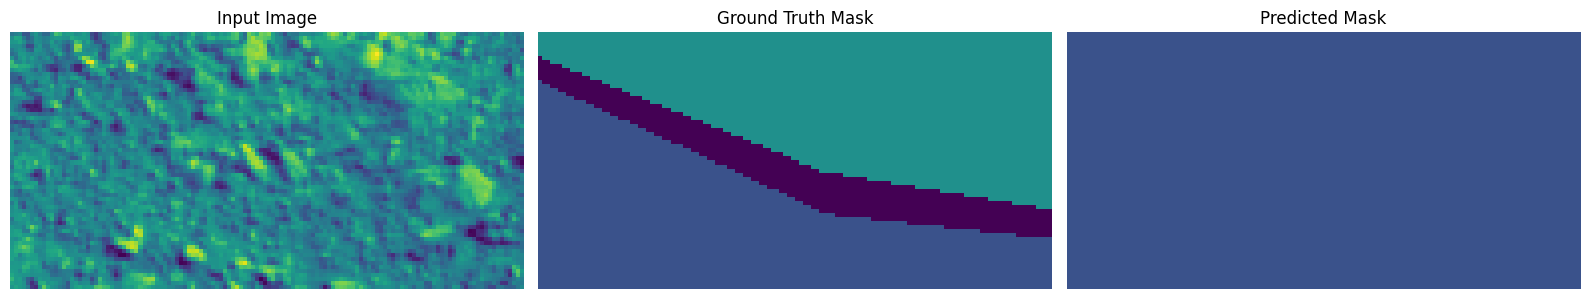

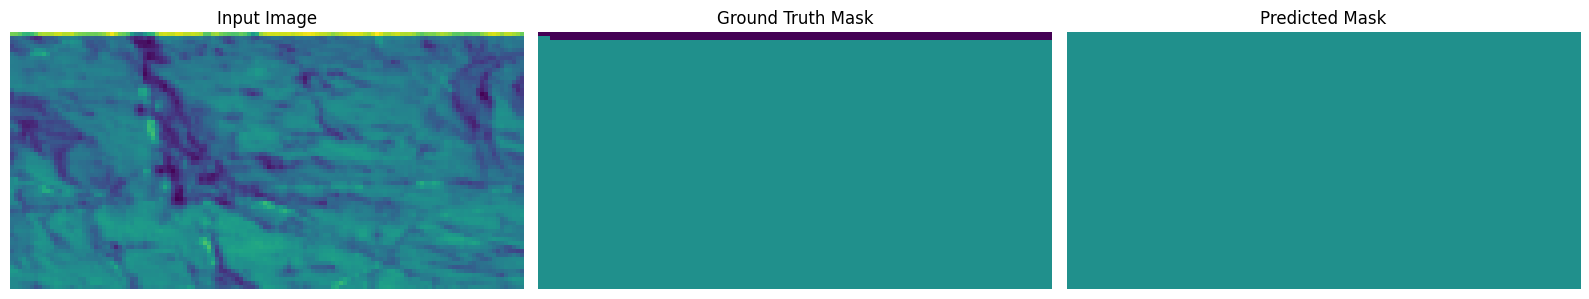

73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.7542 - loss: 0.0311 - mean_iou: 0.9517 - val_accuracy: 0.7187 - val_loss: 0.2357 - val_mean_iou: 0.6930 - learning_rate: 1.9531e-06
Epoch 214/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.7544 - loss: 0.0309 - mean_iou: 0.9515 - val_accuracy: 0.7140 - val_loss: 0.2460 - val_mean_iou: 0.6848 - learning_rate: 1.9531e-06
Epoch 215/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.7547 - loss: 0.0307 - mean_iou: 0.9528 - val_accuracy: 0.7206 - val_loss: 0.2354 - val_mean_iou: 0.6896 - learning_rate: 1.9531e-06
Epoch 216/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 0.7547 - loss: 0.0306 - mean_iou: 0.9565 - val_accuracy: 0.7142 - val_loss: 0.2451 - val_mean_iou: 0.6838 - learning_rate: 1.9531e-06
Epoch 217/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.7550 - loss: 0.0304 - mean_iou: 0.9555

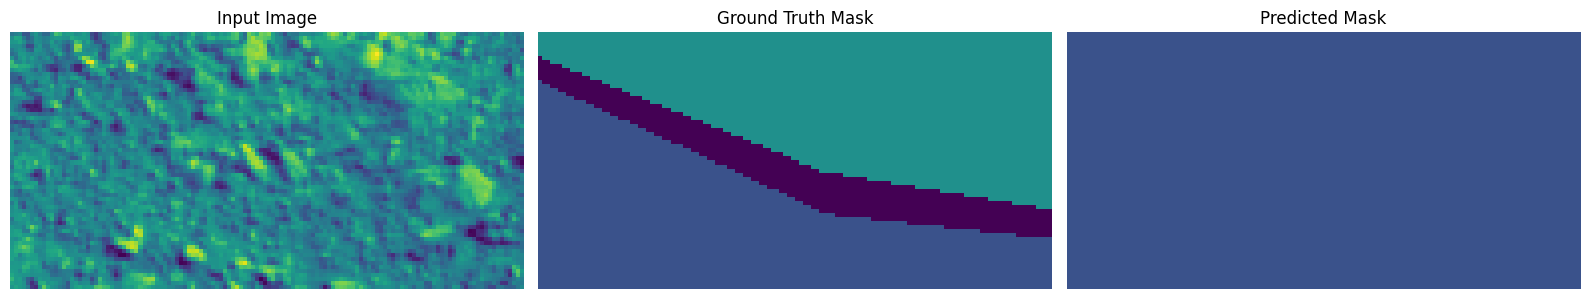

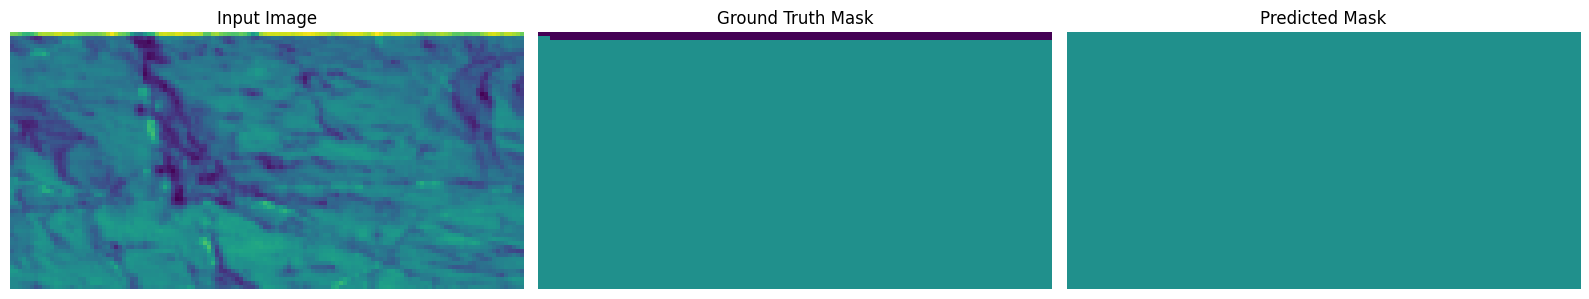

73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step - accuracy: 0.7550 - loss: 0.0304 - mean_iou: 0.9556 - val_accuracy: 0.7182 - val_loss: 0.2382 - val_mean_iou: 0.6872 - learning_rate: 1.9531e-06
Epoch 218/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.7553 - loss: 0.0302 - mean_iou: 0.9554 - val_accuracy: 0.7144 - val_loss: 0.2443 - val_mean_iou: 0.6842 - learning_rate: 1.9531e-06
Epoch 219/300
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - accuracy: 0.7554 - loss: 0.0300 - mean_iou: 0.9568 - val_accuracy: 0.7219 - val_loss: 0.2348 - val_mean_iou: 0.6884 - learning_rate: 1.9531e-06
Final validation Mean Intersection Over Union: 73.36%


In [ ]:
# Train the model
history2 = model2.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    validation_data=(X_val,y_val),
    callbacks=[early_stopping, viz_callback1, viz_callback2, tfk.callbacks.ReduceLROnPlateau(monitor='val_mean_iou', mode='max',factor=0.5, patience=10, min_delta=1e-4)],
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history2['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file with the accuracy included in the filename
timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"model2_{timestep_str}.keras"
model2.save(model_filename)

# Delete the model to free up resources

In [ ]:
# Predictions on the test set
preds = model2.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step
Predictions shape: (10022, 64, 128)


In [ ]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [ ]:
# Create and download the csv submission file
timestep_str ='preds_w0_20'

# model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

from google.colab import files
files.download(submission_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#  
<img src="https://airlab.deib.polimi.it/wp-content/uploads/2019/07/airlab-logo-new_cropped.png" width="350">

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Instagram_logo_2022.svg/800px-Instagram_logo_2022.svg.png" width="15"> **Instagram:** https://www.instagram.com/airlab_polimi/

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/LinkedIn_icon.svg/2048px-LinkedIn_icon.svg.png" width="15"> **LinkedIn:** https://www.linkedin.com/company/airlab-polimi/
___
Credits: Alberto Archetti 📧 alberto.archetti@polito.it





```
   Copyright 2024 Alberto Archetti

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
```